## Imports

In [1]:
import yaml
import torch
import torch.nn as nn
import numpy as np
import tqdm
import os
import argparse
from utils import get_prior
from torch.backends import cudnn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

cudnn.benchmark = True

def delete_module(name):
    import sys
    del sys.modules[name]
    
    
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load the config

In [3]:
config_file = './test_config.yaml'

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

with open(config_file, 'r') as f:
    config = yaml.load(f)
        
cfg = dict2namespace(config)
cfg

/pkgs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


Namespace(data=Namespace(batch_size=64, cates=['airplane'], data_dir='data/ShapeNetCore.v2.PC15k', dataset_scale=1, dataset_type='shapenet15k', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=0, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='datasets.pointflow_datasets'), inference=Namespace(eps='2e-5', num_points=2048, num_steps=15000, step_size_ratio=1, weight=1), log=Namespace(log_freq=10, save_dir='log/exp2', save_freq=20, val_freq=100000, viz_freq=20), models=Namespace(criticnet=Namespace(type='small_mlp'), scorenet=Namespace(type='small_mlp')), trainer=Namespace(c_iters=5, epochs=100, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), s_iters=1, seed=100, sigma_begin=0.2, sigma_end=0.

In [4]:
cfg.data

Namespace(batch_size=64, cates=['airplane'], data_dir='data/ShapeNetCore.v2.PC15k', dataset_scale=1, dataset_type='shapenet15k', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=0, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='datasets.pointflow_datasets')

In [5]:
cfg.trainer

Namespace(c_iters=5, epochs=100, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), s_iters=1, seed=100, sigma_begin=0.2, sigma_end=0.01, sigma_num=10, type='trainers.ae_trainer_3D')

In [6]:
cfg.models

Namespace(criticnet=Namespace(type='small_mlp'), scorenet=Namespace(type='small_mlp'))

In [7]:
cfg.inference

Namespace(eps='2e-5', num_points=2048, num_steps=15000, step_size_ratio=1, weight=1)

In [8]:
cfg.log

Namespace(log_freq=10, save_dir='log/exp2', save_freq=20, val_freq=100000, viz_freq=20)

# Train

In [9]:
from scorenet import Scorenet
from critic import Criticnet, SmallMLP
from utils import get_opt, set_random_seed, exact_jacobian_trace
from datasets.data_loader import get_data
import random
import torch.nn.utils.spectral_norm as spectral_norm

In [10]:
def visualize(pts, return_fig=False):
    pts = pts.detach().cpu().squeeze().numpy()
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.scatter(pts[:, 2], pts[:, 0], pts[:, 1], s=20)
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_zlim(-1, 1)
    
    if return_fig:
        return fig, ax1

In [11]:
set_random_seed(getattr(cfg.trainer, "seed", 666))

# load data
train_data = get_data(cfg.data, 0)
#tr_pts = train_data['tr_points'].unsqueeze(0)
tr_pts = train_data['tr_points']

#te_pts = train_data['te_points'].unsqueeze(0)
# te_pts = train_data['te_points']

tr_pts = tr_pts.to(device)
# te_pts = te_pts.to(device)
tr_pts.requires_grad_()
# te_pts.requires_grad_();

100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Total number of data:2832
Min number of points: (train)2048 (test)2048


tensor([[ 0.0257, -0.1490,  0.4452],
        [-0.0409,  0.0225, -0.6551],
        [ 0.7364, -0.1115,  0.1131],
        ...,
        [-0.2616, -0.1617, -0.0271],
        [ 0.0296, -0.1490, -0.8084],
        [ 0.4217, -0.1483, -0.0257]], device='cuda:0', requires_grad=True)

### Visualize the data

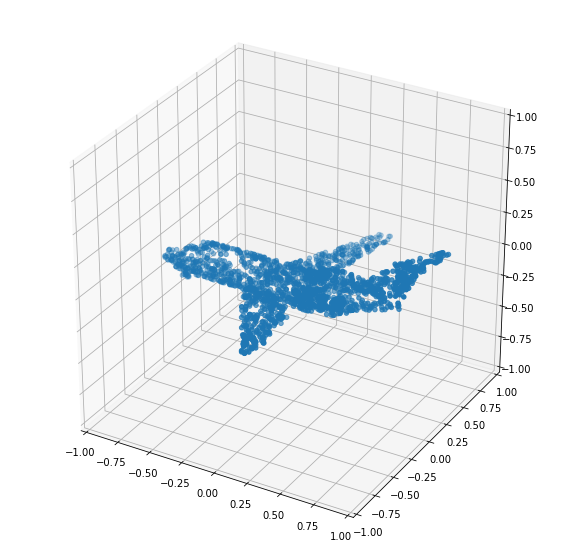

In [12]:
visualize(tr_pts)

In [13]:
# sigmas
if hasattr(cfg.trainer, "sigmas"):
    np_sigmas = cfg.trainer.sigmas
else:
    sigma_begin = float(cfg.trainer.sigma_begin)
    sigma_end = float(cfg.trainer.sigma_end)
    num_classes = int(cfg.trainer.sigma_num)
    np_sigmas = np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_classes))
print("Sigma:, ", np_sigmas)
sigmas = torch.tensor(np.array(np_sigmas)).float().to(device).view(-1, 1)

Sigma:,  [0.2        0.14337423 0.10278085 0.07368063 0.05281952 0.03786479
 0.02714418 0.01945888 0.01394951 0.01      ]


In [14]:
sample_perturbed_points = tr_pts + torch.randn_like(tr_pts) * sigmas[..., None]

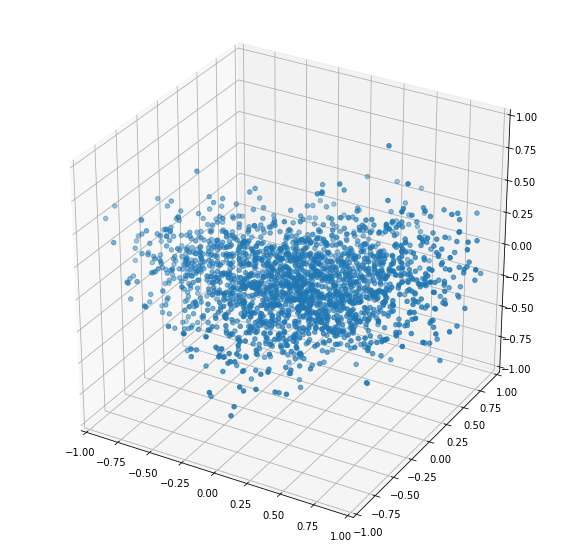

In [15]:
visualize(sample_perturbed_points[0])

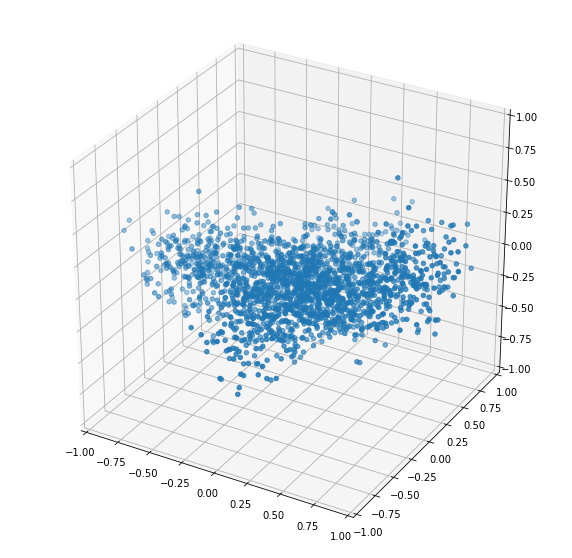

In [16]:
visualize(sample_perturbed_points[1])

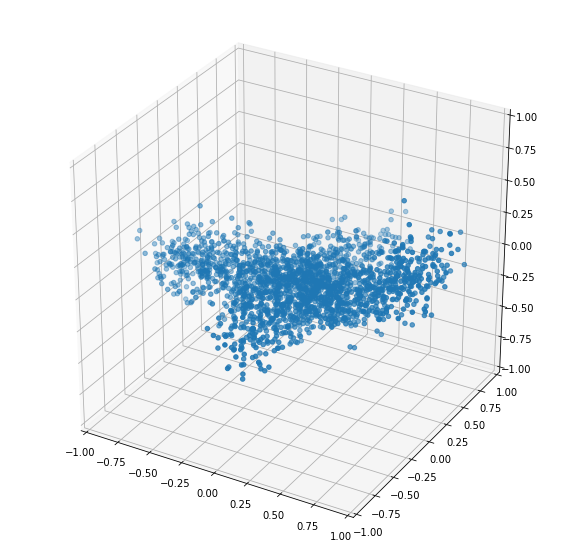

In [17]:
visualize(sample_perturbed_points[2])

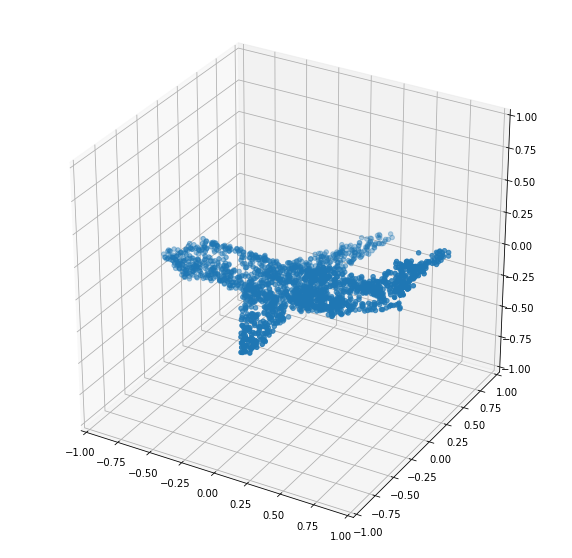

In [18]:
visualize(sample_perturbed_points[-1])

In [ ]:
# def apply_spectral_norm(module):
#     norm = nn.BatchNorm1d
#     if not isinstance(module, norm) and 'weight' in module._parameters:
#         spectral_norm(module)

## Both SmallMLP

In [ ]:
# score net
#score_net = Scorenet()
score_net = SmallMLP(in_dim=3, hidden_dim=512)
#critic_net = Criticnet()
critic_net = SmallMLP(in_dim=3, hidden_dim=512)

#critic_net.apply(apply_spectral_norm)
critic_net.to(device)
score_net.to(device)

print(score_net)
print(critic_net)

# optimizer
opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

## Just SmallMLP CriticNet

In [19]:
critic_net = SmallMLP(in_dim=3)
score_net = Scorenet()
#critic_net = Criticnet()
#critic_net = SmallMLP(in_dim=3)

#critic_net.apply(apply_spectral_norm)
critic_net.to(device)
score_net.to(device)

print(score_net)
print(critic_net)

# optimizer
opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

Scorenet(
  (conv_p): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
  (blocks): ModuleList(
    (0): ResnetBlockConv1d(
      (bn_0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc_0): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_c): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
      (actvn): ReLU()
    )
    (1): ResnetBlockConv1d(
      (bn_0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc_0): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_c): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
      (actvn): ReLU()
    )
    (2): ResnetBlockConv1d(
      (bn_0): BatchN

In [20]:
# training
start_epoch = 0
n_epochs = 30000
print("Start epoch: %d End epoch: %d" % (start_epoch, cfg.trainer.epochs))
k_iters = 10
e_iters = 1
# batch_size = 10
# sigmas = sigmas[-1:]

losses = []
cnt = 0
for epoch in range(start_epoch, n_epochs):
    score_net.train()
    critic_net.train()
    opt_scorenet.zero_grad()
    opt_criticnet.zero_grad()
    
#     sigmas_idx = torch.randint(0, len(sigmas), (batch_size,), device=tr_pts.device)
#     used_sigmas = sigmas[sigmas_idx].float()
    used_sigmas = sigmas
    perturbed_points = tr_pts + torch.randn_like(tr_pts) * used_sigmas[..., None]
    
    score_pred = score_net(perturbed_points, used_sigmas)
    critic_output = critic_net(perturbed_points, used_sigmas)
    
    t1 = (score_pred * critic_output).sum(-1)
    t2 = exact_jacobian_trace(critic_output, perturbed_points)
    
    stein = t1 + t2
    l2_penalty = (critic_output * critic_output).sum(-1).mean()
    loss = stein.mean()
    losses.append(loss)
    
    cycle_iter = epoch % (k_iters + e_iters)
    cpu_loss = loss.detach().cpu().item()
    cpu_t1 = t1.mean().detach().cpu().item()
    cpu_t2 = t2.mean().detach().cpu().item()
    if cycle_iter < k_iters:
        (-loss + l2_penalty).backward()
        opt_criticnet.step()
        print("Epoch (critic) %d Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2))
    else:
        loss.backward()
        opt_scorenet.step()
        print("Epoch (score) %d Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2))
#     if epoch > 6000:
#         k_iters = 40
#         e_iters = 1
#     if epoch > 10000:
#         k_iters = 50
#         e_iters = 1

Start epoch: 0 End epoch: 100
Epoch (critic) 0 Loss=0.06685 t1=-0.00082 t2=0.06767
Epoch (critic) 1 Loss=0.33495 t1=0.01601 t2=0.31894
Epoch (critic) 2 Loss=0.60553 t1=0.03227 t2=0.57326
Epoch (critic) 3 Loss=0.87862 t1=0.04633 t2=0.83229
Epoch (critic) 4 Loss=1.15935 t1=0.06090 t2=1.09845
Epoch (critic) 5 Loss=1.44762 t1=0.07395 t2=1.37367
Epoch (critic) 6 Loss=1.74646 t1=0.08696 t2=1.65949
Epoch (critic) 7 Loss=2.05818 t1=0.10007 t2=1.95811
Epoch (critic) 8 Loss=2.38416 t1=0.11268 t2=2.27148
Epoch (critic) 9 Loss=2.72258 t1=0.12194 t2=2.60064
Epoch (score) 10 Loss=3.08234 t1=0.13544 t2=2.94690
Epoch (critic) 11 Loss=1.92017 t1=-1.02684 t2=2.94701
Epoch (critic) 12 Loss=2.15752 t1=-1.13056 t2=3.28808
Epoch (critic) 13 Loss=2.40228 t1=-1.22495 t2=3.62723
Epoch (critic) 14 Loss=2.66495 t1=-1.30095 t2=3.96590
Epoch (critic) 15 Loss=2.92866 t1=-1.37800 t2=4.30666
Epoch (critic) 16 Loss=3.20544 t1=-1.44616 t2=4.65160
Epoch (critic) 17 Loss=3.50011 t1=-1.50223 t2=5.00234
Epoch (critic) 18 L

Epoch (critic) 147 Loss=8.33244 t1=-11.68131 t2=20.01375
Epoch (critic) 148 Loss=8.44066 t1=-11.52699 t2=19.96764
Epoch (critic) 149 Loss=8.26656 t1=-11.66150 t2=19.92806
Epoch (critic) 150 Loss=8.49254 t1=-11.42542 t2=19.91796
Epoch (critic) 151 Loss=8.34717 t1=-11.54524 t2=19.89241
Epoch (critic) 152 Loss=8.48530 t1=-11.44488 t2=19.93019
Epoch (score) 153 Loss=8.46335 t1=-11.43412 t2=19.89747
Epoch (critic) 154 Loss=8.07178 t1=-11.78540 t2=19.85718
Epoch (critic) 155 Loss=8.05824 t1=-11.89679 t2=19.95503
Epoch (critic) 156 Loss=8.10230 t1=-11.89421 t2=19.99652
Epoch (critic) 157 Loss=8.16514 t1=-11.82864 t2=19.99378
Epoch (critic) 158 Loss=8.09855 t1=-11.99189 t2=20.09044
Epoch (critic) 159 Loss=8.42236 t1=-11.61959 t2=20.04195
Epoch (critic) 160 Loss=8.20278 t1=-11.82808 t2=20.03085
Epoch (critic) 161 Loss=8.16185 t1=-11.89747 t2=20.05932
Epoch (critic) 162 Loss=8.54500 t1=-11.46233 t2=20.00733
Epoch (critic) 163 Loss=8.02107 t1=-12.04725 t2=20.06833
Epoch (score) 164 Loss=8.44630 t

Epoch (critic) 292 Loss=13.53925 t1=-14.55430 t2=28.09355
Epoch (critic) 293 Loss=13.59647 t1=-14.86432 t2=28.46078
Epoch (critic) 294 Loss=14.22105 t1=-14.54133 t2=28.76238
Epoch (critic) 295 Loss=13.87966 t1=-15.14481 t2=29.02447
Epoch (score) 296 Loss=14.30124 t1=-14.68039 t2=28.98163
Epoch (critic) 297 Loss=13.51481 t1=-15.42256 t2=28.93738
Epoch (critic) 298 Loss=13.78043 t1=-15.37305 t2=29.15348
Epoch (critic) 299 Loss=14.18347 t1=-14.97812 t2=29.16158
Epoch (critic) 300 Loss=14.51442 t1=-14.96206 t2=29.47648
Epoch (critic) 301 Loss=14.72914 t1=-15.01535 t2=29.74449
Epoch (critic) 302 Loss=14.89545 t1=-15.11156 t2=30.00701
Epoch (critic) 303 Loss=15.27708 t1=-14.89286 t2=30.16994
Epoch (critic) 304 Loss=15.53357 t1=-14.94397 t2=30.47754
Epoch (critic) 305 Loss=15.66091 t1=-14.93306 t2=30.59397
Epoch (critic) 306 Loss=16.02076 t1=-14.83718 t2=30.85793
Epoch (score) 307 Loss=16.02479 t1=-15.11187 t2=31.13667
Epoch (critic) 308 Loss=13.96826 t1=-17.09811 t2=31.06637
Epoch (critic) 3

Epoch (critic) 435 Loss=14.91796 t1=-15.86488 t2=30.78284
Epoch (critic) 436 Loss=15.88919 t1=-15.04639 t2=30.93558
Epoch (critic) 437 Loss=15.94295 t1=-15.34677 t2=31.28972
Epoch (critic) 438 Loss=16.17440 t1=-15.23812 t2=31.41251
Epoch (score) 439 Loss=16.60585 t1=-15.22509 t2=31.83094
Epoch (critic) 440 Loss=14.29550 t1=-17.30326 t2=31.59875
Epoch (critic) 441 Loss=14.85795 t1=-16.83408 t2=31.69203
Epoch (critic) 442 Loss=14.77074 t1=-17.06325 t2=31.83398
Epoch (critic) 443 Loss=15.10358 t1=-16.51401 t2=31.61759
Epoch (critic) 444 Loss=15.14554 t1=-15.97139 t2=31.11693
Epoch (critic) 445 Loss=15.70439 t1=-15.35211 t2=31.05650
Epoch (critic) 446 Loss=15.93044 t1=-15.14662 t2=31.07707
Epoch (critic) 447 Loss=15.32456 t1=-15.58160 t2=30.90616
Epoch (critic) 448 Loss=15.52087 t1=-15.61523 t2=31.13611
Epoch (critic) 449 Loss=16.46782 t1=-14.77708 t2=31.24489
Epoch (score) 450 Loss=16.47307 t1=-15.05230 t2=31.52538
Epoch (critic) 451 Loss=14.87411 t1=-16.52860 t2=31.40271
Epoch (critic) 4

Epoch (critic) 578 Loss=19.79790 t1=-17.44919 t2=37.24709
Epoch (critic) 579 Loss=20.08255 t1=-16.80186 t2=36.88441
Epoch (critic) 580 Loss=20.53091 t1=-16.11295 t2=36.64386
Epoch (critic) 581 Loss=19.80826 t1=-17.08548 t2=36.89373
Epoch (score) 582 Loss=20.20115 t1=-16.40473 t2=36.60587
Epoch (critic) 583 Loss=18.76348 t1=-17.92567 t2=36.68916
Epoch (critic) 584 Loss=18.62259 t1=-17.79847 t2=36.42106
Epoch (critic) 585 Loss=18.20981 t1=-18.38702 t2=36.59683
Epoch (critic) 586 Loss=19.01580 t1=-17.72281 t2=36.73861
Epoch (critic) 587 Loss=18.19885 t1=-18.35034 t2=36.54919
Epoch (critic) 588 Loss=19.02973 t1=-17.52582 t2=36.55555
Epoch (critic) 589 Loss=18.93140 t1=-17.24783 t2=36.17923
Epoch (critic) 590 Loss=19.12323 t1=-16.69321 t2=35.81644
Epoch (critic) 591 Loss=19.02015 t1=-16.45375 t2=35.47390
Epoch (critic) 592 Loss=19.27840 t1=-16.27207 t2=35.55047
Epoch (score) 593 Loss=19.63754 t1=-16.45193 t2=36.08947
Epoch (critic) 594 Loss=19.03852 t1=-16.75670 t2=35.79523
Epoch (critic) 5

Epoch (critic) 721 Loss=19.25065 t1=-17.66213 t2=36.91279
Epoch (critic) 722 Loss=19.93971 t1=-17.26675 t2=37.20646
Epoch (critic) 723 Loss=19.33841 t1=-18.13568 t2=37.47409
Epoch (critic) 724 Loss=19.74980 t1=-18.10463 t2=37.85443
Epoch (score) 725 Loss=19.46348 t1=-18.14230 t2=37.60579
Epoch (critic) 726 Loss=17.78987 t1=-19.87959 t2=37.66946
Epoch (critic) 727 Loss=18.44255 t1=-18.99275 t2=37.43530
Epoch (critic) 728 Loss=18.32724 t1=-18.37528 t2=36.70252
Epoch (critic) 729 Loss=18.51302 t1=-17.26682 t2=35.77984
Epoch (critic) 730 Loss=18.77737 t1=-16.24348 t2=35.02085
Epoch (critic) 731 Loss=19.44666 t1=-15.70327 t2=35.14993
Epoch (critic) 732 Loss=18.76616 t1=-16.33491 t2=35.10106
Epoch (critic) 733 Loss=18.95947 t1=-16.56441 t2=35.52388
Epoch (critic) 734 Loss=20.00375 t1=-15.39978 t2=35.40353
Epoch (critic) 735 Loss=19.52597 t1=-16.04082 t2=35.56679
Epoch (score) 736 Loss=19.89147 t1=-16.50024 t2=36.39171
Epoch (critic) 737 Loss=17.86530 t1=-18.34845 t2=36.21375
Epoch (critic) 7

Epoch (critic) 863 Loss=15.77292 t1=-9.64615 t2=25.41907
Epoch (critic) 864 Loss=16.28184 t1=-8.78115 t2=25.06299
Epoch (critic) 865 Loss=16.99444 t1=-8.71714 t2=25.71158
Epoch (critic) 866 Loss=16.86192 t1=-9.42524 t2=26.28716
Epoch (critic) 867 Loss=17.16058 t1=-9.63050 t2=26.79107
Epoch (score) 868 Loss=17.92743 t1=-9.30268 t2=27.23012
Epoch (critic) 869 Loss=16.48342 t1=-11.08557 t2=27.56898
Epoch (critic) 870 Loss=17.04349 t1=-10.63163 t2=27.67513
Epoch (critic) 871 Loss=18.14797 t1=-10.18082 t2=28.32879
Epoch (critic) 872 Loss=19.01655 t1=-9.33242 t2=28.34897
Epoch (critic) 873 Loss=19.62852 t1=-9.34726 t2=28.97578
Epoch (critic) 874 Loss=20.31808 t1=-9.00520 t2=29.32328
Epoch (critic) 875 Loss=19.97141 t1=-9.41516 t2=29.38657
Epoch (critic) 876 Loss=20.98644 t1=-8.50614 t2=29.49258
Epoch (critic) 877 Loss=20.32904 t1=-9.81984 t2=30.14888
Epoch (critic) 878 Loss=21.03559 t1=-8.64559 t2=29.68119
Epoch (score) 879 Loss=20.81992 t1=-8.63057 t2=29.45049
Epoch (critic) 880 Loss=19.453

Epoch (critic) 1007 Loss=23.42470 t1=-17.79277 t2=41.21748
Epoch (critic) 1008 Loss=22.45936 t1=-19.29686 t2=41.75622
Epoch (critic) 1009 Loss=23.62242 t1=-18.27683 t2=41.89926
Epoch (critic) 1010 Loss=24.28827 t1=-18.60460 t2=42.89286
Epoch (score) 1011 Loss=24.32971 t1=-18.19281 t2=42.52252
Epoch (critic) 1012 Loss=22.81266 t1=-20.82901 t2=43.64166
Epoch (critic) 1013 Loss=22.68696 t1=-21.03979 t2=43.72675
Epoch (critic) 1014 Loss=22.86663 t1=-20.94219 t2=43.80882
Epoch (critic) 1015 Loss=24.56573 t1=-19.49498 t2=44.06071
Epoch (critic) 1016 Loss=26.25941 t1=-17.53235 t2=43.79177
Epoch (critic) 1017 Loss=25.94633 t1=-17.97965 t2=43.92598
Epoch (critic) 1018 Loss=26.59541 t1=-16.59593 t2=43.19134
Epoch (critic) 1019 Loss=27.14567 t1=-15.75261 t2=42.89827
Epoch (critic) 1020 Loss=28.40009 t1=-14.37737 t2=42.77746
Epoch (critic) 1021 Loss=27.34752 t1=-15.33974 t2=42.68726
Epoch (score) 1022 Loss=26.52297 t1=-15.83100 t2=42.35397
Epoch (critic) 1023 Loss=22.47911 t1=-19.78648 t2=42.26559

Epoch (critic) 1147 Loss=26.51407 t1=-10.11883 t2=36.63290
Epoch (critic) 1148 Loss=25.36727 t1=-11.06232 t2=36.42959
Epoch (critic) 1149 Loss=26.94040 t1=-10.04655 t2=36.98695
Epoch (critic) 1150 Loss=25.66336 t1=-10.75258 t2=36.41594
Epoch (critic) 1151 Loss=25.64278 t1=-10.53979 t2=36.18257
Epoch (critic) 1152 Loss=26.88269 t1=-8.71529 t2=35.59798
Epoch (critic) 1153 Loss=28.11094 t1=-7.00834 t2=35.11928
Epoch (score) 1154 Loss=28.38976 t1=-7.08148 t2=35.47125
Epoch (critic) 1155 Loss=24.20675 t1=-11.09173 t2=35.29848
Epoch (critic) 1156 Loss=25.77861 t1=-10.23800 t2=36.01661
Epoch (critic) 1157 Loss=26.15749 t1=-9.47834 t2=35.63583
Epoch (critic) 1158 Loss=25.94597 t1=-10.26945 t2=36.21542
Epoch (critic) 1159 Loss=26.39528 t1=-10.76467 t2=37.15996
Epoch (critic) 1160 Loss=26.06953 t1=-11.06580 t2=37.13533
Epoch (critic) 1161 Loss=28.00084 t1=-9.56198 t2=37.56281
Epoch (critic) 1162 Loss=28.04026 t1=-9.74404 t2=37.78430
Epoch (critic) 1163 Loss=28.00646 t1=-10.63420 t2=38.64066
Epoc

Epoch (critic) 1287 Loss=26.53931 t1=-17.50544 t2=44.04475
Epoch (critic) 1288 Loss=24.75550 t1=-18.04157 t2=42.79707
Epoch (critic) 1289 Loss=26.27457 t1=-16.69237 t2=42.96694
Epoch (critic) 1290 Loss=26.57593 t1=-15.19996 t2=41.77589
Epoch (critic) 1291 Loss=29.21774 t1=-12.76756 t2=41.98531
Epoch (critic) 1292 Loss=26.77517 t1=-16.56436 t2=43.33953
Epoch (critic) 1293 Loss=27.24877 t1=-16.09517 t2=43.34393
Epoch (critic) 1294 Loss=30.64495 t1=-14.69263 t2=45.33758
Epoch (critic) 1295 Loss=33.45383 t1=-11.68540 t2=45.13924
Epoch (critic) 1296 Loss=31.99434 t1=-16.33020 t2=48.32454
Epoch (score) 1297 Loss=30.83650 t1=-17.78580 t2=48.62230
Epoch (critic) 1298 Loss=26.15703 t1=-22.61274 t2=48.76977
Epoch (critic) 1299 Loss=25.31340 t1=-22.96881 t2=48.28221
Epoch (critic) 1300 Loss=26.60157 t1=-21.63398 t2=48.23555
Epoch (critic) 1301 Loss=26.22260 t1=-21.49692 t2=47.71951
Epoch (critic) 1302 Loss=28.46218 t1=-18.35738 t2=46.81956
Epoch (critic) 1303 Loss=26.80240 t1=-19.20554 t2=46.0079

Epoch (critic) 1427 Loss=29.63108 t1=-8.47798 t2=38.10905
Epoch (critic) 1428 Loss=30.45038 t1=-7.37002 t2=37.82040
Epoch (score) 1429 Loss=31.55701 t1=-6.79650 t2=38.35352
Epoch (critic) 1430 Loss=26.57095 t1=-11.73792 t2=38.30887
Epoch (critic) 1431 Loss=25.75523 t1=-13.10665 t2=38.86188
Epoch (critic) 1432 Loss=26.86344 t1=-12.37784 t2=39.24128
Epoch (critic) 1433 Loss=31.51583 t1=-7.79197 t2=39.30780
Epoch (critic) 1434 Loss=28.72117 t1=-12.48558 t2=41.20675
Epoch (critic) 1435 Loss=30.25401 t1=-11.16637 t2=41.42038
Epoch (critic) 1436 Loss=30.64433 t1=-10.71083 t2=41.35516
Epoch (critic) 1437 Loss=31.82540 t1=-11.11792 t2=42.94333
Epoch (critic) 1438 Loss=33.45870 t1=-9.11139 t2=42.57010
Epoch (critic) 1439 Loss=32.12284 t1=-8.60036 t2=40.72320
Epoch (score) 1440 Loss=33.88783 t1=-7.26079 t2=41.14862
Epoch (critic) 1441 Loss=25.90799 t1=-14.49407 t2=40.40207
Epoch (critic) 1442 Loss=28.55522 t1=-11.50839 t2=40.06360
Epoch (critic) 1443 Loss=28.76974 t1=-11.48126 t2=40.25100
Epoch 

Epoch (critic) 1567 Loss=33.86024 t1=-3.09810 t2=36.95834
Epoch (critic) 1568 Loss=33.56469 t1=-4.45273 t2=38.01742
Epoch (critic) 1569 Loss=35.28817 t1=-2.94340 t2=38.23157
Epoch (critic) 1570 Loss=34.87328 t1=-2.23081 t2=37.10409
Epoch (critic) 1571 Loss=36.26307 t1=-2.33426 t2=38.59733
Epoch (score) 1572 Loss=36.81307 t1=-1.49663 t2=38.30970
Epoch (critic) 1573 Loss=19.49584 t1=-18.64371 t2=38.13955
Epoch (critic) 1574 Loss=18.27998 t1=-18.96035 t2=37.24033
Epoch (critic) 1575 Loss=21.88859 t1=-13.22593 t2=35.11452
Epoch (critic) 1576 Loss=21.42511 t1=-11.04733 t2=32.47244
Epoch (critic) 1577 Loss=27.24914 t1=-4.05357 t2=31.30271
Epoch (critic) 1578 Loss=26.90827 t1=-2.67090 t2=29.57916
Epoch (critic) 1579 Loss=27.48477 t1=-1.28334 t2=28.76811
Epoch (critic) 1580 Loss=29.78208 t1=0.71040 t2=29.07168
Epoch (critic) 1581 Loss=27.76445 t1=-1.21503 t2=28.97948
Epoch (critic) 1582 Loss=29.10048 t1=-0.48862 t2=29.58910
Epoch (score) 1583 Loss=30.11661 t1=-0.91401 t2=31.03062
Epoch (critic

Epoch (critic) 1709 Loss=29.23011 t1=-6.66649 t2=35.89660
Epoch (critic) 1710 Loss=29.42171 t1=-6.93120 t2=36.35291
Epoch (critic) 1711 Loss=30.96055 t1=-5.21934 t2=36.17989
Epoch (critic) 1712 Loss=31.48266 t1=-4.85540 t2=36.33805
Epoch (critic) 1713 Loss=30.97610 t1=-6.21427 t2=37.19037
Epoch (critic) 1714 Loss=32.55519 t1=-5.09762 t2=37.65281
Epoch (score) 1715 Loss=35.00147 t1=-3.69245 t2=38.69392
Epoch (critic) 1716 Loss=27.73269 t1=-11.22699 t2=38.95968
Epoch (critic) 1717 Loss=30.12121 t1=-8.39982 t2=38.52103
Epoch (critic) 1718 Loss=32.30287 t1=-6.35667 t2=38.65954
Epoch (critic) 1719 Loss=33.47169 t1=-5.93432 t2=39.40601
Epoch (critic) 1720 Loss=34.30787 t1=-4.17342 t2=38.48129
Epoch (critic) 1721 Loss=37.64857 t1=0.78501 t2=36.86356
Epoch (critic) 1722 Loss=36.67327 t1=-0.83668 t2=37.50996
Epoch (critic) 1723 Loss=37.90952 t1=0.73044 t2=37.17908
Epoch (critic) 1724 Loss=39.77708 t1=2.88994 t2=36.88713
Epoch (critic) 1725 Loss=38.36580 t1=1.92103 t2=36.44476
Epoch (score) 1726

Epoch (critic) 1851 Loss=30.83110 t1=-4.57426 t2=35.40536
Epoch (critic) 1852 Loss=31.52162 t1=-5.15259 t2=36.67421
Epoch (critic) 1853 Loss=33.21294 t1=-4.39344 t2=37.60638
Epoch (critic) 1854 Loss=32.89500 t1=-5.30274 t2=38.19773
Epoch (critic) 1855 Loss=36.01171 t1=-3.33710 t2=39.34881
Epoch (critic) 1856 Loss=34.96848 t1=-5.18834 t2=40.15681
Epoch (critic) 1857 Loss=34.59376 t1=-4.86091 t2=39.45467
Epoch (score) 1858 Loss=36.41465 t1=-3.74583 t2=40.16047
Epoch (critic) 1859 Loss=32.00520 t1=-8.61191 t2=40.61710
Epoch (critic) 1860 Loss=31.03638 t1=-11.14536 t2=42.18173
Epoch (critic) 1861 Loss=32.63165 t1=-8.05443 t2=40.68608
Epoch (critic) 1862 Loss=31.06094 t1=-10.01141 t2=41.07235
Epoch (critic) 1863 Loss=32.06018 t1=-8.25150 t2=40.31168
Epoch (critic) 1864 Loss=31.60673 t1=-6.77181 t2=38.37854
Epoch (critic) 1865 Loss=31.41578 t1=-4.85392 t2=36.26970
Epoch (critic) 1866 Loss=30.10270 t1=-6.95572 t2=37.05841
Epoch (critic) 1867 Loss=33.12211 t1=-4.29153 t2=37.41364
Epoch (critic

Epoch (critic) 1993 Loss=31.16787 t1=-10.33724 t2=41.50511
Epoch (critic) 1994 Loss=31.63481 t1=-10.33349 t2=41.96830
Epoch (critic) 1995 Loss=34.52504 t1=-7.18697 t2=41.71201
Epoch (critic) 1996 Loss=32.95924 t1=-9.75235 t2=42.71159
Epoch (critic) 1997 Loss=31.30205 t1=-11.57898 t2=42.88103
Epoch (critic) 1998 Loss=33.66637 t1=-8.62412 t2=42.29049
Epoch (critic) 1999 Loss=29.45168 t1=-12.23736 t2=41.68903
Epoch (critic) 2000 Loss=32.11099 t1=-8.44286 t2=40.55385
Epoch (score) 2001 Loss=29.79430 t1=-9.58897 t2=39.38328
Epoch (critic) 2002 Loss=28.63883 t1=-10.77210 t2=39.41093
Epoch (critic) 2003 Loss=29.90129 t1=-8.15872 t2=38.06001
Epoch (critic) 2004 Loss=27.92459 t1=-10.88920 t2=38.81379
Epoch (critic) 2005 Loss=30.45976 t1=-8.11795 t2=38.57771
Epoch (critic) 2006 Loss=29.76688 t1=-7.78139 t2=37.54826
Epoch (critic) 2007 Loss=30.74805 t1=-7.70410 t2=38.45216
Epoch (critic) 2008 Loss=30.79947 t1=-9.76987 t2=40.56934
Epoch (critic) 2009 Loss=30.09299 t1=-9.46809 t2=39.56108
Epoch (cr

Epoch (critic) 2135 Loss=28.00162 t1=-9.17352 t2=37.17514
Epoch (critic) 2136 Loss=30.20789 t1=-7.89644 t2=38.10433
Epoch (critic) 2137 Loss=29.38966 t1=-9.44727 t2=38.83693
Epoch (critic) 2138 Loss=31.40926 t1=-8.39505 t2=39.80432
Epoch (critic) 2139 Loss=26.40908 t1=-13.26568 t2=39.67476
Epoch (critic) 2140 Loss=29.26540 t1=-11.13650 t2=40.40190
Epoch (critic) 2141 Loss=30.18762 t1=-10.40143 t2=40.58905
Epoch (critic) 2142 Loss=29.81076 t1=-11.65174 t2=41.46250
Epoch (critic) 2143 Loss=32.91125 t1=-7.64108 t2=40.55233
Epoch (score) 2144 Loss=29.59273 t1=-10.67137 t2=40.26411
Epoch (critic) 2145 Loss=27.38713 t1=-12.52177 t2=39.90890
Epoch (critic) 2146 Loss=28.47250 t1=-11.85902 t2=40.33152
Epoch (critic) 2147 Loss=29.56952 t1=-9.15314 t2=38.72266
Epoch (critic) 2148 Loss=28.80639 t1=-8.94473 t2=37.75112
Epoch (critic) 2149 Loss=29.97271 t1=-6.24383 t2=36.21655
Epoch (critic) 2150 Loss=29.80954 t1=-7.78536 t2=37.59489
Epoch (critic) 2151 Loss=29.92845 t1=-6.43205 t2=36.36050
Epoch (c

Epoch (critic) 2277 Loss=29.03831 t1=-5.11599 t2=34.15431
Epoch (critic) 2278 Loss=27.51626 t1=-6.44241 t2=33.95867
Epoch (critic) 2279 Loss=26.74710 t1=-7.08329 t2=33.83039
Epoch (critic) 2280 Loss=29.50286 t1=-5.15884 t2=34.66171
Epoch (critic) 2281 Loss=31.15244 t1=-4.08837 t2=35.24081
Epoch (critic) 2282 Loss=32.48265 t1=-3.62960 t2=36.11225
Epoch (critic) 2283 Loss=31.72123 t1=-6.11835 t2=37.83958
Epoch (critic) 2284 Loss=35.66608 t1=-2.92261 t2=38.58870
Epoch (critic) 2285 Loss=33.20823 t1=-8.02214 t2=41.23038
Epoch (critic) 2286 Loss=35.33929 t1=-5.83555 t2=41.17485
Epoch (score) 2287 Loss=35.58786 t1=-8.27969 t2=43.86755
Epoch (critic) 2288 Loss=29.05624 t1=-15.34570 t2=44.40194
Epoch (critic) 2289 Loss=26.99935 t1=-16.69768 t2=43.69703
Epoch (critic) 2290 Loss=29.86774 t1=-14.65036 t2=44.51811
Epoch (critic) 2291 Loss=29.90897 t1=-15.15493 t2=45.06390
Epoch (critic) 2292 Loss=30.93113 t1=-13.10929 t2=44.04042
Epoch (critic) 2293 Loss=30.95175 t1=-12.25206 t2=43.20381
Epoch (cr

Epoch (score) 2419 Loss=37.22209 t1=-0.32956 t2=37.55165
Epoch (critic) 2420 Loss=32.54620 t1=-3.86345 t2=36.40966
Epoch (critic) 2421 Loss=31.93936 t1=-3.66782 t2=35.60718
Epoch (critic) 2422 Loss=32.82449 t1=-5.71067 t2=38.53516
Epoch (critic) 2423 Loss=34.09205 t1=-4.76011 t2=38.85216
Epoch (critic) 2424 Loss=35.11474 t1=-4.50670 t2=39.62144
Epoch (critic) 2425 Loss=35.47290 t1=-4.95745 t2=40.43035
Epoch (critic) 2426 Loss=35.06364 t1=-6.33858 t2=41.40222
Epoch (critic) 2427 Loss=35.57602 t1=-5.88245 t2=41.45847
Epoch (critic) 2428 Loss=36.88980 t1=-6.42925 t2=43.31905
Epoch (critic) 2429 Loss=39.06520 t1=-6.81725 t2=45.88245
Epoch (score) 2430 Loss=35.63056 t1=-8.50193 t2=44.13249
Epoch (critic) 2431 Loss=34.11412 t1=-11.99578 t2=46.10990
Epoch (critic) 2432 Loss=34.34017 t1=-12.89747 t2=47.23764
Epoch (critic) 2433 Loss=35.07150 t1=-12.01853 t2=47.09002
Epoch (critic) 2434 Loss=38.44214 t1=-9.34326 t2=47.78540
Epoch (critic) 2435 Loss=38.45761 t1=-10.00596 t2=48.46356
Epoch (criti

Epoch (critic) 2561 Loss=36.90501 t1=-4.35620 t2=41.26120
Epoch (score) 2562 Loss=37.48388 t1=-4.96574 t2=42.44963
Epoch (critic) 2563 Loss=33.08405 t1=-9.66257 t2=42.74662
Epoch (critic) 2564 Loss=35.12047 t1=-8.52987 t2=43.65034
Epoch (critic) 2565 Loss=36.30803 t1=-7.07466 t2=43.38269
Epoch (critic) 2566 Loss=36.90589 t1=-9.35183 t2=46.25772
Epoch (critic) 2567 Loss=36.23364 t1=-8.20006 t2=44.43370
Epoch (critic) 2568 Loss=35.33339 t1=-10.91310 t2=46.24649
Epoch (critic) 2569 Loss=35.90495 t1=-10.06314 t2=45.96808
Epoch (critic) 2570 Loss=35.95159 t1=-10.76513 t2=46.71672
Epoch (critic) 2571 Loss=37.01923 t1=-10.63032 t2=47.64955
Epoch (critic) 2572 Loss=37.36460 t1=-10.69384 t2=48.05844
Epoch (score) 2573 Loss=36.88822 t1=-10.67769 t2=47.56591
Epoch (critic) 2574 Loss=35.03911 t1=-12.14903 t2=47.18814
Epoch (critic) 2575 Loss=35.43796 t1=-9.98102 t2=45.41898
Epoch (critic) 2576 Loss=36.33270 t1=-9.94202 t2=46.27472
Epoch (critic) 2577 Loss=36.47163 t1=-11.10660 t2=47.57823
Epoch (c

Epoch (critic) 2703 Loss=43.41785 t1=0.58868 t2=42.82917
Epoch (critic) 2704 Loss=43.24116 t1=-3.86541 t2=47.10657
Epoch (score) 2705 Loss=44.64373 t1=-2.72297 t2=47.36671
Epoch (critic) 2706 Loss=39.17770 t1=-7.96591 t2=47.14360
Epoch (critic) 2707 Loss=40.72470 t1=-10.37480 t2=51.09950
Epoch (critic) 2708 Loss=42.34367 t1=-7.87095 t2=50.21462
Epoch (critic) 2709 Loss=42.06662 t1=-8.85396 t2=50.92057
Epoch (critic) 2710 Loss=44.06427 t1=-8.13346 t2=52.19773
Epoch (critic) 2711 Loss=44.17237 t1=-9.95710 t2=54.12947
Epoch (critic) 2712 Loss=44.00708 t1=-10.06448 t2=54.07156
Epoch (critic) 2713 Loss=42.68393 t1=-11.22023 t2=53.90417
Epoch (critic) 2714 Loss=44.51900 t1=-9.73651 t2=54.25551
Epoch (critic) 2715 Loss=44.00049 t1=-10.33603 t2=54.33652
Epoch (score) 2716 Loss=42.32570 t1=-11.09815 t2=53.42384
Epoch (critic) 2717 Loss=37.13736 t1=-16.90900 t2=54.04636
Epoch (critic) 2718 Loss=37.14100 t1=-14.87429 t2=52.01530
Epoch (critic) 2719 Loss=37.06900 t1=-11.93033 t2=48.99933
Epoch (cr

Epoch (critic) 2845 Loss=40.30677 t1=-10.49209 t2=50.79885
Epoch (critic) 2846 Loss=43.17413 t1=-8.40572 t2=51.57985
Epoch (critic) 2847 Loss=44.90471 t1=-5.02903 t2=49.93373
Epoch (score) 2848 Loss=43.12396 t1=-2.69272 t2=45.81668
Epoch (critic) 2849 Loss=34.63287 t1=-12.44172 t2=47.07459
Epoch (critic) 2850 Loss=38.41173 t1=-9.31942 t2=47.73115
Epoch (critic) 2851 Loss=37.59125 t1=-10.11725 t2=47.70850
Epoch (critic) 2852 Loss=38.70116 t1=-6.96799 t2=45.66916
Epoch (critic) 2853 Loss=36.73490 t1=-8.44396 t2=45.17886
Epoch (critic) 2854 Loss=38.59989 t1=-7.63642 t2=46.23631
Epoch (critic) 2855 Loss=39.67809 t1=-6.16173 t2=45.83982
Epoch (critic) 2856 Loss=39.24926 t1=-10.47656 t2=49.72582
Epoch (critic) 2857 Loss=39.85002 t1=-10.97098 t2=50.82101
Epoch (critic) 2858 Loss=40.63378 t1=-9.16372 t2=49.79750
Epoch (score) 2859 Loss=40.72634 t1=-11.06836 t2=51.79470
Epoch (critic) 2860 Loss=36.24382 t1=-15.77729 t2=52.02111
Epoch (critic) 2861 Loss=38.15286 t1=-13.29900 t2=51.45185
Epoch (c

Epoch (critic) 2987 Loss=47.77594 t1=-8.15406 t2=55.93000
Epoch (critic) 2988 Loss=45.21901 t1=-8.42141 t2=53.64042
Epoch (critic) 2989 Loss=49.26206 t1=-4.22111 t2=53.48317
Epoch (critic) 2990 Loss=48.35421 t1=-4.65398 t2=53.00818
Epoch (score) 2991 Loss=47.27131 t1=-4.05508 t2=51.32639
Epoch (critic) 2992 Loss=37.76389 t1=-14.15075 t2=51.91465
Epoch (critic) 2993 Loss=41.40898 t1=-11.21155 t2=52.62053
Epoch (critic) 2994 Loss=41.91530 t1=-8.68500 t2=50.60030
Epoch (critic) 2995 Loss=38.98091 t1=-11.84735 t2=50.82826
Epoch (critic) 2996 Loss=38.98328 t1=-12.05897 t2=51.04225
Epoch (critic) 2997 Loss=40.53891 t1=-10.19339 t2=50.73230
Epoch (critic) 2998 Loss=39.91665 t1=-10.84293 t2=50.75957
Epoch (critic) 2999 Loss=41.23361 t1=-7.26890 t2=48.50251
Epoch (critic) 3000 Loss=41.11501 t1=-8.29013 t2=49.40514
Epoch (critic) 3001 Loss=39.90819 t1=-8.54037 t2=48.44855
Epoch (score) 3002 Loss=41.75245 t1=-5.03250 t2=46.78494
Epoch (critic) 3003 Loss=38.04631 t1=-9.41043 t2=47.45674
Epoch (cri

Epoch (critic) 3129 Loss=44.03020 t1=-6.74260 t2=50.77279
Epoch (critic) 3130 Loss=45.64587 t1=-4.20175 t2=49.84763
Epoch (critic) 3131 Loss=45.43876 t1=-5.56235 t2=51.00111
Epoch (critic) 3132 Loss=44.00225 t1=-7.13324 t2=51.13549
Epoch (critic) 3133 Loss=42.29216 t1=-8.62540 t2=50.91755
Epoch (score) 3134 Loss=43.47331 t1=-11.11643 t2=54.58974
Epoch (critic) 3135 Loss=43.89930 t1=-10.06394 t2=53.96323
Epoch (critic) 3136 Loss=43.08013 t1=-12.07078 t2=55.15091
Epoch (critic) 3137 Loss=44.36057 t1=-12.38762 t2=56.74818
Epoch (critic) 3138 Loss=46.21176 t1=-10.01160 t2=56.22337
Epoch (critic) 3139 Loss=42.58142 t1=-11.18045 t2=53.76187
Epoch (critic) 3140 Loss=45.30522 t1=-7.61985 t2=52.92506
Epoch (critic) 3141 Loss=48.49806 t1=-2.92226 t2=51.42033
Epoch (critic) 3142 Loss=47.66488 t1=0.14671 t2=47.51817
Epoch (critic) 3143 Loss=48.47785 t1=3.14959 t2=45.32826
Epoch (critic) 3144 Loss=47.94548 t1=2.11017 t2=45.83532
Epoch (score) 3145 Loss=50.57983 t1=5.47430 t2=45.10554
Epoch (critic)

Epoch (critic) 3273 Loss=45.41343 t1=-6.69780 t2=52.11124
Epoch (critic) 3274 Loss=48.04170 t1=-6.75822 t2=54.79992
Epoch (critic) 3275 Loss=47.53659 t1=-6.46830 t2=54.00489
Epoch (critic) 3276 Loss=50.76356 t1=-1.54854 t2=52.31210
Epoch (score) 3277 Loss=53.77081 t1=-0.44269 t2=54.21350
Epoch (critic) 3278 Loss=48.34344 t1=-5.86347 t2=54.20691
Epoch (critic) 3279 Loss=47.35632 t1=-7.61938 t2=54.97570
Epoch (critic) 3280 Loss=47.62669 t1=-8.75484 t2=56.38153
Epoch (critic) 3281 Loss=48.73785 t1=-9.55099 t2=58.28883
Epoch (critic) 3282 Loss=50.58041 t1=-10.14432 t2=60.72473
Epoch (critic) 3283 Loss=48.40551 t1=-14.25520 t2=62.66071
Epoch (critic) 3284 Loss=47.65865 t1=-14.35076 t2=62.00941
Epoch (critic) 3285 Loss=48.15722 t1=-15.07006 t2=63.22728
Epoch (critic) 3286 Loss=50.48195 t1=-12.85236 t2=63.33430
Epoch (critic) 3287 Loss=48.35015 t1=-12.57357 t2=60.92372
Epoch (score) 3288 Loss=51.71284 t1=-8.90782 t2=60.62066
Epoch (critic) 3289 Loss=42.87993 t1=-16.76396 t2=59.64389
Epoch (cr

Epoch (critic) 3415 Loss=44.62062 t1=-5.43321 t2=50.05384
Epoch (critic) 3416 Loss=42.88216 t1=-8.91109 t2=51.79324
Epoch (critic) 3417 Loss=46.46508 t1=-3.96788 t2=50.43296
Epoch (critic) 3418 Loss=48.10067 t1=-1.45172 t2=49.55239
Epoch (critic) 3419 Loss=47.49814 t1=-2.50872 t2=50.00686
Epoch (score) 3420 Loss=44.75789 t1=-6.29380 t2=51.05169
Epoch (critic) 3421 Loss=44.84648 t1=-7.73452 t2=52.58101
Epoch (critic) 3422 Loss=43.49682 t1=-9.77547 t2=53.27229
Epoch (critic) 3423 Loss=43.79113 t1=-11.41222 t2=55.20336
Epoch (critic) 3424 Loss=45.78635 t1=-8.08603 t2=53.87238
Epoch (critic) 3425 Loss=47.93544 t1=-5.55754 t2=53.49298
Epoch (critic) 3426 Loss=45.56943 t1=-10.43283 t2=56.00226
Epoch (critic) 3427 Loss=48.24506 t1=-5.25573 t2=53.50079
Epoch (critic) 3428 Loss=44.45673 t1=-11.44773 t2=55.90446
Epoch (critic) 3429 Loss=46.24250 t1=-6.14416 t2=52.38667
Epoch (critic) 3430 Loss=48.16953 t1=-3.16898 t2=51.33851
Epoch (score) 3431 Loss=47.96199 t1=-2.17809 t2=50.14008
Epoch (critic

Epoch (critic) 3557 Loss=49.15202 t1=-10.58266 t2=59.73468
Epoch (critic) 3558 Loss=45.21866 t1=-15.94826 t2=61.16693
Epoch (critic) 3559 Loss=47.58480 t1=-14.18743 t2=61.77224
Epoch (critic) 3560 Loss=47.56115 t1=-12.19990 t2=59.76105
Epoch (critic) 3561 Loss=46.57495 t1=-11.48882 t2=58.06377
Epoch (critic) 3562 Loss=46.33740 t1=-13.95446 t2=60.29185
Epoch (score) 3563 Loss=49.46870 t1=-8.49704 t2=57.96574
Epoch (critic) 3564 Loss=46.94495 t1=-12.82469 t2=59.76964
Epoch (critic) 3565 Loss=44.59744 t1=-15.08798 t2=59.68542
Epoch (critic) 3566 Loss=44.99136 t1=-15.24460 t2=60.23596
Epoch (critic) 3567 Loss=47.30652 t1=-15.44146 t2=62.74799
Epoch (critic) 3568 Loss=46.38697 t1=-16.08677 t2=62.47374
Epoch (critic) 3569 Loss=48.43622 t1=-12.57127 t2=61.00749
Epoch (critic) 3570 Loss=45.86011 t1=-16.33291 t2=62.19302
Epoch (critic) 3571 Loss=48.27952 t1=-13.12786 t2=61.40739
Epoch (critic) 3572 Loss=48.11578 t1=-12.60392 t2=60.71970
Epoch (critic) 3573 Loss=48.86930 t1=-10.00550 t2=58.87479

Epoch (critic) 3699 Loss=52.81815 t1=2.85230 t2=49.96586
Epoch (critic) 3700 Loss=56.40420 t1=8.30847 t2=48.09573
Epoch (critic) 3701 Loss=52.55781 t1=3.31420 t2=49.24361
Epoch (critic) 3702 Loss=51.71591 t1=0.41343 t2=51.30248
Epoch (critic) 3703 Loss=54.31741 t1=3.97580 t2=50.34162
Epoch (critic) 3704 Loss=59.10775 t1=3.75130 t2=55.35646
Epoch (critic) 3705 Loss=56.09911 t1=3.36468 t2=52.73444
Epoch (score) 3706 Loss=55.25508 t1=2.07372 t2=53.18136
Epoch (critic) 3707 Loss=48.25808 t1=-4.89939 t2=53.15747
Epoch (critic) 3708 Loss=51.33167 t1=-1.73086 t2=53.06253
Epoch (critic) 3709 Loss=48.08299 t1=-4.51989 t2=52.60288
Epoch (critic) 3710 Loss=51.45102 t1=-0.97892 t2=52.42994
Epoch (critic) 3711 Loss=52.00399 t1=-0.70219 t2=52.70618
Epoch (critic) 3712 Loss=51.34944 t1=-1.73148 t2=53.08092
Epoch (critic) 3713 Loss=53.65287 t1=-1.52572 t2=55.17858
Epoch (critic) 3714 Loss=53.40953 t1=-2.37184 t2=55.78137
Epoch (critic) 3715 Loss=54.36135 t1=0.41820 t2=53.94315
Epoch (critic) 3716 Loss

Epoch (critic) 3841 Loss=53.74425 t1=-7.02515 t2=60.76940
Epoch (critic) 3842 Loss=52.61145 t1=-7.86859 t2=60.48003
Epoch (critic) 3843 Loss=53.02150 t1=-6.61003 t2=59.63153
Epoch (critic) 3844 Loss=54.72581 t1=-4.63553 t2=59.36134
Epoch (critic) 3845 Loss=57.05658 t1=-4.41644 t2=61.47303
Epoch (critic) 3846 Loss=56.76382 t1=-5.53113 t2=62.29496
Epoch (critic) 3847 Loss=57.52781 t1=-5.28826 t2=62.81608
Epoch (critic) 3848 Loss=59.96922 t1=-4.17081 t2=64.14003
Epoch (score) 3849 Loss=60.69418 t1=-6.40030 t2=67.09447
Epoch (critic) 3850 Loss=52.12269 t1=-12.55649 t2=64.67918
Epoch (critic) 3851 Loss=54.09738 t1=-13.98641 t2=68.08379
Epoch (critic) 3852 Loss=50.94160 t1=-15.44718 t2=66.38879
Epoch (critic) 3853 Loss=51.82924 t1=-12.02683 t2=63.85606
Epoch (critic) 3854 Loss=53.93357 t1=-10.72769 t2=64.66125
Epoch (critic) 3855 Loss=56.10182 t1=-7.86633 t2=63.96815
Epoch (critic) 3856 Loss=53.91973 t1=-9.79338 t2=63.71311
Epoch (critic) 3857 Loss=55.87774 t1=-6.25163 t2=62.12936
Epoch (cri

Epoch (critic) 3983 Loss=52.15211 t1=-1.87666 t2=54.02877
Epoch (critic) 3984 Loss=53.73585 t1=-3.07356 t2=56.80941
Epoch (critic) 3985 Loss=55.92596 t1=-1.79730 t2=57.72327
Epoch (critic) 3986 Loss=52.79895 t1=-3.45220 t2=56.25116
Epoch (critic) 3987 Loss=56.74424 t1=1.08131 t2=55.66293
Epoch (critic) 3988 Loss=60.17118 t1=1.21417 t2=58.95701
Epoch (critic) 3989 Loss=57.98265 t1=-0.03314 t2=58.01580
Epoch (critic) 3990 Loss=57.35783 t1=0.07512 t2=57.28271
Epoch (critic) 3991 Loss=60.67803 t1=1.25714 t2=59.42088
Epoch (score) 3992 Loss=60.64723 t1=0.16683 t2=60.48040
Epoch (critic) 3993 Loss=55.70205 t1=-7.00492 t2=62.70697
Epoch (critic) 3994 Loss=53.17065 t1=-8.77290 t2=61.94355
Epoch (critic) 3995 Loss=56.70832 t1=-1.60437 t2=58.31269
Epoch (critic) 3996 Loss=59.75943 t1=0.48020 t2=59.27922
Epoch (critic) 3997 Loss=55.51037 t1=-3.48442 t2=58.99479
Epoch (critic) 3998 Loss=54.42251 t1=-1.44943 t2=55.87194
Epoch (critic) 3999 Loss=58.15934 t1=3.84814 t2=54.31120
Epoch (critic) 4000 Lo

Epoch (critic) 4125 Loss=42.97087 t1=-3.29964 t2=46.27050
Epoch (critic) 4126 Loss=45.95286 t1=-1.90262 t2=47.85548
Epoch (critic) 4127 Loss=46.27966 t1=1.98970 t2=44.28997
Epoch (critic) 4128 Loss=48.40393 t1=1.25753 t2=47.14640
Epoch (critic) 4129 Loss=51.30450 t1=4.75209 t2=46.55242
Epoch (critic) 4130 Loss=46.47915 t1=3.00780 t2=43.47135
Epoch (critic) 4131 Loss=50.74746 t1=7.10953 t2=43.63793
Epoch (critic) 4132 Loss=48.05195 t1=3.13885 t2=44.91311
Epoch (critic) 4133 Loss=47.60855 t1=2.74899 t2=44.85955
Epoch (critic) 4134 Loss=49.60087 t1=2.44331 t2=47.15756
Epoch (score) 4135 Loss=52.83976 t1=4.45469 t2=48.38507
Epoch (critic) 4136 Loss=48.50479 t1=-0.63982 t2=49.14460
Epoch (critic) 4137 Loss=48.56356 t1=-0.00645 t2=48.57001
Epoch (critic) 4138 Loss=47.01579 t1=-4.75365 t2=51.76944
Epoch (critic) 4139 Loss=47.83294 t1=-5.04308 t2=52.87603
Epoch (critic) 4140 Loss=47.07217 t1=-7.56111 t2=54.63328
Epoch (critic) 4141 Loss=47.23815 t1=-7.85966 t2=55.09781
Epoch (critic) 4142 Loss

Epoch (score) 4267 Loss=52.56410 t1=-8.54875 t2=61.11284
Epoch (critic) 4268 Loss=46.59576 t1=-13.65036 t2=60.24612
Epoch (critic) 4269 Loss=50.64591 t1=-9.44692 t2=60.09283
Epoch (critic) 4270 Loss=50.58419 t1=-9.25749 t2=59.84168
Epoch (critic) 4271 Loss=48.50020 t1=-9.34292 t2=57.84313
Epoch (critic) 4272 Loss=49.38535 t1=-10.43027 t2=59.81562
Epoch (critic) 4273 Loss=48.10481 t1=-11.08406 t2=59.18887
Epoch (critic) 4274 Loss=51.81234 t1=-8.14864 t2=59.96098
Epoch (critic) 4275 Loss=55.11605 t1=-5.10584 t2=60.22189
Epoch (critic) 4276 Loss=58.03507 t1=-2.31244 t2=60.34752
Epoch (critic) 4277 Loss=53.78347 t1=-1.66026 t2=55.44374
Epoch (score) 4278 Loss=54.39481 t1=-3.93015 t2=58.32495
Epoch (critic) 4279 Loss=47.86077 t1=-9.68364 t2=57.54442
Epoch (critic) 4280 Loss=53.20395 t1=-7.62473 t2=60.82867
Epoch (critic) 4281 Loss=50.76837 t1=-8.41700 t2=59.18536
Epoch (critic) 4282 Loss=52.37132 t1=-6.98614 t2=59.35746
Epoch (critic) 4283 Loss=48.49182 t1=-10.14132 t2=58.63314
Epoch (criti

Epoch (critic) 4409 Loss=52.54023 t1=-1.96327 t2=54.50351
Epoch (score) 4410 Loss=54.65051 t1=0.50111 t2=54.14940
Epoch (critic) 4411 Loss=46.29116 t1=-10.08316 t2=56.37432
Epoch (critic) 4412 Loss=43.13028 t1=-11.94753 t2=55.07782
Epoch (critic) 4413 Loss=44.14459 t1=-11.91188 t2=56.05647
Epoch (critic) 4414 Loss=40.30510 t1=-16.55902 t2=56.86412
Epoch (critic) 4415 Loss=45.70971 t1=-7.61191 t2=53.32162
Epoch (critic) 4416 Loss=44.56578 t1=-7.98383 t2=52.54962
Epoch (critic) 4417 Loss=46.04634 t1=-6.00382 t2=52.05016
Epoch (critic) 4418 Loss=47.62065 t1=-4.55219 t2=52.17284
Epoch (critic) 4419 Loss=49.78428 t1=-4.12826 t2=53.91254
Epoch (critic) 4420 Loss=48.48093 t1=-9.30901 t2=57.78994
Epoch (score) 4421 Loss=49.50177 t1=-8.96828 t2=58.47005
Epoch (critic) 4422 Loss=45.32568 t1=-12.71370 t2=58.03939
Epoch (critic) 4423 Loss=46.25811 t1=-10.14318 t2=56.40129
Epoch (critic) 4424 Loss=44.83554 t1=-17.09910 t2=61.93464
Epoch (critic) 4425 Loss=44.10166 t1=-14.74522 t2=58.84689
Epoch (cr

Epoch (critic) 4549 Loss=51.58231 t1=-14.82643 t2=66.40874
Epoch (critic) 4550 Loss=50.70346 t1=-14.48727 t2=65.19073
Epoch (critic) 4551 Loss=53.02755 t1=-14.66992 t2=67.69746
Epoch (critic) 4552 Loss=56.45097 t1=-11.59742 t2=68.04839
Epoch (score) 4553 Loss=51.10125 t1=-16.75777 t2=67.85902
Epoch (critic) 4554 Loss=45.38309 t1=-22.86492 t2=68.24801
Epoch (critic) 4555 Loss=45.81794 t1=-23.69704 t2=69.51498
Epoch (critic) 4556 Loss=50.68772 t1=-18.11235 t2=68.80007
Epoch (critic) 4557 Loss=48.81695 t1=-22.55551 t2=71.37246
Epoch (critic) 4558 Loss=47.93593 t1=-21.47717 t2=69.41310
Epoch (critic) 4559 Loss=48.10550 t1=-18.30367 t2=66.40916
Epoch (critic) 4560 Loss=50.91350 t1=-18.78885 t2=69.70235
Epoch (critic) 4561 Loss=48.29886 t1=-19.59048 t2=67.88934
Epoch (critic) 4562 Loss=51.80967 t1=-14.42321 t2=66.23287
Epoch (critic) 4563 Loss=49.14539 t1=-18.30882 t2=67.45420
Epoch (score) 4564 Loss=51.62132 t1=-13.72942 t2=65.35075
Epoch (critic) 4565 Loss=42.91816 t1=-21.27573 t2=64.19390

Epoch (critic) 4691 Loss=53.08457 t1=-0.34465 t2=53.42922
Epoch (critic) 4692 Loss=54.99986 t1=1.08289 t2=53.91696
Epoch (critic) 4693 Loss=53.54023 t1=-1.92240 t2=55.46263
Epoch (critic) 4694 Loss=55.17012 t1=0.52505 t2=54.64508
Epoch (critic) 4695 Loss=56.20852 t1=-1.77351 t2=57.98204
Epoch (score) 4696 Loss=60.87201 t1=5.34142 t2=55.53059
Epoch (critic) 4697 Loss=47.85696 t1=-8.53904 t2=56.39600
Epoch (critic) 4698 Loss=41.94865 t1=-13.58306 t2=55.53170
Epoch (critic) 4699 Loss=48.06969 t1=-4.66183 t2=52.73152
Epoch (critic) 4700 Loss=45.26124 t1=-6.01085 t2=51.27209
Epoch (critic) 4701 Loss=47.97589 t1=0.98870 t2=46.98719
Epoch (critic) 4702 Loss=46.12278 t1=-2.76701 t2=48.88979
Epoch (critic) 4703 Loss=45.27028 t1=-3.95515 t2=49.22543
Epoch (critic) 4704 Loss=45.56966 t1=-1.57076 t2=47.14042
Epoch (critic) 4705 Loss=51.18934 t1=3.55317 t2=47.63617
Epoch (critic) 4706 Loss=48.27235 t1=0.96854 t2=47.30381
Epoch (score) 4707 Loss=46.98519 t1=-1.87603 t2=48.86122
Epoch (critic) 4708 L

Epoch (critic) 4833 Loss=54.52904 t1=-7.48313 t2=62.01217
Epoch (critic) 4834 Loss=54.56627 t1=-7.53476 t2=62.10104
Epoch (critic) 4835 Loss=58.62582 t1=-0.84337 t2=59.46919
Epoch (critic) 4836 Loss=53.87354 t1=-5.78249 t2=59.65602
Epoch (critic) 4837 Loss=59.80048 t1=1.47826 t2=58.32223
Epoch (critic) 4838 Loss=57.45687 t1=-6.20140 t2=63.65828
Epoch (score) 4839 Loss=57.89204 t1=-3.01312 t2=60.90516
Epoch (critic) 4840 Loss=49.88305 t1=-10.87457 t2=60.75763
Epoch (critic) 4841 Loss=54.95437 t1=-5.90708 t2=60.86146
Epoch (critic) 4842 Loss=55.78301 t1=-3.42750 t2=59.21051
Epoch (critic) 4843 Loss=58.85316 t1=-0.23528 t2=59.08844
Epoch (critic) 4844 Loss=56.67474 t1=-4.51507 t2=61.18982
Epoch (critic) 4845 Loss=54.69678 t1=-7.51293 t2=62.20972
Epoch (critic) 4846 Loss=61.74796 t1=-2.60553 t2=64.35349
Epoch (critic) 4847 Loss=63.39428 t1=-1.12292 t2=64.51720
Epoch (critic) 4848 Loss=61.31605 t1=-2.07325 t2=63.38929
Epoch (critic) 4849 Loss=62.86645 t1=1.53573 t2=61.33072
Epoch (score) 48

Epoch (critic) 4975 Loss=59.12347 t1=18.74403 t2=40.37944
Epoch (critic) 4976 Loss=60.64976 t1=18.55050 t2=42.09926
Epoch (critic) 4977 Loss=58.74010 t1=19.83006 t2=38.91004
Epoch (critic) 4978 Loss=63.14713 t1=20.67287 t2=42.47427
Epoch (critic) 4979 Loss=63.87222 t1=20.45485 t2=43.41736
Epoch (critic) 4980 Loss=60.87656 t1=15.63399 t2=45.24257
Epoch (critic) 4981 Loss=61.28080 t1=16.02169 t2=45.25911
Epoch (score) 4982 Loss=64.38567 t1=19.50401 t2=44.88165
Epoch (critic) 4983 Loss=56.47769 t1=9.38447 t2=47.09321
Epoch (critic) 4984 Loss=57.95535 t1=10.80723 t2=47.14812
Epoch (critic) 4985 Loss=59.83141 t1=13.39906 t2=46.43235
Epoch (critic) 4986 Loss=58.12431 t1=13.14390 t2=44.98041
Epoch (critic) 4987 Loss=60.81096 t1=12.01325 t2=48.79771
Epoch (critic) 4988 Loss=61.09487 t1=12.66534 t2=48.42953
Epoch (critic) 4989 Loss=61.82921 t1=12.04456 t2=49.78466
Epoch (critic) 4990 Loss=58.55430 t1=7.56155 t2=50.99275
Epoch (critic) 4991 Loss=60.25544 t1=11.21579 t2=49.03965
Epoch (critic) 49

Epoch (critic) 5117 Loss=51.38771 t1=-17.69765 t2=69.08536
Epoch (critic) 5118 Loss=45.55669 t1=-21.79409 t2=67.35078
Epoch (critic) 5119 Loss=46.08731 t1=-25.03526 t2=71.12258
Epoch (critic) 5120 Loss=53.03368 t1=-19.05552 t2=72.08920
Epoch (critic) 5121 Loss=53.37143 t1=-17.60017 t2=70.97160
Epoch (critic) 5122 Loss=55.36986 t1=-17.85035 t2=73.22021
Epoch (critic) 5123 Loss=55.17331 t1=-18.91597 t2=74.08928
Epoch (critic) 5124 Loss=56.39741 t1=-16.21928 t2=72.61669
Epoch (score) 5125 Loss=54.50383 t1=-19.44812 t2=73.95196
Epoch (critic) 5126 Loss=50.46700 t1=-21.74192 t2=72.20892
Epoch (critic) 5127 Loss=50.65088 t1=-23.02096 t2=73.67184
Epoch (critic) 5128 Loss=52.37377 t1=-18.43664 t2=70.81041
Epoch (critic) 5129 Loss=53.34768 t1=-16.75160 t2=70.09928
Epoch (critic) 5130 Loss=49.87258 t1=-15.58765 t2=65.46023
Epoch (critic) 5131 Loss=51.61744 t1=-12.65763 t2=64.27507
Epoch (critic) 5132 Loss=54.63792 t1=-5.73461 t2=60.37253
Epoch (critic) 5133 Loss=52.88205 t1=-7.47727 t2=60.35931


Epoch (critic) 5259 Loss=47.22712 t1=-2.84171 t2=50.06883
Epoch (critic) 5260 Loss=49.18644 t1=-2.74475 t2=51.93119
Epoch (critic) 5261 Loss=49.02103 t1=-4.04301 t2=53.06404
Epoch (critic) 5262 Loss=51.58419 t1=0.11639 t2=51.46779
Epoch (critic) 5263 Loss=50.69527 t1=0.95430 t2=49.74096
Epoch (critic) 5264 Loss=50.22059 t1=1.09313 t2=49.12746
Epoch (critic) 5265 Loss=51.52752 t1=4.65248 t2=46.87505
Epoch (critic) 5266 Loss=52.75004 t1=6.24676 t2=46.50328
Epoch (critic) 5267 Loss=53.14473 t1=4.13281 t2=49.01193
Epoch (score) 5268 Loss=53.77060 t1=5.62212 t2=48.14848
Epoch (critic) 5269 Loss=48.45843 t1=0.68134 t2=47.77709
Epoch (critic) 5270 Loss=47.03646 t1=-1.02280 t2=48.05925
Epoch (critic) 5271 Loss=46.82587 t1=-5.45808 t2=52.28394
Epoch (critic) 5272 Loss=50.11656 t1=-3.10117 t2=53.21772
Epoch (critic) 5273 Loss=49.96148 t1=-4.47938 t2=54.44086
Epoch (critic) 5274 Loss=52.30984 t1=-5.28954 t2=57.59937
Epoch (critic) 5275 Loss=53.35037 t1=-4.88298 t2=58.23335
Epoch (critic) 5276 Los

Epoch (critic) 5401 Loss=49.61518 t1=-14.06429 t2=63.67947
Epoch (critic) 5402 Loss=48.94130 t1=-13.12068 t2=62.06198
Epoch (critic) 5403 Loss=51.08732 t1=-19.53911 t2=70.62643
Epoch (critic) 5404 Loss=51.98490 t1=-19.14437 t2=71.12926
Epoch (critic) 5405 Loss=55.39106 t1=-15.77574 t2=71.16681
Epoch (critic) 5406 Loss=52.86469 t1=-19.30397 t2=72.16866
Epoch (critic) 5407 Loss=54.19294 t1=-14.99423 t2=69.18716
Epoch (critic) 5408 Loss=53.82571 t1=-16.65484 t2=70.48055
Epoch (critic) 5409 Loss=55.81353 t1=-16.83826 t2=72.65179
Epoch (critic) 5410 Loss=53.98530 t1=-15.24513 t2=69.23043
Epoch (score) 5411 Loss=52.42217 t1=-14.94349 t2=67.36566
Epoch (critic) 5412 Loss=48.44120 t1=-20.63275 t2=69.07395
Epoch (critic) 5413 Loss=49.01399 t1=-20.25570 t2=69.26968
Epoch (critic) 5414 Loss=49.22934 t1=-16.38523 t2=65.61456
Epoch (critic) 5415 Loss=48.26658 t1=-18.06755 t2=66.33413
Epoch (critic) 5416 Loss=56.28928 t1=-7.54703 t2=63.83631
Epoch (critic) 5417 Loss=51.35666 t1=-8.38802 t2=59.74468


Epoch (score) 5543 Loss=53.78175 t1=-4.71906 t2=58.50080
Epoch (critic) 5544 Loss=50.70827 t1=-8.19495 t2=58.90322
Epoch (critic) 5545 Loss=48.89827 t1=-10.10835 t2=59.00662
Epoch (critic) 5546 Loss=51.45348 t1=-10.81908 t2=62.27257
Epoch (critic) 5547 Loss=54.23738 t1=-7.73579 t2=61.97317
Epoch (critic) 5548 Loss=47.29871 t1=-11.85666 t2=59.15537
Epoch (critic) 5549 Loss=54.97798 t1=-5.28385 t2=60.26183
Epoch (critic) 5550 Loss=54.24429 t1=-3.31848 t2=57.56276
Epoch (critic) 5551 Loss=52.35862 t1=-3.55284 t2=55.91146
Epoch (critic) 5552 Loss=53.62068 t1=-2.16844 t2=55.78911
Epoch (critic) 5553 Loss=55.19142 t1=-1.13979 t2=56.33121
Epoch (score) 5554 Loss=57.50841 t1=3.18431 t2=54.32411
Epoch (critic) 5555 Loss=54.32802 t1=0.77312 t2=53.55490
Epoch (critic) 5556 Loss=56.70890 t1=1.54151 t2=55.16740
Epoch (critic) 5557 Loss=58.02336 t1=4.44237 t2=53.58099
Epoch (critic) 5558 Loss=54.33572 t1=-0.60889 t2=54.94461
Epoch (critic) 5559 Loss=56.40965 t1=0.86113 t2=55.54852
Epoch (critic) 556

Epoch (critic) 5685 Loss=59.54037 t1=7.73538 t2=51.80499
Epoch (score) 5686 Loss=62.11666 t1=8.18731 t2=53.92935
Epoch (critic) 5687 Loss=48.21630 t1=-3.74578 t2=51.96209
Epoch (critic) 5688 Loss=49.74208 t1=-3.43633 t2=53.17841
Epoch (critic) 5689 Loss=48.77569 t1=-5.25249 t2=54.02818
Epoch (critic) 5690 Loss=50.03508 t1=-5.82363 t2=55.85870
Epoch (critic) 5691 Loss=50.39458 t1=-7.71415 t2=58.10873
Epoch (critic) 5692 Loss=50.33389 t1=-8.93312 t2=59.26700
Epoch (critic) 5693 Loss=49.86621 t1=-10.58827 t2=60.45447
Epoch (critic) 5694 Loss=52.91796 t1=-9.89144 t2=62.80941
Epoch (critic) 5695 Loss=55.91515 t1=-7.87712 t2=63.79227
Epoch (critic) 5696 Loss=55.91511 t1=-11.35243 t2=67.26754
Epoch (score) 5697 Loss=60.62290 t1=-8.51690 t2=69.13980
Epoch (critic) 5698 Loss=47.59294 t1=-19.83760 t2=67.43054
Epoch (critic) 5699 Loss=53.18555 t1=-16.29281 t2=69.47836
Epoch (critic) 5700 Loss=55.62289 t1=-11.53605 t2=67.15894
Epoch (critic) 5701 Loss=49.96697 t1=-18.34408 t2=68.31105
Epoch (criti

Epoch (critic) 5827 Loss=51.52447 t1=1.42977 t2=50.09470
Epoch (critic) 5828 Loss=54.41903 t1=2.89953 t2=51.51950
Epoch (score) 5829 Loss=52.04742 t1=4.71565 t2=47.33177
Epoch (critic) 5830 Loss=46.69088 t1=0.00161 t2=46.68928
Epoch (critic) 5831 Loss=48.64082 t1=2.04685 t2=46.59398
Epoch (critic) 5832 Loss=44.17885 t1=-3.28072 t2=47.45957
Epoch (critic) 5833 Loss=45.54383 t1=-2.66465 t2=48.20847
Epoch (critic) 5834 Loss=48.67464 t1=-0.20379 t2=48.87843
Epoch (critic) 5835 Loss=51.74385 t1=1.45671 t2=50.28715
Epoch (critic) 5836 Loss=51.38849 t1=0.08329 t2=51.30519
Epoch (critic) 5837 Loss=51.28559 t1=0.57151 t2=50.71408
Epoch (critic) 5838 Loss=50.16804 t1=-1.47867 t2=51.64671
Epoch (critic) 5839 Loss=49.32822 t1=-3.19328 t2=52.52150
Epoch (score) 5840 Loss=50.21721 t1=-4.31881 t2=54.53601
Epoch (critic) 5841 Loss=43.87468 t1=-9.00612 t2=52.88081
Epoch (critic) 5842 Loss=47.54646 t1=-6.97277 t2=54.51923
Epoch (critic) 5843 Loss=45.57244 t1=-10.87409 t2=56.44654
Epoch (critic) 5844 Los

Epoch (critic) 5969 Loss=45.56328 t1=-9.02036 t2=54.58364
Epoch (critic) 5970 Loss=45.57560 t1=-9.42807 t2=55.00367
Epoch (critic) 5971 Loss=47.34572 t1=-5.89638 t2=53.24210
Epoch (score) 5972 Loss=45.30713 t1=-7.73837 t2=53.04550
Epoch (critic) 5973 Loss=42.81614 t1=-10.96316 t2=53.77930
Epoch (critic) 5974 Loss=41.32621 t1=-8.82082 t2=50.14703
Epoch (critic) 5975 Loss=40.37080 t1=-9.87044 t2=50.24124
Epoch (critic) 5976 Loss=39.07743 t1=-9.15500 t2=48.23243
Epoch (critic) 5977 Loss=41.79145 t1=-7.32607 t2=49.11751
Epoch (critic) 5978 Loss=39.12525 t1=-7.78442 t2=46.90967
Epoch (critic) 5979 Loss=46.44888 t1=-0.82493 t2=47.27381
Epoch (critic) 5980 Loss=45.18125 t1=-1.73934 t2=46.92059
Epoch (critic) 5981 Loss=42.74132 t1=-5.38792 t2=48.12924
Epoch (critic) 5982 Loss=42.52459 t1=-5.93998 t2=48.46457
Epoch (score) 5983 Loss=46.45038 t1=-5.18430 t2=51.63468
Epoch (critic) 5984 Loss=47.37318 t1=-3.28895 t2=50.66213
Epoch (critic) 5985 Loss=45.16835 t1=-10.72067 t2=55.88902
Epoch (critic)

Epoch (critic) 6111 Loss=45.65847 t1=-13.85421 t2=59.51267
Epoch (critic) 6112 Loss=48.90045 t1=-7.97370 t2=56.87415
Epoch (critic) 6113 Loss=46.28419 t1=-12.25203 t2=58.53622
Epoch (critic) 6114 Loss=49.38563 t1=-8.03725 t2=57.42288
Epoch (score) 6115 Loss=52.33421 t1=-2.28713 t2=54.62134
Epoch (critic) 6116 Loss=44.96483 t1=-9.91586 t2=54.88069
Epoch (critic) 6117 Loss=42.89276 t1=-13.82909 t2=56.72185
Epoch (critic) 6118 Loss=45.53640 t1=-9.73598 t2=55.27238
Epoch (critic) 6119 Loss=43.26657 t1=-12.84389 t2=56.11046
Epoch (critic) 6120 Loss=40.82007 t1=-15.18776 t2=56.00782
Epoch (critic) 6121 Loss=46.75960 t1=-8.62946 t2=55.38906
Epoch (critic) 6122 Loss=46.27573 t1=-8.42534 t2=54.70108
Epoch (critic) 6123 Loss=48.77983 t1=-4.35212 t2=53.13195
Epoch (critic) 6124 Loss=47.20259 t1=-6.94347 t2=54.14607
Epoch (critic) 6125 Loss=52.58085 t1=-3.71268 t2=56.29354
Epoch (score) 6126 Loss=50.12319 t1=-5.53994 t2=55.66314
Epoch (critic) 6127 Loss=47.98231 t1=-7.88074 t2=55.86305
Epoch (crit

Epoch (critic) 6255 Loss=59.44960 t1=11.27288 t2=48.17671
Epoch (critic) 6256 Loss=62.39180 t1=12.68143 t2=49.71037
Epoch (critic) 6257 Loss=63.84084 t1=14.27972 t2=49.56112
Epoch (score) 6258 Loss=67.16784 t1=16.18502 t2=50.98281
Epoch (critic) 6259 Loss=57.14718 t1=3.71814 t2=53.42904
Epoch (critic) 6260 Loss=57.14283 t1=3.47929 t2=53.66354
Epoch (critic) 6261 Loss=65.65790 t1=13.69498 t2=51.96292
Epoch (critic) 6262 Loss=62.93845 t1=9.07896 t2=53.85949
Epoch (critic) 6263 Loss=63.37746 t1=6.49688 t2=56.88058
Epoch (critic) 6264 Loss=68.09719 t1=12.03572 t2=56.06147
Epoch (critic) 6265 Loss=65.36061 t1=6.14511 t2=59.21550
Epoch (critic) 6266 Loss=66.51025 t1=5.88938 t2=60.62087
Epoch (critic) 6267 Loss=69.22980 t1=11.16512 t2=58.06469
Epoch (critic) 6268 Loss=65.56545 t1=7.73528 t2=57.83018
Epoch (score) 6269 Loss=68.89148 t1=8.43229 t2=60.45920
Epoch (critic) 6270 Loss=62.95465 t1=4.42148 t2=58.53317
Epoch (critic) 6271 Loss=65.23929 t1=5.55449 t2=59.68480
Epoch (critic) 6272 Loss=6

Epoch (critic) 6399 Loss=60.28529 t1=2.34077 t2=57.94452
Epoch (critic) 6400 Loss=61.29191 t1=2.12687 t2=59.16504
Epoch (score) 6401 Loss=60.22926 t1=1.39869 t2=58.83057
Epoch (critic) 6402 Loss=59.56530 t1=0.64340 t2=58.92190
Epoch (critic) 6403 Loss=58.62341 t1=-0.56351 t2=59.18692
Epoch (critic) 6404 Loss=58.57164 t1=2.82892 t2=55.74273
Epoch (critic) 6405 Loss=59.84772 t1=4.11497 t2=55.73275
Epoch (critic) 6406 Loss=58.51498 t1=2.41027 t2=56.10471
Epoch (critic) 6407 Loss=56.50696 t1=-1.10975 t2=57.61670
Epoch (critic) 6408 Loss=55.79522 t1=-0.27143 t2=56.06663
Epoch (critic) 6409 Loss=57.90221 t1=1.39779 t2=56.50442
Epoch (critic) 6410 Loss=61.45468 t1=3.33240 t2=58.12228
Epoch (critic) 6411 Loss=62.50406 t1=5.55146 t2=56.95260
Epoch (score) 6412 Loss=61.14869 t1=2.07164 t2=59.07705
Epoch (critic) 6413 Loss=59.58051 t1=0.35204 t2=59.22846
Epoch (critic) 6414 Loss=60.64860 t1=-2.21971 t2=62.86831
Epoch (critic) 6415 Loss=58.17963 t1=-4.58265 t2=62.76229
Epoch (critic) 6416 Loss=61.

Epoch (critic) 6541 Loss=54.08784 t1=-16.45269 t2=70.54053
Epoch (critic) 6542 Loss=56.63908 t1=-9.90590 t2=66.54498
Epoch (critic) 6543 Loss=55.75513 t1=-12.29384 t2=68.04897
Epoch (score) 6544 Loss=54.13975 t1=-14.54273 t2=68.68247
Epoch (critic) 6545 Loss=44.46276 t1=-24.70415 t2=69.16692
Epoch (critic) 6546 Loss=50.96466 t1=-19.98093 t2=70.94559
Epoch (critic) 6547 Loss=49.68341 t1=-18.90589 t2=68.58929
Epoch (critic) 6548 Loss=48.47577 t1=-18.64619 t2=67.12197
Epoch (critic) 6549 Loss=52.32759 t1=-14.74815 t2=67.07574
Epoch (critic) 6550 Loss=52.92429 t1=-17.76760 t2=70.69189
Epoch (critic) 6551 Loss=50.03392 t1=-20.76986 t2=70.80377
Epoch (critic) 6552 Loss=51.09870 t1=-20.03908 t2=71.13778
Epoch (critic) 6553 Loss=46.52686 t1=-24.39239 t2=70.91924
Epoch (critic) 6554 Loss=48.78572 t1=-24.22722 t2=73.01294
Epoch (score) 6555 Loss=49.38414 t1=-22.42072 t2=71.80486
Epoch (critic) 6556 Loss=47.45367 t1=-24.75852 t2=72.21219
Epoch (critic) 6557 Loss=46.35098 t1=-27.10010 t2=73.45109


Epoch (critic) 6683 Loss=44.69749 t1=-16.71119 t2=61.40868
Epoch (critic) 6684 Loss=47.79631 t1=-15.12657 t2=62.92287
Epoch (critic) 6685 Loss=46.47011 t1=-15.83261 t2=62.30272
Epoch (critic) 6686 Loss=47.71878 t1=-12.63617 t2=60.35495
Epoch (score) 6687 Loss=46.93111 t1=-15.83910 t2=62.77020
Epoch (critic) 6688 Loss=43.31174 t1=-19.19971 t2=62.51145
Epoch (critic) 6689 Loss=43.34849 t1=-19.91331 t2=63.26179
Epoch (critic) 6690 Loss=48.60012 t1=-13.53436 t2=62.13447
Epoch (critic) 6691 Loss=44.08352 t1=-15.54529 t2=59.62881
Epoch (critic) 6692 Loss=47.21389 t1=-12.72442 t2=59.93830
Epoch (critic) 6693 Loss=43.17902 t1=-19.29370 t2=62.47273
Epoch (critic) 6694 Loss=46.60502 t1=-13.03437 t2=59.63940
Epoch (critic) 6695 Loss=45.22073 t1=-15.41815 t2=60.63889
Epoch (critic) 6696 Loss=43.92103 t1=-15.45089 t2=59.37193
Epoch (critic) 6697 Loss=45.88997 t1=-14.02273 t2=59.91270
Epoch (score) 6698 Loss=44.20155 t1=-15.47651 t2=59.67805
Epoch (critic) 6699 Loss=41.09461 t1=-19.36570 t2=60.46031

Epoch (critic) 6823 Loss=48.98403 t1=0.81077 t2=48.17326
Epoch (critic) 6824 Loss=43.82745 t1=-3.47685 t2=47.30430
Epoch (critic) 6825 Loss=50.64249 t1=2.64363 t2=47.99886
Epoch (critic) 6826 Loss=49.03143 t1=0.97816 t2=48.05326
Epoch (critic) 6827 Loss=48.43957 t1=-1.80987 t2=50.24944
Epoch (critic) 6828 Loss=54.37340 t1=2.46019 t2=51.91321
Epoch (critic) 6829 Loss=50.73341 t1=-0.88914 t2=51.62255
Epoch (score) 6830 Loss=54.72601 t1=5.73372 t2=48.99230
Epoch (critic) 6831 Loss=50.76435 t1=2.31903 t2=48.44532
Epoch (critic) 6832 Loss=51.47261 t1=4.28492 t2=47.18769
Epoch (critic) 6833 Loss=51.44113 t1=5.40783 t2=46.03329
Epoch (critic) 6834 Loss=51.15424 t1=8.24917 t2=42.90507
Epoch (critic) 6835 Loss=50.26735 t1=8.98303 t2=41.28432
Epoch (critic) 6836 Loss=51.41656 t1=12.39474 t2=39.02182
Epoch (critic) 6837 Loss=51.44758 t1=13.95107 t2=37.49652
Epoch (critic) 6838 Loss=48.60242 t1=12.73258 t2=35.86983
Epoch (critic) 6839 Loss=53.65882 t1=19.23480 t2=34.42403
Epoch (critic) 6840 Loss=

Epoch (critic) 6967 Loss=43.56910 t1=7.89469 t2=35.67442
Epoch (critic) 6968 Loss=50.63316 t1=15.28866 t2=35.34450
Epoch (critic) 6969 Loss=49.83247 t1=14.53462 t2=35.29785
Epoch (critic) 6970 Loss=52.23954 t1=15.26719 t2=36.97236
Epoch (critic) 6971 Loss=44.61738 t1=9.26949 t2=35.34789
Epoch (critic) 6972 Loss=45.13574 t1=7.89817 t2=37.23757
Epoch (score) 6973 Loss=49.95316 t1=13.82200 t2=36.13115
Epoch (critic) 6974 Loss=46.38308 t1=9.85297 t2=36.53011
Epoch (critic) 6975 Loss=50.96502 t1=15.49132 t2=35.47370
Epoch (critic) 6976 Loss=50.93339 t1=16.49032 t2=34.44308
Epoch (critic) 6977 Loss=50.18367 t1=13.66684 t2=36.51683
Epoch (critic) 6978 Loss=51.57692 t1=15.56712 t2=36.00980
Epoch (critic) 6979 Loss=54.49670 t1=15.43837 t2=39.05833
Epoch (critic) 6980 Loss=52.02519 t1=14.73600 t2=37.28919
Epoch (critic) 6981 Loss=49.77197 t1=12.31566 t2=37.45631
Epoch (critic) 6982 Loss=53.10458 t1=12.99065 t2=40.11393
Epoch (critic) 6983 Loss=52.42563 t1=11.46012 t2=40.96550
Epoch (score) 6984 

Epoch (critic) 7109 Loss=51.91846 t1=12.81196 t2=39.10650
Epoch (critic) 7110 Loss=54.24850 t1=16.75769 t2=37.49081
Epoch (critic) 7111 Loss=51.54301 t1=14.22765 t2=37.31535
Epoch (critic) 7112 Loss=53.61155 t1=16.60721 t2=37.00434
Epoch (critic) 7113 Loss=54.38419 t1=18.82564 t2=35.55855
Epoch (critic) 7114 Loss=57.63748 t1=20.55677 t2=37.08072
Epoch (critic) 7115 Loss=60.40035 t1=21.96128 t2=38.43908
Epoch (score) 7116 Loss=53.56474 t1=17.05631 t2=36.50843
Epoch (critic) 7117 Loss=49.61518 t1=12.90224 t2=36.71295
Epoch (critic) 7118 Loss=52.22947 t1=14.04542 t2=38.18406
Epoch (critic) 7119 Loss=54.19306 t1=15.71514 t2=38.47792
Epoch (critic) 7120 Loss=53.53899 t1=17.04114 t2=36.49784
Epoch (critic) 7121 Loss=55.83313 t1=18.49690 t2=37.33623
Epoch (critic) 7122 Loss=58.21331 t1=20.70985 t2=37.50346
Epoch (critic) 7123 Loss=53.98489 t1=17.09191 t2=36.89299
Epoch (critic) 7124 Loss=53.16519 t1=19.06863 t2=34.09657
Epoch (critic) 7125 Loss=54.15860 t1=19.40499 t2=34.75361
Epoch (critic) 

Epoch (critic) 7253 Loss=56.61020 t1=-5.51171 t2=62.12191
Epoch (critic) 7254 Loss=58.50391 t1=-3.30915 t2=61.81307
Epoch (critic) 7255 Loss=62.12422 t1=-0.82943 t2=62.95365
Epoch (critic) 7256 Loss=61.54417 t1=-2.99630 t2=64.54047
Epoch (critic) 7257 Loss=61.00006 t1=-4.48783 t2=65.48789
Epoch (critic) 7258 Loss=60.15952 t1=-6.67440 t2=66.83392
Epoch (score) 7259 Loss=61.64405 t1=-5.26368 t2=66.90774
Epoch (critic) 7260 Loss=57.64746 t1=-11.20339 t2=68.85085
Epoch (critic) 7261 Loss=58.91423 t1=-7.87786 t2=66.79210
Epoch (critic) 7262 Loss=55.32438 t1=-11.33926 t2=66.66364
Epoch (critic) 7263 Loss=54.64922 t1=-12.58167 t2=67.23089
Epoch (critic) 7264 Loss=59.29669 t1=-6.75529 t2=66.05199
Epoch (critic) 7265 Loss=61.34201 t1=-5.13108 t2=66.47309
Epoch (critic) 7266 Loss=59.95100 t1=-5.16919 t2=65.12019
Epoch (critic) 7267 Loss=57.05498 t1=-10.42217 t2=67.47716
Epoch (critic) 7268 Loss=61.13572 t1=-4.80436 t2=65.94009
Epoch (critic) 7269 Loss=59.62870 t1=-6.75183 t2=66.38053
Epoch (scor

Epoch (critic) 7395 Loss=49.84792 t1=-6.61555 t2=56.46347
Epoch (critic) 7396 Loss=51.30004 t1=-3.32342 t2=54.62346
Epoch (critic) 7397 Loss=51.04285 t1=-3.79269 t2=54.83555
Epoch (critic) 7398 Loss=53.04591 t1=-2.12400 t2=55.16991
Epoch (critic) 7399 Loss=52.68038 t1=-2.40592 t2=55.08629
Epoch (critic) 7400 Loss=55.14982 t1=0.08849 t2=55.06132
Epoch (critic) 7401 Loss=56.16247 t1=0.71408 t2=55.44838
Epoch (score) 7402 Loss=55.95015 t1=-1.65622 t2=57.60638
Epoch (critic) 7403 Loss=47.35298 t1=-9.41158 t2=56.76455
Epoch (critic) 7404 Loss=49.98773 t1=-8.43395 t2=58.42168
Epoch (critic) 7405 Loss=50.93900 t1=-8.82990 t2=59.76890
Epoch (critic) 7406 Loss=53.54669 t1=-5.94300 t2=59.48969
Epoch (critic) 7407 Loss=48.66072 t1=-14.22884 t2=62.88955
Epoch (critic) 7408 Loss=52.13591 t1=-10.89520 t2=63.03111
Epoch (critic) 7409 Loss=49.81165 t1=-13.65383 t2=63.46548
Epoch (critic) 7410 Loss=49.41787 t1=-10.86671 t2=60.28458
Epoch (critic) 7411 Loss=56.97094 t1=-6.67739 t2=63.64833
Epoch (critic

Epoch (critic) 7537 Loss=50.94322 t1=0.25962 t2=50.68359
Epoch (critic) 7538 Loss=52.88678 t1=4.72823 t2=48.15855
Epoch (critic) 7539 Loss=52.65193 t1=6.77983 t2=45.87210
Epoch (critic) 7540 Loss=51.76150 t1=5.93841 t2=45.82309
Epoch (critic) 7541 Loss=48.22546 t1=1.68030 t2=46.54517
Epoch (critic) 7542 Loss=50.89932 t1=5.58564 t2=45.31367
Epoch (critic) 7543 Loss=51.39148 t1=7.54829 t2=43.84319
Epoch (critic) 7544 Loss=52.61797 t1=6.42081 t2=46.19715
Epoch (score) 7545 Loss=52.91593 t1=7.72930 t2=45.18663
Epoch (critic) 7546 Loss=49.69688 t1=5.84901 t2=43.84787
Epoch (critic) 7547 Loss=44.87510 t1=0.30340 t2=44.57170
Epoch (critic) 7548 Loss=48.17340 t1=-0.81579 t2=48.98919
Epoch (critic) 7549 Loss=49.57330 t1=-0.47466 t2=50.04797
Epoch (critic) 7550 Loss=50.80777 t1=-0.01668 t2=50.82444
Epoch (critic) 7551 Loss=49.59229 t1=-0.23776 t2=49.83005
Epoch (critic) 7552 Loss=52.40725 t1=-2.85462 t2=55.26187
Epoch (critic) 7553 Loss=51.88630 t1=-3.87271 t2=55.75901
Epoch (critic) 7554 Loss=5

Epoch (critic) 7679 Loss=52.63792 t1=-10.29041 t2=62.92834
Epoch (critic) 7680 Loss=52.67018 t1=-7.78951 t2=60.45968
Epoch (critic) 7681 Loss=53.25624 t1=-7.56162 t2=60.81787
Epoch (critic) 7682 Loss=54.10757 t1=-5.92012 t2=60.02769
Epoch (critic) 7683 Loss=55.78579 t1=-2.08512 t2=57.87091
Epoch (critic) 7684 Loss=58.72259 t1=0.85734 t2=57.86525
Epoch (critic) 7685 Loss=52.52079 t1=-2.68982 t2=55.21061
Epoch (critic) 7686 Loss=52.87046 t1=-0.26562 t2=53.13608
Epoch (critic) 7687 Loss=57.78922 t1=4.21799 t2=53.57123
Epoch (score) 7688 Loss=54.97807 t1=1.56619 t2=53.41187
Epoch (critic) 7689 Loss=48.78336 t1=-6.18388 t2=54.96724
Epoch (critic) 7690 Loss=56.78110 t1=4.01704 t2=52.76406
Epoch (critic) 7691 Loss=53.87933 t1=-1.22291 t2=55.10223
Epoch (critic) 7692 Loss=54.48487 t1=1.78934 t2=52.69553
Epoch (critic) 7693 Loss=55.27261 t1=-0.82444 t2=56.09705
Epoch (critic) 7694 Loss=55.29206 t1=-0.32178 t2=55.61384
Epoch (critic) 7695 Loss=53.96859 t1=-3.01368 t2=56.98227
Epoch (critic) 7696

Epoch (critic) 7821 Loss=42.15031 t1=-3.47768 t2=45.62799
Epoch (critic) 7822 Loss=41.06141 t1=-4.10806 t2=45.16946
Epoch (critic) 7823 Loss=38.81752 t1=-7.04362 t2=45.86114
Epoch (critic) 7824 Loss=44.49636 t1=-1.97033 t2=46.46669
Epoch (critic) 7825 Loss=45.80264 t1=-2.14390 t2=47.94654
Epoch (critic) 7826 Loss=49.48777 t1=-0.06415 t2=49.55192
Epoch (critic) 7827 Loss=47.26802 t1=-4.24684 t2=51.51486
Epoch (critic) 7828 Loss=49.35802 t1=-4.27031 t2=53.62833
Epoch (critic) 7829 Loss=44.65732 t1=-9.60636 t2=54.26368
Epoch (critic) 7830 Loss=49.23043 t1=-5.00162 t2=54.23205
Epoch (score) 7831 Loss=48.01633 t1=-8.18114 t2=56.19747
Epoch (critic) 7832 Loss=40.58852 t1=-13.83536 t2=54.42388
Epoch (critic) 7833 Loss=42.01052 t1=-15.36438 t2=57.37490
Epoch (critic) 7834 Loss=46.78879 t1=-11.08809 t2=57.87688
Epoch (critic) 7835 Loss=46.03743 t1=-12.27268 t2=58.31012
Epoch (critic) 7836 Loss=46.37051 t1=-9.09602 t2=55.46652
Epoch (critic) 7837 Loss=50.27000 t1=-6.34505 t2=56.61504
Epoch (crit

Epoch (score) 7963 Loss=62.42810 t1=-16.04631 t2=78.47442
Epoch (critic) 7964 Loss=61.12558 t1=-16.32015 t2=77.44572
Epoch (critic) 7965 Loss=57.25161 t1=-20.26501 t2=77.51662
Epoch (critic) 7966 Loss=55.08435 t1=-18.28182 t2=73.36617
Epoch (critic) 7967 Loss=56.50203 t1=-16.98925 t2=73.49129
Epoch (critic) 7968 Loss=60.84663 t1=-11.24795 t2=72.09458
Epoch (critic) 7969 Loss=57.83265 t1=-16.81163 t2=74.64428
Epoch (critic) 7970 Loss=56.66531 t1=-15.63214 t2=72.29746
Epoch (critic) 7971 Loss=55.54868 t1=-15.20839 t2=70.75707
Epoch (critic) 7972 Loss=60.42472 t1=-12.06342 t2=72.48815
Epoch (critic) 7973 Loss=55.07919 t1=-18.22340 t2=73.30259
Epoch (score) 7974 Loss=58.94955 t1=-15.45537 t2=74.40492
Epoch (critic) 7975 Loss=50.89404 t1=-21.56014 t2=72.45418
Epoch (critic) 7976 Loss=55.12049 t1=-19.23136 t2=74.35186
Epoch (critic) 7977 Loss=55.07483 t1=-19.84827 t2=74.92310
Epoch (critic) 7978 Loss=56.20776 t1=-18.36476 t2=74.57251
Epoch (critic) 7979 Loss=51.69127 t1=-20.28101 t2=71.97228

Epoch (critic) 8105 Loss=56.75690 t1=2.78363 t2=53.97327
Epoch (score) 8106 Loss=56.13538 t1=4.25610 t2=51.87927
Epoch (critic) 8107 Loss=45.57623 t1=-5.00646 t2=50.58269
Epoch (critic) 8108 Loss=48.03590 t1=-2.61388 t2=50.64978
Epoch (critic) 8109 Loss=53.40703 t1=2.85254 t2=50.55449
Epoch (critic) 8110 Loss=53.29133 t1=2.43296 t2=50.85836
Epoch (critic) 8111 Loss=53.49197 t1=6.06369 t2=47.42828
Epoch (critic) 8112 Loss=55.57843 t1=10.23308 t2=45.34535
Epoch (critic) 8113 Loss=51.97300 t1=7.81791 t2=44.15509
Epoch (critic) 8114 Loss=52.65570 t1=7.99427 t2=44.66143
Epoch (critic) 8115 Loss=53.12564 t1=6.70978 t2=46.41585
Epoch (critic) 8116 Loss=55.76007 t1=10.29540 t2=45.46467
Epoch (score) 8117 Loss=53.88023 t1=8.63723 t2=45.24300
Epoch (critic) 8118 Loss=54.84323 t1=8.29108 t2=46.55215
Epoch (critic) 8119 Loss=49.02678 t1=2.82139 t2=46.20538
Epoch (critic) 8120 Loss=47.93303 t1=1.40718 t2=46.52584
Epoch (critic) 8121 Loss=54.44271 t1=7.42285 t2=47.01986
Epoch (critic) 8122 Loss=56.1

Epoch (score) 8249 Loss=60.92971 t1=4.40508 t2=56.52463
Epoch (critic) 8250 Loss=53.36610 t1=-2.76316 t2=56.12926
Epoch (critic) 8251 Loss=52.33939 t1=-4.13391 t2=56.47330
Epoch (critic) 8252 Loss=53.84898 t1=-2.61112 t2=56.46009
Epoch (critic) 8253 Loss=55.89896 t1=2.00811 t2=53.89085
Epoch (critic) 8254 Loss=52.17632 t1=-4.18702 t2=56.36335
Epoch (critic) 8255 Loss=56.94164 t1=0.93350 t2=56.00814
Epoch (critic) 8256 Loss=56.86970 t1=-0.89208 t2=57.76178
Epoch (critic) 8257 Loss=59.19027 t1=1.56776 t2=57.62251
Epoch (critic) 8258 Loss=57.15373 t1=2.63215 t2=54.52158
Epoch (critic) 8259 Loss=56.66879 t1=-1.36865 t2=58.03744
Epoch (score) 8260 Loss=57.48840 t1=-0.79052 t2=58.27891
Epoch (critic) 8261 Loss=47.97663 t1=-10.61951 t2=58.59614
Epoch (critic) 8262 Loss=50.89665 t1=-7.91537 t2=58.81202
Epoch (critic) 8263 Loss=46.08030 t1=-10.48098 t2=56.56128
Epoch (critic) 8264 Loss=52.13437 t1=-5.95490 t2=58.08927
Epoch (critic) 8265 Loss=52.40784 t1=-5.53078 t2=57.93862
Epoch (critic) 8266

Epoch (critic) 8391 Loss=59.30129 t1=14.68488 t2=44.61641
Epoch (score) 8392 Loss=59.79222 t1=13.32209 t2=46.47013
Epoch (critic) 8393 Loss=45.68631 t1=2.34668 t2=43.33963
Epoch (critic) 8394 Loss=48.53638 t1=3.49009 t2=45.04628
Epoch (critic) 8395 Loss=55.86111 t1=6.57212 t2=49.28900
Epoch (critic) 8396 Loss=55.31364 t1=7.02869 t2=48.28495
Epoch (critic) 8397 Loss=54.02041 t1=9.52579 t2=44.49463
Epoch (critic) 8398 Loss=55.84693 t1=11.60249 t2=44.24445
Epoch (critic) 8399 Loss=56.21251 t1=9.58263 t2=46.62987
Epoch (critic) 8400 Loss=59.03376 t1=11.66896 t2=47.36481
Epoch (critic) 8401 Loss=58.20261 t1=10.49706 t2=47.70555
Epoch (critic) 8402 Loss=59.33951 t1=9.55471 t2=49.78480
Epoch (score) 8403 Loss=60.81017 t1=11.38867 t2=49.42150
Epoch (critic) 8404 Loss=59.46247 t1=9.36744 t2=50.09504
Epoch (critic) 8405 Loss=56.79191 t1=6.75919 t2=50.03272
Epoch (critic) 8406 Loss=60.36238 t1=11.88652 t2=48.47586
Epoch (critic) 8407 Loss=61.10850 t1=9.30879 t2=51.79971
Epoch (critic) 8408 Loss=5

Epoch (score) 8535 Loss=64.04779 t1=-12.77703 t2=76.82482
Epoch (critic) 8536 Loss=63.38965 t1=-13.82701 t2=77.21666
Epoch (critic) 8537 Loss=62.43443 t1=-13.79446 t2=76.22889
Epoch (critic) 8538 Loss=63.91888 t1=-13.21501 t2=77.13389
Epoch (critic) 8539 Loss=68.42966 t1=-9.09587 t2=77.52553
Epoch (critic) 8540 Loss=67.54913 t1=-10.98209 t2=78.53121
Epoch (critic) 8541 Loss=61.73365 t1=-15.14186 t2=76.87551
Epoch (critic) 8542 Loss=66.75694 t1=-13.49203 t2=80.24896
Epoch (critic) 8543 Loss=65.90274 t1=-13.73955 t2=79.64229
Epoch (critic) 8544 Loss=69.26902 t1=-14.33862 t2=83.60764
Epoch (critic) 8545 Loss=69.12975 t1=-12.70645 t2=81.83620
Epoch (score) 8546 Loss=68.75207 t1=-13.51425 t2=82.26632
Epoch (critic) 8547 Loss=64.68105 t1=-18.77101 t2=83.45206
Epoch (critic) 8548 Loss=58.16852 t1=-23.86927 t2=82.03778
Epoch (critic) 8549 Loss=62.70098 t1=-23.02008 t2=85.72106
Epoch (critic) 8550 Loss=68.77474 t1=-14.45402 t2=83.22875
Epoch (critic) 8551 Loss=64.70308 t1=-14.10638 t2=78.80946


Epoch (critic) 8677 Loss=72.24159 t1=-7.29679 t2=79.53838
Epoch (score) 8678 Loss=73.69415 t1=-5.45121 t2=79.14536
Epoch (critic) 8679 Loss=61.22281 t1=-18.31711 t2=79.53991
Epoch (critic) 8680 Loss=69.52197 t1=-5.77540 t2=75.29737
Epoch (critic) 8681 Loss=67.56170 t1=-7.63130 t2=75.19300
Epoch (critic) 8682 Loss=65.84646 t1=-5.21913 t2=71.06558
Epoch (critic) 8683 Loss=68.01414 t1=-2.80034 t2=70.81448
Epoch (critic) 8684 Loss=66.75024 t1=-2.90016 t2=69.65041
Epoch (critic) 8685 Loss=67.22652 t1=0.66150 t2=66.56503
Epoch (critic) 8686 Loss=67.85231 t1=0.32935 t2=67.52296
Epoch (critic) 8687 Loss=69.64478 t1=2.91997 t2=66.72480
Epoch (critic) 8688 Loss=69.91180 t1=2.56162 t2=67.35018
Epoch (score) 8689 Loss=72.12019 t1=5.61615 t2=66.50403
Epoch (critic) 8690 Loss=66.94907 t1=0.53607 t2=66.41302
Epoch (critic) 8691 Loss=66.85901 t1=-1.28382 t2=68.14282
Epoch (critic) 8692 Loss=70.58135 t1=0.98237 t2=69.59898
Epoch (critic) 8693 Loss=64.11980 t1=-1.56638 t2=65.68618
Epoch (critic) 8694 Lo

Epoch (score) 8821 Loss=50.44887 t1=-14.87908 t2=65.32795
Epoch (critic) 8822 Loss=46.93422 t1=-17.10962 t2=64.04385
Epoch (critic) 8823 Loss=49.28108 t1=-13.07803 t2=62.35911
Epoch (critic) 8824 Loss=48.62791 t1=-17.86930 t2=66.49720
Epoch (critic) 8825 Loss=44.28691 t1=-22.37783 t2=66.66473
Epoch (critic) 8826 Loss=51.07039 t1=-15.52525 t2=66.59564
Epoch (critic) 8827 Loss=52.53170 t1=-14.26870 t2=66.80041
Epoch (critic) 8828 Loss=53.76934 t1=-14.49714 t2=68.26647
Epoch (critic) 8829 Loss=53.48925 t1=-13.63458 t2=67.12384
Epoch (critic) 8830 Loss=52.37218 t1=-14.52835 t2=66.90054
Epoch (critic) 8831 Loss=53.30702 t1=-13.71974 t2=67.02676
Epoch (score) 8832 Loss=53.79095 t1=-9.86516 t2=63.65611
Epoch (critic) 8833 Loss=47.07403 t1=-18.23420 t2=65.30822
Epoch (critic) 8834 Loss=48.82148 t1=-16.42874 t2=65.25022
Epoch (critic) 8835 Loss=45.71059 t1=-16.57941 t2=62.29000
Epoch (critic) 8836 Loss=47.75918 t1=-13.74459 t2=61.50377
Epoch (critic) 8837 Loss=53.63493 t1=-11.56968 t2=65.20461


Epoch (critic) 8961 Loss=54.57153 t1=2.96021 t2=51.61132
Epoch (critic) 8962 Loss=56.08895 t1=3.44084 t2=52.64811
Epoch (critic) 8963 Loss=55.03709 t1=1.61895 t2=53.41814
Epoch (score) 8964 Loss=57.72168 t1=5.09752 t2=52.62415
Epoch (critic) 8965 Loss=50.80832 t1=-4.01444 t2=54.82275
Epoch (critic) 8966 Loss=54.29593 t1=-1.47433 t2=55.77026
Epoch (critic) 8967 Loss=51.05997 t1=-4.52345 t2=55.58342
Epoch (critic) 8968 Loss=56.32928 t1=-0.47097 t2=56.80026
Epoch (critic) 8969 Loss=57.03120 t1=-2.50013 t2=59.53134
Epoch (critic) 8970 Loss=48.99748 t1=-13.02053 t2=62.01801
Epoch (critic) 8971 Loss=56.82090 t1=-6.65344 t2=63.47434
Epoch (critic) 8972 Loss=56.95607 t1=-4.66945 t2=61.62552
Epoch (critic) 8973 Loss=54.47398 t1=-5.49952 t2=59.97350
Epoch (critic) 8974 Loss=56.59758 t1=-3.89767 t2=60.49527
Epoch (score) 8975 Loss=61.21687 t1=-0.21958 t2=61.43645
Epoch (critic) 8976 Loss=52.83157 t1=-7.22363 t2=60.05519
Epoch (critic) 8977 Loss=51.70696 t1=-7.64771 t2=59.35467
Epoch (critic) 8978

Epoch (critic) 9103 Loss=50.85739 t1=-4.74588 t2=55.60327
Epoch (critic) 9104 Loss=50.57747 t1=-3.30678 t2=53.88424
Epoch (critic) 9105 Loss=51.87510 t1=-1.79066 t2=53.66576
Epoch (critic) 9106 Loss=50.95194 t1=-2.22407 t2=53.17601
Epoch (score) 9107 Loss=52.93300 t1=-0.06811 t2=53.00111
Epoch (critic) 9108 Loss=50.56629 t1=-3.85856 t2=54.42485
Epoch (critic) 9109 Loss=48.82796 t1=-1.79586 t2=50.62382
Epoch (critic) 9110 Loss=52.08334 t1=-0.26826 t2=52.35160
Epoch (critic) 9111 Loss=51.06466 t1=0.39444 t2=50.67022
Epoch (critic) 9112 Loss=49.24825 t1=-2.89593 t2=52.14418
Epoch (critic) 9113 Loss=49.92094 t1=-0.36492 t2=50.28586
Epoch (critic) 9114 Loss=52.38824 t1=4.78750 t2=47.60074
Epoch (critic) 9115 Loss=47.86865 t1=0.99039 t2=46.87827
Epoch (critic) 9116 Loss=50.99316 t1=0.25954 t2=50.73362
Epoch (critic) 9117 Loss=49.74541 t1=-0.18326 t2=49.92868
Epoch (score) 9118 Loss=55.29902 t1=4.89816 t2=50.40086
Epoch (critic) 9119 Loss=50.32199 t1=-0.51669 t2=50.83869
Epoch (critic) 9120 L

Epoch (critic) 9245 Loss=53.54786 t1=3.49922 t2=50.04864
Epoch (critic) 9246 Loss=51.04342 t1=-0.42882 t2=51.47223
Epoch (critic) 9247 Loss=49.37853 t1=-1.75327 t2=51.13179
Epoch (critic) 9248 Loss=49.70917 t1=-0.01947 t2=49.72865
Epoch (critic) 9249 Loss=51.40121 t1=0.54429 t2=50.85692
Epoch (score) 9250 Loss=52.78625 t1=4.29059 t2=48.49566
Epoch (critic) 9251 Loss=45.25787 t1=-3.96786 t2=49.22573
Epoch (critic) 9252 Loss=43.93624 t1=-3.63043 t2=47.56668
Epoch (critic) 9253 Loss=40.41381 t1=-5.40285 t2=45.81666
Epoch (critic) 9254 Loss=45.13280 t1=-2.25106 t2=47.38386
Epoch (critic) 9255 Loss=45.86619 t1=1.67534 t2=44.19085
Epoch (critic) 9256 Loss=44.07462 t1=2.44916 t2=41.62545
Epoch (critic) 9257 Loss=47.43840 t1=6.15623 t2=41.28218
Epoch (critic) 9258 Loss=48.16301 t1=6.06677 t2=42.09623
Epoch (critic) 9259 Loss=49.26247 t1=6.84377 t2=42.41869
Epoch (critic) 9260 Loss=46.23211 t1=3.35242 t2=42.87969
Epoch (score) 9261 Loss=47.19389 t1=1.13794 t2=46.05596
Epoch (critic) 9262 Loss=4

Epoch (critic) 9389 Loss=55.21665 t1=3.13099 t2=52.08566
Epoch (critic) 9390 Loss=55.57865 t1=4.16827 t2=51.41039
Epoch (critic) 9391 Loss=57.80204 t1=4.91415 t2=52.88789
Epoch (critic) 9392 Loss=56.26649 t1=4.18922 t2=52.07728
Epoch (score) 9393 Loss=54.17094 t1=3.11735 t2=51.05359
Epoch (critic) 9394 Loss=54.70614 t1=2.19890 t2=52.50724
Epoch (critic) 9395 Loss=58.52934 t1=3.05636 t2=55.47297
Epoch (critic) 9396 Loss=56.21965 t1=0.53340 t2=55.68624
Epoch (critic) 9397 Loss=57.00534 t1=-1.13044 t2=58.13578
Epoch (critic) 9398 Loss=58.94253 t1=-1.58533 t2=60.52786
Epoch (critic) 9399 Loss=53.26057 t1=-4.72402 t2=57.98460
Epoch (critic) 9400 Loss=59.99407 t1=-0.53295 t2=60.52702
Epoch (critic) 9401 Loss=56.98193 t1=-3.99184 t2=60.97377
Epoch (critic) 9402 Loss=61.31682 t1=1.29951 t2=60.01731
Epoch (critic) 9403 Loss=64.48069 t1=4.14694 t2=60.33375
Epoch (score) 9404 Loss=61.07908 t1=0.45709 t2=60.62199
Epoch (critic) 9405 Loss=49.48849 t1=-8.79053 t2=58.27903
Epoch (critic) 9406 Loss=51

Epoch (critic) 9531 Loss=63.03564 t1=-6.16617 t2=69.20181
Epoch (critic) 9532 Loss=65.85339 t1=-3.80991 t2=69.66331
Epoch (critic) 9533 Loss=64.44975 t1=-4.27834 t2=68.72810
Epoch (critic) 9534 Loss=64.52551 t1=-6.50390 t2=71.02941
Epoch (critic) 9535 Loss=68.52984 t1=-1.11868 t2=69.64852
Epoch (score) 9536 Loss=67.49951 t1=1.01852 t2=66.48100
Epoch (critic) 9537 Loss=59.64573 t1=-11.05604 t2=70.70177
Epoch (critic) 9538 Loss=56.36384 t1=-11.63387 t2=67.99770
Epoch (critic) 9539 Loss=59.31129 t1=-6.59060 t2=65.90189
Epoch (critic) 9540 Loss=58.41322 t1=-6.68321 t2=65.09643
Epoch (critic) 9541 Loss=57.33148 t1=-8.41184 t2=65.74332
Epoch (critic) 9542 Loss=62.68186 t1=-3.75320 t2=66.43507
Epoch (critic) 9543 Loss=59.86774 t1=-7.47601 t2=67.34377
Epoch (critic) 9544 Loss=60.87211 t1=-6.46063 t2=67.33273
Epoch (critic) 9545 Loss=57.62688 t1=-8.38069 t2=66.00756
Epoch (critic) 9546 Loss=62.59341 t1=-4.55693 t2=67.15034
Epoch (score) 9547 Loss=60.62787 t1=-5.76280 t2=66.39066
Epoch (critic) 

Epoch (critic) 9675 Loss=63.93193 t1=1.25626 t2=62.67567
Epoch (critic) 9676 Loss=60.15852 t1=-1.55887 t2=61.71738
Epoch (critic) 9677 Loss=61.24680 t1=-1.17345 t2=62.42025
Epoch (critic) 9678 Loss=59.27208 t1=-3.04138 t2=62.31345
Epoch (score) 9679 Loss=64.03448 t1=1.38711 t2=62.64737
Epoch (critic) 9680 Loss=59.92832 t1=-1.17573 t2=61.10404
Epoch (critic) 9681 Loss=62.93202 t1=-1.90916 t2=64.84118
Epoch (critic) 9682 Loss=60.94995 t1=-3.00394 t2=63.95390
Epoch (critic) 9683 Loss=61.41885 t1=-3.72754 t2=65.14639
Epoch (critic) 9684 Loss=58.83668 t1=-3.47294 t2=62.30963
Epoch (critic) 9685 Loss=61.13285 t1=-4.15951 t2=65.29237
Epoch (critic) 9686 Loss=65.52477 t1=2.54521 t2=62.97956
Epoch (critic) 9687 Loss=61.81747 t1=-1.13774 t2=62.95522
Epoch (critic) 9688 Loss=63.64228 t1=0.99620 t2=62.64608
Epoch (critic) 9689 Loss=59.83091 t1=-2.56914 t2=62.40006
Epoch (score) 9690 Loss=61.51500 t1=-1.95704 t2=63.47204
Epoch (critic) 9691 Loss=61.74352 t1=-1.82427 t2=63.56779
Epoch (critic) 9692 

Epoch (critic) 9817 Loss=52.60876 t1=-4.54710 t2=57.15586
Epoch (critic) 9818 Loss=59.65310 t1=4.27547 t2=55.37762
Epoch (critic) 9819 Loss=57.20985 t1=0.85280 t2=56.35706
Epoch (critic) 9820 Loss=59.14569 t1=6.35515 t2=52.79054
Epoch (critic) 9821 Loss=54.69814 t1=6.43080 t2=48.26733
Epoch (score) 9822 Loss=55.72289 t1=6.16586 t2=49.55703
Epoch (critic) 9823 Loss=52.84137 t1=0.94226 t2=51.89911
Epoch (critic) 9824 Loss=55.58136 t1=4.97700 t2=50.60437
Epoch (critic) 9825 Loss=58.67435 t1=7.29968 t2=51.37467
Epoch (critic) 9826 Loss=50.95776 t1=-0.62740 t2=51.58517
Epoch (critic) 9827 Loss=55.30728 t1=5.00362 t2=50.30366
Epoch (critic) 9828 Loss=53.28303 t1=6.05687 t2=47.22616
Epoch (critic) 9829 Loss=58.71199 t1=8.00633 t2=50.70565
Epoch (critic) 9830 Loss=50.75630 t1=0.42002 t2=50.33628
Epoch (critic) 9831 Loss=54.32228 t1=6.39787 t2=47.92442
Epoch (critic) 9832 Loss=56.49038 t1=6.62383 t2=49.86655
Epoch (score) 9833 Loss=55.83618 t1=7.73693 t2=48.09925
Epoch (critic) 9834 Loss=55.484

Epoch (critic) 9959 Loss=62.14343 t1=7.46012 t2=54.68331
Epoch (critic) 9960 Loss=62.12185 t1=8.66275 t2=53.45910
Epoch (critic) 9961 Loss=62.95227 t1=9.28069 t2=53.67158
Epoch (critic) 9962 Loss=64.04487 t1=8.83349 t2=55.21138
Epoch (critic) 9963 Loss=59.03023 t1=3.16830 t2=55.86193
Epoch (critic) 9964 Loss=58.02784 t1=3.19155 t2=54.83629
Epoch (score) 9965 Loss=60.04707 t1=4.15188 t2=55.89519
Epoch (critic) 9966 Loss=55.61003 t1=-0.30621 t2=55.91623
Epoch (critic) 9967 Loss=56.60441 t1=-0.46933 t2=57.07373
Epoch (critic) 9968 Loss=59.60080 t1=3.60595 t2=55.99485
Epoch (critic) 9969 Loss=58.13575 t1=0.56242 t2=57.57333
Epoch (critic) 9970 Loss=57.72495 t1=2.67031 t2=55.05463
Epoch (critic) 9971 Loss=61.33153 t1=6.82543 t2=54.50610
Epoch (critic) 9972 Loss=64.01102 t1=4.82138 t2=59.18964
Epoch (critic) 9973 Loss=60.46865 t1=3.28393 t2=57.18472
Epoch (critic) 9974 Loss=58.90535 t1=2.09577 t2=56.80958
Epoch (critic) 9975 Loss=59.24192 t1=1.27988 t2=57.96205
Epoch (score) 9976 Loss=59.716

Epoch (critic) 10101 Loss=51.75627 t1=2.93326 t2=48.82301
Epoch (critic) 10102 Loss=51.14558 t1=1.40415 t2=49.74143
Epoch (critic) 10103 Loss=53.47595 t1=6.24440 t2=47.23156
Epoch (critic) 10104 Loss=61.64043 t1=13.28456 t2=48.35588
Epoch (critic) 10105 Loss=54.35648 t1=7.93304 t2=46.42344
Epoch (critic) 10106 Loss=55.48294 t1=12.61321 t2=42.86973
Epoch (critic) 10107 Loss=57.69254 t1=12.11329 t2=45.57925
Epoch (score) 10108 Loss=61.48146 t1=11.97188 t2=49.50958
Epoch (critic) 10109 Loss=54.95652 t1=5.65884 t2=49.29768
Epoch (critic) 10110 Loss=52.22620 t1=1.69613 t2=50.53007
Epoch (critic) 10111 Loss=56.14125 t1=2.44501 t2=53.69624
Epoch (critic) 10112 Loss=49.99620 t1=-6.94611 t2=56.94231
Epoch (critic) 10113 Loss=52.51958 t1=-4.85201 t2=57.37159
Epoch (critic) 10114 Loss=47.48219 t1=-12.04739 t2=59.52958
Epoch (critic) 10115 Loss=51.42595 t1=-7.93485 t2=59.36081
Epoch (critic) 10116 Loss=56.53744 t1=-5.23160 t2=61.76904
Epoch (critic) 10117 Loss=56.98347 t1=-6.00873 t2=62.99220
Epoc

Epoch (critic) 10241 Loss=54.39658 t1=6.43367 t2=47.96290
Epoch (critic) 10242 Loss=54.14956 t1=6.63071 t2=47.51884
Epoch (critic) 10243 Loss=55.42598 t1=4.55026 t2=50.87572
Epoch (critic) 10244 Loss=56.52869 t1=7.28540 t2=49.24328
Epoch (critic) 10245 Loss=59.24612 t1=8.91465 t2=50.33147
Epoch (critic) 10246 Loss=61.93658 t1=11.08321 t2=50.85337
Epoch (critic) 10247 Loss=60.99497 t1=9.82715 t2=51.16782
Epoch (critic) 10248 Loss=65.64484 t1=13.65114 t2=51.99370
Epoch (critic) 10249 Loss=62.53158 t1=9.20774 t2=53.32383
Epoch (critic) 10250 Loss=61.00741 t1=9.81690 t2=51.19051
Epoch (score) 10251 Loss=63.51443 t1=9.10157 t2=54.41287
Epoch (critic) 10252 Loss=60.24826 t1=4.98646 t2=55.26179
Epoch (critic) 10253 Loss=52.57463 t1=-2.84475 t2=55.41938
Epoch (critic) 10254 Loss=54.27324 t1=0.81369 t2=53.45955
Epoch (critic) 10255 Loss=57.74934 t1=2.19089 t2=55.55845
Epoch (critic) 10256 Loss=57.45221 t1=7.58327 t2=49.86894
Epoch (critic) 10257 Loss=59.94561 t1=9.40991 t2=50.53571
Epoch (criti

Epoch (critic) 10381 Loss=70.56310 t1=3.20288 t2=67.36022
Epoch (critic) 10382 Loss=60.48388 t1=-5.38394 t2=65.86782
Epoch (score) 10383 Loss=63.51577 t1=0.65275 t2=62.86302
Epoch (critic) 10384 Loss=55.94847 t1=-7.55621 t2=63.50469
Epoch (critic) 10385 Loss=60.19551 t1=-4.32449 t2=64.52001
Epoch (critic) 10386 Loss=57.42068 t1=-7.57749 t2=64.99817
Epoch (critic) 10387 Loss=55.51211 t1=-8.88628 t2=64.39840
Epoch (critic) 10388 Loss=62.72413 t1=-2.72789 t2=65.45203
Epoch (critic) 10389 Loss=58.69874 t1=-6.28406 t2=64.98281
Epoch (critic) 10390 Loss=60.96759 t1=-5.53762 t2=66.50520
Epoch (critic) 10391 Loss=56.77718 t1=-11.78078 t2=68.55796
Epoch (critic) 10392 Loss=58.45218 t1=-8.60058 t2=67.05276
Epoch (critic) 10393 Loss=63.60768 t1=-3.42901 t2=67.03670
Epoch (score) 10394 Loss=62.24237 t1=-5.52224 t2=67.76461
Epoch (critic) 10395 Loss=55.50101 t1=-8.91620 t2=64.41721
Epoch (critic) 10396 Loss=57.65884 t1=-8.27516 t2=65.93401
Epoch (critic) 10397 Loss=56.67609 t1=-6.40406 t2=63.08015


Epoch (critic) 10521 Loss=59.96173 t1=-17.91201 t2=77.87374
Epoch (critic) 10522 Loss=59.69552 t1=-18.18345 t2=77.87897
Epoch (critic) 10523 Loss=54.43009 t1=-21.03215 t2=75.46224
Epoch (critic) 10524 Loss=65.17825 t1=-11.47972 t2=76.65797
Epoch (critic) 10525 Loss=56.88110 t1=-14.89703 t2=71.77814
Epoch (score) 10526 Loss=63.57608 t1=-12.33469 t2=75.91078
Epoch (critic) 10527 Loss=56.43570 t1=-20.60242 t2=77.03811
Epoch (critic) 10528 Loss=62.58359 t1=-11.28173 t2=73.86532
Epoch (critic) 10529 Loss=59.33131 t1=-16.32788 t2=75.65919
Epoch (critic) 10530 Loss=55.92832 t1=-22.83739 t2=78.76571
Epoch (critic) 10531 Loss=64.04071 t1=-14.03904 t2=78.07976
Epoch (critic) 10532 Loss=55.53224 t1=-22.70967 t2=78.24191
Epoch (critic) 10533 Loss=63.15696 t1=-13.79974 t2=76.95670
Epoch (critic) 10534 Loss=70.04252 t1=-9.34420 t2=79.38672
Epoch (critic) 10535 Loss=64.96758 t1=-18.86092 t2=83.82849
Epoch (critic) 10536 Loss=60.40658 t1=-18.57213 t2=78.97872
Epoch (score) 10537 Loss=57.33698 t1=-18.9

Epoch (critic) 10661 Loss=60.77010 t1=2.55005 t2=58.22004
Epoch (critic) 10662 Loss=52.92672 t1=-5.67430 t2=58.60101
Epoch (critic) 10663 Loss=57.67771 t1=-2.04714 t2=59.72485
Epoch (critic) 10664 Loss=62.95567 t1=-0.35030 t2=63.30597
Epoch (critic) 10665 Loss=68.07182 t1=5.35836 t2=62.71346
Epoch (critic) 10666 Loss=66.17442 t1=5.53007 t2=60.64435
Epoch (critic) 10667 Loss=64.26887 t1=0.53197 t2=63.73690
Epoch (critic) 10668 Loss=69.73436 t1=8.84395 t2=60.89041
Epoch (score) 10669 Loss=65.89767 t1=5.89834 t2=59.99933
Epoch (critic) 10670 Loss=57.14226 t1=-1.90607 t2=59.04833
Epoch (critic) 10671 Loss=58.34159 t1=-1.58111 t2=59.92270
Epoch (critic) 10672 Loss=61.34207 t1=3.79078 t2=57.55128
Epoch (critic) 10673 Loss=56.04691 t1=0.24139 t2=55.80552
Epoch (critic) 10674 Loss=53.35355 t1=-2.47641 t2=55.82997
Epoch (critic) 10675 Loss=62.73097 t1=5.11907 t2=57.61190
Epoch (critic) 10676 Loss=57.92868 t1=2.03398 t2=55.89470
Epoch (critic) 10677 Loss=64.22781 t1=8.33549 t2=55.89232
Epoch (cr

Epoch (score) 10801 Loss=59.86666 t1=-0.34555 t2=60.21221
Epoch (critic) 10802 Loss=51.44658 t1=-6.62817 t2=58.07475
Epoch (critic) 10803 Loss=51.00597 t1=-8.75843 t2=59.76440
Epoch (critic) 10804 Loss=54.52658 t1=-6.49466 t2=61.02123
Epoch (critic) 10805 Loss=54.94690 t1=-5.05467 t2=60.00156
Epoch (critic) 10806 Loss=58.46442 t1=-0.71904 t2=59.18345
Epoch (critic) 10807 Loss=54.46182 t1=-5.32042 t2=59.78224
Epoch (critic) 10808 Loss=52.95774 t1=-7.47347 t2=60.43121
Epoch (critic) 10809 Loss=60.03654 t1=-1.27803 t2=61.31458
Epoch (critic) 10810 Loss=56.87235 t1=-2.83603 t2=59.70839
Epoch (critic) 10811 Loss=56.43354 t1=-4.31737 t2=60.75090
Epoch (score) 10812 Loss=62.28266 t1=0.88014 t2=61.40252
Epoch (critic) 10813 Loss=52.71391 t1=-6.22113 t2=58.93503
Epoch (critic) 10814 Loss=53.69768 t1=-6.37533 t2=60.07301
Epoch (critic) 10815 Loss=54.94095 t1=-7.73668 t2=62.67763
Epoch (critic) 10816 Loss=57.04892 t1=-4.55482 t2=61.60373
Epoch (critic) 10817 Loss=57.33063 t1=-5.71626 t2=63.04689


Epoch (critic) 10941 Loss=58.65824 t1=5.16765 t2=53.49060
Epoch (critic) 10942 Loss=58.00532 t1=3.17154 t2=54.83378
Epoch (critic) 10943 Loss=58.00036 t1=1.73458 t2=56.26579
Epoch (score) 10944 Loss=60.84838 t1=2.08669 t2=58.76168
Epoch (critic) 10945 Loss=55.87217 t1=-2.73166 t2=58.60383
Epoch (critic) 10946 Loss=52.77979 t1=-3.72834 t2=56.50813
Epoch (critic) 10947 Loss=54.66577 t1=-2.95874 t2=57.62451
Epoch (critic) 10948 Loss=55.15702 t1=-7.46289 t2=62.61992
Epoch (critic) 10949 Loss=54.93882 t1=-10.22842 t2=65.16724
Epoch (critic) 10950 Loss=51.18661 t1=-13.92362 t2=65.11023
Epoch (critic) 10951 Loss=57.88224 t1=-5.34596 t2=63.22821
Epoch (critic) 10952 Loss=60.11220 t1=0.65146 t2=59.46074
Epoch (critic) 10953 Loss=62.90540 t1=4.70248 t2=58.20292
Epoch (critic) 10954 Loss=54.32173 t1=-3.09610 t2=57.41782
Epoch (score) 10955 Loss=59.38678 t1=3.43521 t2=55.95156
Epoch (critic) 10956 Loss=55.51672 t1=-3.11421 t2=58.63093
Epoch (critic) 10957 Loss=55.98880 t1=-2.86586 t2=58.85466
Epoc

Epoch (critic) 11081 Loss=60.57402 t1=-6.75552 t2=67.32954
Epoch (critic) 11082 Loss=58.19043 t1=-10.09660 t2=68.28703
Epoch (critic) 11083 Loss=61.73142 t1=-8.50059 t2=70.23200
Epoch (critic) 11084 Loss=61.29644 t1=-11.19761 t2=72.49404
Epoch (critic) 11085 Loss=58.62037 t1=-13.96498 t2=72.58534
Epoch (critic) 11086 Loss=62.44780 t1=-7.90400 t2=70.35181
Epoch (score) 11087 Loss=61.55545 t1=-8.58755 t2=70.14300
Epoch (critic) 11088 Loss=58.35868 t1=-13.65723 t2=72.01592
Epoch (critic) 11089 Loss=58.51815 t1=-10.18454 t2=68.70269
Epoch (critic) 11090 Loss=57.12792 t1=-8.92921 t2=66.05713
Epoch (critic) 11091 Loss=52.50028 t1=-12.60084 t2=65.10113
Epoch (critic) 11092 Loss=64.86440 t1=-2.14464 t2=67.00903
Epoch (critic) 11093 Loss=59.22197 t1=-3.54364 t2=62.76561
Epoch (critic) 11094 Loss=63.04332 t1=0.77515 t2=62.26817
Epoch (critic) 11095 Loss=60.36119 t1=-0.75203 t2=61.11322
Epoch (critic) 11096 Loss=62.26012 t1=3.18944 t2=59.07069
Epoch (critic) 11097 Loss=59.38428 t1=-2.45784 t2=61.

Epoch (critic) 11221 Loss=56.75837 t1=-16.72931 t2=73.48769
Epoch (critic) 11222 Loss=64.14774 t1=-10.97298 t2=75.12073
Epoch (critic) 11223 Loss=57.31746 t1=-19.93849 t2=77.25594
Epoch (critic) 11224 Loss=54.79971 t1=-20.96588 t2=75.76559
Epoch (critic) 11225 Loss=58.01146 t1=-17.20183 t2=75.21329
Epoch (critic) 11226 Loss=63.79582 t1=-15.17131 t2=78.96712
Epoch (critic) 11227 Loss=65.73205 t1=-11.89542 t2=77.62746
Epoch (critic) 11228 Loss=64.45703 t1=-14.39932 t2=78.85635
Epoch (critic) 11229 Loss=66.21851 t1=-12.62032 t2=78.83883
Epoch (score) 11230 Loss=71.60120 t1=-9.65650 t2=81.25769
Epoch (critic) 11231 Loss=59.80121 t1=-22.15286 t2=81.95406
Epoch (critic) 11232 Loss=60.19269 t1=-21.68152 t2=81.87420
Epoch (critic) 11233 Loss=60.31809 t1=-21.70498 t2=82.02307
Epoch (critic) 11234 Loss=64.62797 t1=-19.97535 t2=84.60331
Epoch (critic) 11235 Loss=66.92365 t1=-17.92026 t2=84.84390
Epoch (critic) 11236 Loss=66.27735 t1=-18.19724 t2=84.47458
Epoch (critic) 11237 Loss=66.93883 t1=-17.

Epoch (critic) 11361 Loss=63.52064 t1=-9.24535 t2=72.76600
Epoch (score) 11362 Loss=64.36094 t1=-6.60541 t2=70.96635
Epoch (critic) 11363 Loss=60.21476 t1=-11.52106 t2=71.73583
Epoch (critic) 11364 Loss=58.75432 t1=-11.69641 t2=70.45072
Epoch (critic) 11365 Loss=61.82343 t1=-10.66422 t2=72.48766
Epoch (critic) 11366 Loss=60.67700 t1=-13.81924 t2=74.49624
Epoch (critic) 11367 Loss=62.43588 t1=-13.24398 t2=75.67986
Epoch (critic) 11368 Loss=61.69461 t1=-13.74661 t2=75.44122
Epoch (critic) 11369 Loss=64.66742 t1=-10.93803 t2=75.60545
Epoch (critic) 11370 Loss=61.72370 t1=-15.73759 t2=77.46129
Epoch (critic) 11371 Loss=67.19997 t1=-8.82262 t2=76.02258
Epoch (critic) 11372 Loss=66.31405 t1=-9.79517 t2=76.10922
Epoch (score) 11373 Loss=65.26537 t1=-11.53321 t2=76.79858
Epoch (critic) 11374 Loss=59.68118 t1=-16.01337 t2=75.69454
Epoch (critic) 11375 Loss=65.77858 t1=-10.72909 t2=76.50767
Epoch (critic) 11376 Loss=61.33994 t1=-16.44400 t2=77.78394
Epoch (critic) 11377 Loss=60.38630 t1=-17.6727

Epoch (critic) 11501 Loss=63.13516 t1=-8.61763 t2=71.75280
Epoch (critic) 11502 Loss=59.14838 t1=-15.08640 t2=74.23478
Epoch (critic) 11503 Loss=61.23347 t1=-6.98194 t2=68.21541
Epoch (critic) 11504 Loss=68.71026 t1=-0.72713 t2=69.43739
Epoch (score) 11505 Loss=64.14363 t1=-3.76514 t2=67.90877
Epoch (critic) 11506 Loss=57.02345 t1=-13.49961 t2=70.52306
Epoch (critic) 11507 Loss=59.39523 t1=-5.15039 t2=64.54562
Epoch (critic) 11508 Loss=59.21262 t1=-8.70921 t2=67.92184
Epoch (critic) 11509 Loss=61.53412 t1=-5.94090 t2=67.47502
Epoch (critic) 11510 Loss=57.45459 t1=-9.93568 t2=67.39026
Epoch (critic) 11511 Loss=57.56163 t1=-8.83314 t2=66.39478
Epoch (critic) 11512 Loss=58.43039 t1=-6.70941 t2=65.13979
Epoch (critic) 11513 Loss=59.39133 t1=-2.14067 t2=61.53199
Epoch (critic) 11514 Loss=58.81480 t1=-3.69516 t2=62.50996
Epoch (critic) 11515 Loss=59.98726 t1=-4.01084 t2=63.99810
Epoch (score) 11516 Loss=64.36853 t1=1.24664 t2=63.12189
Epoch (critic) 11517 Loss=57.20599 t1=-5.72590 t2=62.9319

Epoch (critic) 11641 Loss=56.30183 t1=-3.89013 t2=60.19196
Epoch (critic) 11642 Loss=62.38570 t1=2.88861 t2=59.49709
Epoch (critic) 11643 Loss=54.94789 t1=-3.67710 t2=58.62499
Epoch (critic) 11644 Loss=59.24432 t1=1.94337 t2=57.30095
Epoch (critic) 11645 Loss=57.08854 t1=-6.14165 t2=63.23020
Epoch (critic) 11646 Loss=55.08154 t1=-7.17114 t2=62.25267
Epoch (critic) 11647 Loss=56.23744 t1=-2.53562 t2=58.77306
Epoch (score) 11648 Loss=58.31575 t1=-3.39062 t2=61.70637
Epoch (critic) 11649 Loss=42.75920 t1=-17.05328 t2=59.81248
Epoch (critic) 11650 Loss=50.33738 t1=-6.92132 t2=57.25870
Epoch (critic) 11651 Loss=48.78271 t1=-5.19216 t2=53.97488
Epoch (critic) 11652 Loss=50.64517 t1=-1.93180 t2=52.57697
Epoch (critic) 11653 Loss=51.88105 t1=-1.09772 t2=52.97877
Epoch (critic) 11654 Loss=50.33967 t1=-2.83235 t2=53.17203
Epoch (critic) 11655 Loss=56.10908 t1=3.19073 t2=52.91835
Epoch (critic) 11656 Loss=53.20419 t1=2.40942 t2=50.79477
Epoch (critic) 11657 Loss=53.79362 t1=3.39738 t2=50.39624
Ep

Epoch (critic) 11781 Loss=51.98710 t1=-9.29411 t2=61.28121
Epoch (critic) 11782 Loss=52.28413 t1=-5.84047 t2=58.12460
Epoch (critic) 11783 Loss=53.97746 t1=-3.91471 t2=57.89216
Epoch (critic) 11784 Loss=53.35309 t1=-3.46387 t2=56.81696
Epoch (critic) 11785 Loss=57.01193 t1=0.62739 t2=56.38454
Epoch (critic) 11786 Loss=53.77299 t1=0.40626 t2=53.36673
Epoch (critic) 11787 Loss=54.85487 t1=1.08868 t2=53.76618
Epoch (critic) 11788 Loss=53.79896 t1=1.28239 t2=52.51657
Epoch (critic) 11789 Loss=56.79025 t1=5.25059 t2=51.53966
Epoch (critic) 11790 Loss=55.96264 t1=6.10381 t2=49.85882
Epoch (score) 11791 Loss=57.22906 t1=5.18214 t2=52.04692
Epoch (critic) 11792 Loss=52.36239 t1=0.58422 t2=51.77818
Epoch (critic) 11793 Loss=58.70432 t1=4.30203 t2=54.40229
Epoch (critic) 11794 Loss=58.92639 t1=7.24828 t2=51.67811
Epoch (critic) 11795 Loss=62.99043 t1=8.42187 t2=54.56855
Epoch (critic) 11796 Loss=56.23289 t1=0.81290 t2=55.41999
Epoch (critic) 11797 Loss=61.57690 t1=4.06493 t2=57.51197
Epoch (crit

Epoch (score) 11923 Loss=61.59742 t1=10.08761 t2=51.50982
Epoch (critic) 11924 Loss=59.74546 t1=6.29938 t2=53.44609
Epoch (critic) 11925 Loss=58.33117 t1=4.86159 t2=53.46957
Epoch (critic) 11926 Loss=59.82207 t1=4.83378 t2=54.98829
Epoch (critic) 11927 Loss=58.82481 t1=6.26965 t2=52.55516
Epoch (critic) 11928 Loss=56.74130 t1=4.05127 t2=52.69003
Epoch (critic) 11929 Loss=62.91590 t1=8.01894 t2=54.89697
Epoch (critic) 11930 Loss=68.45699 t1=11.28637 t2=57.17060
Epoch (critic) 11931 Loss=67.07780 t1=8.77003 t2=58.30777
Epoch (critic) 11932 Loss=66.67278 t1=4.53119 t2=62.14160
Epoch (critic) 11933 Loss=66.56877 t1=1.06645 t2=65.50232
Epoch (score) 11934 Loss=70.61646 t1=6.88757 t2=63.72889
Epoch (critic) 11935 Loss=61.59951 t1=-1.68575 t2=63.28526
Epoch (critic) 11936 Loss=61.85436 t1=-3.40481 t2=65.25917
Epoch (critic) 11937 Loss=64.98330 t1=-1.67507 t2=66.65837
Epoch (critic) 11938 Loss=59.58728 t1=-3.57122 t2=63.15849
Epoch (critic) 11939 Loss=64.96579 t1=-2.44372 t2=67.40952
Epoch (cr

Epoch (critic) 12063 Loss=53.18034 t1=-14.67079 t2=67.85114
Epoch (critic) 12064 Loss=58.27234 t1=-13.01769 t2=71.29003
Epoch (critic) 12065 Loss=54.81534 t1=-14.60079 t2=69.41612
Epoch (score) 12066 Loss=54.12908 t1=-16.33596 t2=70.46503
Epoch (critic) 12067 Loss=53.05510 t1=-19.79279 t2=72.84789
Epoch (critic) 12068 Loss=50.68563 t1=-22.03283 t2=72.71846
Epoch (critic) 12069 Loss=50.02075 t1=-21.95417 t2=71.97491
Epoch (critic) 12070 Loss=52.88900 t1=-16.26064 t2=69.14964
Epoch (critic) 12071 Loss=53.05845 t1=-13.22554 t2=66.28400
Epoch (critic) 12072 Loss=52.22486 t1=-10.25130 t2=62.47616
Epoch (critic) 12073 Loss=52.70282 t1=-7.05766 t2=59.76048
Epoch (critic) 12074 Loss=54.31945 t1=-8.16376 t2=62.48322
Epoch (critic) 12075 Loss=55.22882 t1=-5.91738 t2=61.14620
Epoch (critic) 12076 Loss=55.86062 t1=-7.12099 t2=62.98161
Epoch (score) 12077 Loss=55.59040 t1=-7.57304 t2=63.16344
Epoch (critic) 12078 Loss=51.82877 t1=-11.04368 t2=62.87246
Epoch (critic) 12079 Loss=52.80157 t1=-12.38584

Epoch (critic) 12203 Loss=63.21103 t1=-1.01603 t2=64.22705
Epoch (critic) 12204 Loss=60.46627 t1=-4.98473 t2=65.45100
Epoch (critic) 12205 Loss=59.05109 t1=-3.52889 t2=62.57998
Epoch (critic) 12206 Loss=59.89862 t1=-1.24750 t2=61.14612
Epoch (critic) 12207 Loss=59.61720 t1=-1.70653 t2=61.32373
Epoch (critic) 12208 Loss=63.14795 t1=0.73549 t2=62.41246
Epoch (score) 12209 Loss=67.96366 t1=2.33638 t2=65.62728
Epoch (critic) 12210 Loss=51.03283 t1=-13.06776 t2=64.10059
Epoch (critic) 12211 Loss=51.60067 t1=-11.18083 t2=62.78149
Epoch (critic) 12212 Loss=51.27012 t1=-14.75993 t2=66.03005
Epoch (critic) 12213 Loss=48.22425 t1=-18.23900 t2=66.46325
Epoch (critic) 12214 Loss=51.86422 t1=-16.04931 t2=67.91354
Epoch (critic) 12215 Loss=54.22866 t1=-10.85999 t2=65.08865
Epoch (critic) 12216 Loss=51.44990 t1=-14.75576 t2=66.20566
Epoch (critic) 12217 Loss=55.59539 t1=-10.03639 t2=65.63177
Epoch (critic) 12218 Loss=53.47859 t1=-15.50167 t2=68.98025
Epoch (critic) 12219 Loss=56.63516 t1=-10.99113 t2

Epoch (critic) 12343 Loss=55.84677 t1=-15.59151 t2=71.43828
Epoch (critic) 12344 Loss=57.90709 t1=-13.67146 t2=71.57855
Epoch (critic) 12345 Loss=56.23292 t1=-17.67653 t2=73.90945
Epoch (critic) 12346 Loss=61.23997 t1=-14.11895 t2=75.35891
Epoch (critic) 12347 Loss=65.24945 t1=-9.48990 t2=74.73934
Epoch (critic) 12348 Loss=60.34694 t1=-17.49684 t2=77.84377
Epoch (critic) 12349 Loss=58.28942 t1=-17.57099 t2=75.86041
Epoch (critic) 12350 Loss=65.33949 t1=-11.53487 t2=76.87435
Epoch (critic) 12351 Loss=63.48032 t1=-16.87993 t2=80.36025
Epoch (score) 12352 Loss=60.94660 t1=-16.89423 t2=77.84084
Epoch (critic) 12353 Loss=58.69617 t1=-21.17422 t2=79.87039
Epoch (critic) 12354 Loss=56.79062 t1=-21.52148 t2=78.31210
Epoch (critic) 12355 Loss=54.79446 t1=-21.08661 t2=75.88107
Epoch (critic) 12356 Loss=60.32940 t1=-14.56058 t2=74.88998
Epoch (critic) 12357 Loss=55.93322 t1=-16.89878 t2=72.83199
Epoch (critic) 12358 Loss=50.09032 t1=-21.54606 t2=71.63638
Epoch (critic) 12359 Loss=58.22748 t1=-12.

Epoch (critic) 12483 Loss=54.04976 t1=-5.14136 t2=59.19111
Epoch (score) 12484 Loss=51.26331 t1=-8.96782 t2=60.23113
Epoch (critic) 12485 Loss=49.15034 t1=-7.79030 t2=56.94065
Epoch (critic) 12486 Loss=49.31840 t1=-7.55628 t2=56.87468
Epoch (critic) 12487 Loss=53.72039 t1=-9.39158 t2=63.11197
Epoch (critic) 12488 Loss=56.19993 t1=-8.25705 t2=64.45698
Epoch (critic) 12489 Loss=55.11951 t1=-9.18036 t2=64.29987
Epoch (critic) 12490 Loss=58.39584 t1=-6.66011 t2=65.05595
Epoch (critic) 12491 Loss=55.78270 t1=-10.66488 t2=66.44757
Epoch (critic) 12492 Loss=57.77203 t1=-11.23570 t2=69.00773
Epoch (critic) 12493 Loss=60.06007 t1=-11.16602 t2=71.22609
Epoch (critic) 12494 Loss=59.98998 t1=-9.24593 t2=69.23592
Epoch (score) 12495 Loss=59.06290 t1=-9.76523 t2=68.82813
Epoch (critic) 12496 Loss=60.75281 t1=-8.72658 t2=69.47939
Epoch (critic) 12497 Loss=60.94774 t1=-10.64980 t2=71.59754
Epoch (critic) 12498 Loss=60.40521 t1=-10.38302 t2=70.78822
Epoch (critic) 12499 Loss=58.70410 t1=-12.98487 t2=71

Epoch (critic) 12623 Loss=71.28570 t1=33.81289 t2=37.47281
Epoch (critic) 12624 Loss=72.20932 t1=32.19773 t2=40.01159
Epoch (critic) 12625 Loss=80.32256 t1=37.62147 t2=42.70108
Epoch (critic) 12626 Loss=70.87312 t1=28.92691 t2=41.94621
Epoch (score) 12627 Loss=76.00507 t1=34.54484 t2=41.46024
Epoch (critic) 12628 Loss=65.03356 t1=22.73078 t2=42.30278
Epoch (critic) 12629 Loss=73.29419 t1=26.37115 t2=46.92304
Epoch (critic) 12630 Loss=61.76874 t1=20.17613 t2=41.59262
Epoch (critic) 12631 Loss=62.17695 t1=20.67156 t2=41.50539
Epoch (critic) 12632 Loss=71.90604 t1=29.46854 t2=42.43750
Epoch (critic) 12633 Loss=74.14558 t1=34.70773 t2=39.43785
Epoch (critic) 12634 Loss=75.28761 t1=33.23774 t2=42.04988
Epoch (critic) 12635 Loss=68.42134 t1=30.57667 t2=37.84466
Epoch (critic) 12636 Loss=70.24170 t1=31.11927 t2=39.12243
Epoch (critic) 12637 Loss=76.16957 t1=32.16273 t2=44.00684
Epoch (score) 12638 Loss=72.28777 t1=33.09905 t2=39.18872
Epoch (critic) 12639 Loss=64.44079 t1=25.45673 t2=38.98406

Epoch (critic) 12763 Loss=75.33562 t1=1.47038 t2=73.86523
Epoch (critic) 12764 Loss=69.74292 t1=-1.43475 t2=71.17767
Epoch (critic) 12765 Loss=73.48949 t1=-0.90245 t2=74.39194
Epoch (critic) 12766 Loss=75.52554 t1=3.48733 t2=72.03822
Epoch (critic) 12767 Loss=78.17550 t1=4.82302 t2=73.35247
Epoch (critic) 12768 Loss=77.47162 t1=3.97863 t2=73.49299
Epoch (critic) 12769 Loss=74.22266 t1=2.51592 t2=71.70675
Epoch (score) 12770 Loss=75.46382 t1=6.26588 t2=69.19794
Epoch (critic) 12771 Loss=73.72104 t1=4.65675 t2=69.06429
Epoch (critic) 12772 Loss=75.35187 t1=3.97611 t2=71.37576
Epoch (critic) 12773 Loss=79.19994 t1=6.13459 t2=73.06534
Epoch (critic) 12774 Loss=81.49508 t1=10.52565 t2=70.96943
Epoch (critic) 12775 Loss=80.44406 t1=7.19704 t2=73.24702
Epoch (critic) 12776 Loss=83.04266 t1=11.94195 t2=71.10070
Epoch (critic) 12777 Loss=77.14214 t1=8.18899 t2=68.95315
Epoch (critic) 12778 Loss=85.39634 t1=14.48386 t2=70.91248
Epoch (critic) 12779 Loss=81.32525 t1=11.43651 t2=69.88874
Epoch (cr

Epoch (critic) 12903 Loss=63.12632 t1=-1.95077 t2=65.07708
Epoch (critic) 12904 Loss=64.16906 t1=-1.29198 t2=65.46104
Epoch (critic) 12905 Loss=61.17894 t1=-0.44110 t2=61.62003
Epoch (critic) 12906 Loss=67.33910 t1=2.70658 t2=64.63252
Epoch (critic) 12907 Loss=69.65822 t1=3.42217 t2=66.23605
Epoch (critic) 12908 Loss=62.91690 t1=3.59557 t2=59.32133
Epoch (critic) 12909 Loss=68.77073 t1=7.32125 t2=61.44947
Epoch (critic) 12910 Loss=68.65033 t1=6.67463 t2=61.97570
Epoch (critic) 12911 Loss=67.03271 t1=5.82608 t2=61.20663
Epoch (critic) 12912 Loss=66.45850 t1=6.01678 t2=60.44171
Epoch (score) 12913 Loss=63.75601 t1=6.67597 t2=57.08004
Epoch (critic) 12914 Loss=68.08607 t1=8.00138 t2=60.08469
Epoch (critic) 12915 Loss=63.18632 t1=3.13690 t2=60.04943
Epoch (critic) 12916 Loss=66.41923 t1=6.70343 t2=59.71580
Epoch (critic) 12917 Loss=62.30678 t1=3.87509 t2=58.43170
Epoch (critic) 12918 Loss=63.55392 t1=7.11420 t2=56.43972
Epoch (critic) 12919 Loss=62.06076 t1=4.54205 t2=57.51870
Epoch (criti

Epoch (critic) 13041 Loss=57.85845 t1=-9.66128 t2=67.51973
Epoch (critic) 13042 Loss=60.68397 t1=-4.25625 t2=64.94023
Epoch (critic) 13043 Loss=61.35928 t1=-5.31069 t2=66.66997
Epoch (critic) 13044 Loss=58.65168 t1=-6.70752 t2=65.35921
Epoch (score) 13045 Loss=59.26016 t1=-8.81927 t2=68.07943
Epoch (critic) 13046 Loss=60.22600 t1=-6.19071 t2=66.41671
Epoch (critic) 13047 Loss=55.03122 t1=-10.02580 t2=65.05702
Epoch (critic) 13048 Loss=58.04644 t1=-12.36177 t2=70.40822
Epoch (critic) 13049 Loss=57.80063 t1=-10.12844 t2=67.92907
Epoch (critic) 13050 Loss=60.95199 t1=-7.49710 t2=68.44909
Epoch (critic) 13051 Loss=61.57019 t1=-6.96601 t2=68.53619
Epoch (critic) 13052 Loss=65.77578 t1=-1.12297 t2=66.89876
Epoch (critic) 13053 Loss=65.14886 t1=-5.33890 t2=70.48775
Epoch (critic) 13054 Loss=62.62667 t1=-7.21455 t2=69.84122
Epoch (critic) 13055 Loss=64.53043 t1=-7.20047 t2=71.73090
Epoch (score) 13056 Loss=60.96373 t1=-8.47528 t2=69.43900
Epoch (critic) 13057 Loss=59.88144 t1=-12.85739 t2=72.7

Epoch (critic) 13181 Loss=61.78575 t1=13.34664 t2=48.43911
Epoch (critic) 13182 Loss=60.93225 t1=13.54184 t2=47.39041
Epoch (critic) 13183 Loss=63.33008 t1=19.01018 t2=44.31990
Epoch (critic) 13184 Loss=65.93650 t1=21.57051 t2=44.36599
Epoch (critic) 13185 Loss=69.75047 t1=26.33815 t2=43.41232
Epoch (critic) 13186 Loss=66.74475 t1=24.45736 t2=42.28740
Epoch (critic) 13187 Loss=58.58271 t1=20.28983 t2=38.29288
Epoch (score) 13188 Loss=69.03468 t1=26.82723 t2=42.20745
Epoch (critic) 13189 Loss=61.05402 t1=17.83529 t2=43.21873
Epoch (critic) 13190 Loss=58.13707 t1=15.72653 t2=42.41054
Epoch (critic) 13191 Loss=59.69766 t1=18.66461 t2=41.03305
Epoch (critic) 13192 Loss=62.63345 t1=22.11922 t2=40.51423
Epoch (critic) 13193 Loss=63.81421 t1=23.68221 t2=40.13200
Epoch (critic) 13194 Loss=61.64692 t1=22.41044 t2=39.23648
Epoch (critic) 13195 Loss=62.44854 t1=20.60112 t2=41.84742
Epoch (critic) 13196 Loss=64.28833 t1=21.27941 t2=43.00892
Epoch (critic) 13197 Loss=64.78599 t1=21.20643 t2=43.5795

Epoch (critic) 13321 Loss=63.41808 t1=12.36305 t2=51.05503
Epoch (critic) 13322 Loss=63.55589 t1=12.31369 t2=51.24221
Epoch (critic) 13323 Loss=61.45621 t1=7.71192 t2=53.74430
Epoch (critic) 13324 Loss=61.95581 t1=7.31843 t2=54.63739
Epoch (critic) 13325 Loss=67.68638 t1=15.51145 t2=52.17492
Epoch (critic) 13326 Loss=66.57111 t1=12.63524 t2=53.93588
Epoch (critic) 13327 Loss=67.99273 t1=17.30713 t2=50.68559
Epoch (critic) 13328 Loss=75.54615 t1=23.33471 t2=52.21144
Epoch (critic) 13329 Loss=64.77667 t1=16.78873 t2=47.98795
Epoch (critic) 13330 Loss=68.10229 t1=19.09297 t2=49.00931
Epoch (score) 13331 Loss=69.40518 t1=20.75455 t2=48.65063
Epoch (critic) 13332 Loss=66.27752 t1=15.76445 t2=50.51307
Epoch (critic) 13333 Loss=60.43858 t1=15.75774 t2=44.68084
Epoch (critic) 13334 Loss=64.71120 t1=17.90626 t2=46.80494
Epoch (critic) 13335 Loss=66.34877 t1=14.88577 t2=51.46299
Epoch (critic) 13336 Loss=65.57609 t1=13.29406 t2=52.28203
Epoch (critic) 13337 Loss=73.52316 t1=20.28105 t2=53.24210


Epoch (critic) 13461 Loss=58.11093 t1=-5.03908 t2=63.15000
Epoch (critic) 13462 Loss=60.08867 t1=-1.25129 t2=61.33996
Epoch (score) 13463 Loss=62.08232 t1=-1.68646 t2=63.76878
Epoch (critic) 13464 Loss=50.52762 t1=-13.63602 t2=64.16364
Epoch (critic) 13465 Loss=49.88202 t1=-12.79014 t2=62.67215
Epoch (critic) 13466 Loss=49.82037 t1=-14.51578 t2=64.33615
Epoch (critic) 13467 Loss=53.59586 t1=-10.46021 t2=64.05608
Epoch (critic) 13468 Loss=52.99635 t1=-11.43265 t2=64.42901
Epoch (critic) 13469 Loss=54.00462 t1=-11.99817 t2=66.00278
Epoch (critic) 13470 Loss=55.16693 t1=-8.68589 t2=63.85282
Epoch (critic) 13471 Loss=52.55856 t1=-7.05170 t2=59.61027
Epoch (critic) 13472 Loss=52.08131 t1=-7.63418 t2=59.71549
Epoch (critic) 13473 Loss=53.53107 t1=-8.03366 t2=61.56474
Epoch (score) 13474 Loss=57.29410 t1=-2.02312 t2=59.31722
Epoch (critic) 13475 Loss=50.80571 t1=-6.29626 t2=57.10197
Epoch (critic) 13476 Loss=55.52253 t1=-3.57498 t2=59.09751
Epoch (critic) 13477 Loss=53.84267 t1=-2.11346 t2=55

Epoch (critic) 13601 Loss=52.32128 t1=-20.16598 t2=72.48726
Epoch (critic) 13602 Loss=53.25704 t1=-21.35139 t2=74.60842
Epoch (critic) 13603 Loss=54.32693 t1=-25.07876 t2=79.40569
Epoch (critic) 13604 Loss=48.07560 t1=-28.20132 t2=76.27692
Epoch (critic) 13605 Loss=58.23938 t1=-19.38692 t2=77.62629
Epoch (score) 13606 Loss=55.31969 t1=-20.65089 t2=75.97058
Epoch (critic) 13607 Loss=43.49419 t1=-32.20958 t2=75.70377
Epoch (critic) 13608 Loss=49.60790 t1=-22.98078 t2=72.58868
Epoch (critic) 13609 Loss=44.73669 t1=-25.59652 t2=70.33321
Epoch (critic) 13610 Loss=43.71707 t1=-24.98119 t2=68.69826
Epoch (critic) 13611 Loss=51.80425 t1=-14.82789 t2=66.63213
Epoch (critic) 13612 Loss=49.06066 t1=-18.41447 t2=67.47512
Epoch (critic) 13613 Loss=51.33555 t1=-12.74637 t2=64.08192
Epoch (critic) 13614 Loss=53.01721 t1=-10.08665 t2=63.10387
Epoch (critic) 13615 Loss=54.42563 t1=-11.20627 t2=65.63190
Epoch (critic) 13616 Loss=54.97566 t1=-12.70530 t2=67.68096
Epoch (score) 13617 Loss=52.39979 t1=-17.

Epoch (critic) 13741 Loss=54.66446 t1=6.09110 t2=48.57335
Epoch (critic) 13742 Loss=59.83540 t1=11.99246 t2=47.84295
Epoch (critic) 13743 Loss=58.05490 t1=3.60312 t2=54.45178
Epoch (critic) 13744 Loss=61.48163 t1=6.47660 t2=55.00503
Epoch (critic) 13745 Loss=61.75491 t1=6.32038 t2=55.43453
Epoch (critic) 13746 Loss=66.69982 t1=9.11561 t2=57.58421
Epoch (critic) 13747 Loss=55.67744 t1=-6.05852 t2=61.73596
Epoch (critic) 13748 Loss=64.12032 t1=2.62052 t2=61.49979
Epoch (score) 13749 Loss=59.06147 t1=-1.10490 t2=60.16637
Epoch (critic) 13750 Loss=57.45014 t1=-3.41294 t2=60.86308
Epoch (critic) 13751 Loss=56.93848 t1=-7.02051 t2=63.95899
Epoch (critic) 13752 Loss=58.27125 t1=-2.21817 t2=60.48942
Epoch (critic) 13753 Loss=60.59858 t1=-6.43526 t2=67.03385
Epoch (critic) 13754 Loss=57.90025 t1=-13.62069 t2=71.52094
Epoch (critic) 13755 Loss=55.71342 t1=-13.58450 t2=69.29793
Epoch (critic) 13756 Loss=55.64441 t1=-15.12078 t2=70.76519
Epoch (critic) 13757 Loss=58.88331 t1=-9.53599 t2=68.41930
E

Epoch (score) 13881 Loss=61.53280 t1=-1.11538 t2=62.64817
Epoch (critic) 13882 Loss=54.41372 t1=-8.43706 t2=62.85078
Epoch (critic) 13883 Loss=48.14230 t1=-13.33434 t2=61.47665
Epoch (critic) 13884 Loss=51.39305 t1=-8.67774 t2=60.07078
Epoch (critic) 13885 Loss=53.52838 t1=-6.02883 t2=59.55720
Epoch (critic) 13886 Loss=54.17927 t1=-5.12558 t2=59.30485
Epoch (critic) 13887 Loss=49.29395 t1=-8.41567 t2=57.70962
Epoch (critic) 13888 Loss=58.42631 t1=0.40610 t2=58.02021
Epoch (critic) 13889 Loss=53.88163 t1=-2.71708 t2=56.59871
Epoch (critic) 13890 Loss=51.90289 t1=-2.11499 t2=54.01788
Epoch (critic) 13891 Loss=55.66768 t1=3.01204 t2=52.65564
Epoch (score) 13892 Loss=59.90103 t1=5.59831 t2=54.30271
Epoch (critic) 13893 Loss=48.33601 t1=-5.16810 t2=53.50411
Epoch (critic) 13894 Loss=49.26697 t1=-3.15553 t2=52.42250
Epoch (critic) 13895 Loss=50.13626 t1=-5.00339 t2=55.13964
Epoch (critic) 13896 Loss=54.94325 t1=-3.66528 t2=58.60852
Epoch (critic) 13897 Loss=53.00518 t1=-2.68983 t2=55.69501
E

Epoch (critic) 14021 Loss=67.44125 t1=18.42493 t2=49.01632
Epoch (critic) 14022 Loss=71.98180 t1=26.13277 t2=45.84903
Epoch (critic) 14023 Loss=77.03263 t1=30.92542 t2=46.10722
Epoch (score) 14024 Loss=74.77738 t1=26.94196 t2=47.83543
Epoch (critic) 14025 Loss=68.09261 t1=18.37046 t2=49.72214
Epoch (critic) 14026 Loss=64.31429 t1=17.41216 t2=46.90213
Epoch (critic) 14027 Loss=65.59588 t1=18.08681 t2=47.50907
Epoch (critic) 14028 Loss=64.88336 t1=20.80103 t2=44.08234
Epoch (critic) 14029 Loss=71.80166 t1=27.14383 t2=44.65783
Epoch (critic) 14030 Loss=68.80601 t1=25.13441 t2=43.67159
Epoch (critic) 14031 Loss=71.20079 t1=30.47073 t2=40.73006
Epoch (critic) 14032 Loss=70.36196 t1=30.99753 t2=39.36443
Epoch (critic) 14033 Loss=71.38316 t1=30.39999 t2=40.98317
Epoch (critic) 14034 Loss=74.73558 t1=32.67865 t2=42.05693
Epoch (score) 14035 Loss=73.33006 t1=28.11938 t2=45.21068
Epoch (critic) 14036 Loss=62.27800 t1=18.33736 t2=43.94064
Epoch (critic) 14037 Loss=66.97894 t1=20.22222 t2=46.75671

Epoch (critic) 14163 Loss=71.66107 t1=15.26510 t2=56.39597
Epoch (critic) 14164 Loss=70.71807 t1=12.23115 t2=58.48692
Epoch (critic) 14165 Loss=71.76460 t1=11.21414 t2=60.55046
Epoch (critic) 14166 Loss=77.69547 t1=18.46835 t2=59.22712
Epoch (score) 14167 Loss=79.39111 t1=16.13356 t2=63.25756
Epoch (critic) 14168 Loss=71.00069 t1=7.49387 t2=63.50682
Epoch (critic) 14169 Loss=73.57596 t1=9.17796 t2=64.39800
Epoch (critic) 14170 Loss=68.99776 t1=7.19962 t2=61.79814
Epoch (critic) 14171 Loss=72.26389 t1=9.40084 t2=62.86306
Epoch (critic) 14172 Loss=75.78796 t1=10.79479 t2=64.99318
Epoch (critic) 14173 Loss=73.13330 t1=4.71162 t2=68.42168
Epoch (critic) 14174 Loss=73.98740 t1=8.13285 t2=65.85455
Epoch (critic) 14175 Loss=79.93461 t1=12.85404 t2=67.08057
Epoch (critic) 14176 Loss=78.74483 t1=11.98752 t2=66.75731
Epoch (critic) 14177 Loss=83.86736 t1=17.96105 t2=65.90631
Epoch (score) 14178 Loss=77.65368 t1=8.48808 t2=69.16559
Epoch (critic) 14179 Loss=74.46248 t1=5.42020 t2=69.04227
Epoch (

Epoch (critic) 14305 Loss=71.45139 t1=-0.10445 t2=71.55585
Epoch (critic) 14306 Loss=72.08726 t1=-0.56652 t2=72.65378
Epoch (critic) 14307 Loss=68.84698 t1=-1.11963 t2=69.96661
Epoch (critic) 14308 Loss=72.01143 t1=-1.19882 t2=73.21025
Epoch (critic) 14309 Loss=69.06100 t1=-1.31894 t2=70.37994
Epoch (score) 14310 Loss=65.18904 t1=-7.01041 t2=72.19946
Epoch (critic) 14311 Loss=61.71186 t1=-8.04967 t2=69.76154
Epoch (critic) 14312 Loss=64.70363 t1=-5.50235 t2=70.20599
Epoch (critic) 14313 Loss=63.08440 t1=-9.79228 t2=72.87667
Epoch (critic) 14314 Loss=61.63418 t1=-11.28011 t2=72.91428
Epoch (critic) 14315 Loss=66.10033 t1=-7.76327 t2=73.86361
Epoch (critic) 14316 Loss=60.97153 t1=-11.16200 t2=72.13354
Epoch (critic) 14317 Loss=68.23244 t1=-4.43720 t2=72.66964
Epoch (critic) 14318 Loss=64.56420 t1=-5.09776 t2=69.66197
Epoch (critic) 14319 Loss=65.68658 t1=-2.99534 t2=68.68192
Epoch (critic) 14320 Loss=68.02113 t1=-0.40943 t2=68.43056
Epoch (score) 14321 Loss=63.24508 t1=-5.00786 t2=68.252

Epoch (critic) 14445 Loss=75.98693 t1=-20.38206 t2=96.36900
Epoch (critic) 14446 Loss=74.39285 t1=-18.71877 t2=93.11162
Epoch (critic) 14447 Loss=79.41277 t1=-13.77750 t2=93.19027
Epoch (critic) 14448 Loss=70.94028 t1=-25.41746 t2=96.35775
Epoch (critic) 14449 Loss=76.16930 t1=-19.15311 t2=95.32242
Epoch (critic) 14450 Loss=80.32055 t1=-13.41220 t2=93.73275
Epoch (critic) 14451 Loss=81.51494 t1=-11.06649 t2=92.58142
Epoch (critic) 14452 Loss=80.51910 t1=-13.94941 t2=94.46851
Epoch (score) 14453 Loss=72.79961 t1=-22.28488 t2=95.08448
Epoch (critic) 14454 Loss=71.44056 t1=-23.18698 t2=94.62754
Epoch (critic) 14455 Loss=74.42339 t1=-18.21544 t2=92.63882
Epoch (critic) 14456 Loss=67.02364 t1=-25.11063 t2=92.13427
Epoch (critic) 14457 Loss=76.30228 t1=-17.92207 t2=94.22436
Epoch (critic) 14458 Loss=72.06055 t1=-17.17804 t2=89.23859
Epoch (critic) 14459 Loss=74.07436 t1=-19.44721 t2=93.52157
Epoch (critic) 14460 Loss=78.87971 t1=-15.85739 t2=94.73711
Epoch (critic) 14461 Loss=70.99698 t1=-22

Epoch (critic) 14583 Loss=57.00968 t1=-16.72082 t2=73.73049
Epoch (critic) 14584 Loss=59.66950 t1=-14.11085 t2=73.78035
Epoch (score) 14585 Loss=62.63736 t1=-11.00169 t2=73.63905
Epoch (critic) 14586 Loss=43.76995 t1=-30.02502 t2=73.79498
Epoch (critic) 14587 Loss=51.89580 t1=-21.71657 t2=73.61237
Epoch (critic) 14588 Loss=53.18850 t1=-19.05209 t2=72.24059
Epoch (critic) 14589 Loss=51.89105 t1=-19.72812 t2=71.61918
Epoch (critic) 14590 Loss=56.80277 t1=-17.72359 t2=74.52636
Epoch (critic) 14591 Loss=52.33465 t1=-20.49275 t2=72.82740
Epoch (critic) 14592 Loss=57.99171 t1=-15.67181 t2=73.66352
Epoch (critic) 14593 Loss=57.67811 t1=-15.21667 t2=72.89478
Epoch (critic) 14594 Loss=57.23501 t1=-17.77808 t2=75.01308
Epoch (critic) 14595 Loss=53.31938 t1=-22.59975 t2=75.91913
Epoch (score) 14596 Loss=54.62025 t1=-19.14841 t2=73.76865
Epoch (critic) 14597 Loss=56.93209 t1=-18.05841 t2=74.99049
Epoch (critic) 14598 Loss=58.31313 t1=-15.41700 t2=73.73013
Epoch (critic) 14599 Loss=53.44864 t1=-20.

Epoch (critic) 14723 Loss=59.25315 t1=-11.22628 t2=70.47943
Epoch (critic) 14724 Loss=57.17244 t1=-15.85475 t2=73.02721
Epoch (critic) 14725 Loss=55.93409 t1=-15.11385 t2=71.04794
Epoch (critic) 14726 Loss=59.43374 t1=-15.52158 t2=74.95531
Epoch (critic) 14727 Loss=57.12223 t1=-18.62300 t2=75.74523
Epoch (score) 14728 Loss=60.15425 t1=-16.17161 t2=76.32586
Epoch (critic) 14729 Loss=52.47956 t1=-25.53351 t2=78.01308
Epoch (critic) 14730 Loss=55.14877 t1=-23.28983 t2=78.43859
Epoch (critic) 14731 Loss=57.14782 t1=-18.07716 t2=75.22497
Epoch (critic) 14732 Loss=52.05232 t1=-27.01400 t2=79.06631
Epoch (critic) 14733 Loss=59.22498 t1=-22.63761 t2=81.86259
Epoch (critic) 14734 Loss=58.69193 t1=-20.10233 t2=78.79427
Epoch (critic) 14735 Loss=57.81088 t1=-23.85023 t2=81.66111
Epoch (critic) 14736 Loss=61.04538 t1=-21.64770 t2=82.69307
Epoch (critic) 14737 Loss=55.69780 t1=-23.53396 t2=79.23177
Epoch (critic) 14738 Loss=59.68156 t1=-20.42711 t2=80.10867
Epoch (score) 14739 Loss=58.12670 t1=-21.

Epoch (critic) 14861 Loss=54.23112 t1=-9.07990 t2=63.31102
Epoch (critic) 14862 Loss=55.11472 t1=-8.56210 t2=63.67682
Epoch (critic) 14863 Loss=58.12202 t1=-7.14618 t2=65.26820
Epoch (critic) 14864 Loss=59.86781 t1=-6.79813 t2=66.66593
Epoch (critic) 14865 Loss=55.95717 t1=-10.82220 t2=66.77937
Epoch (critic) 14866 Loss=52.25418 t1=-16.19050 t2=68.44468
Epoch (critic) 14867 Loss=54.78073 t1=-10.62358 t2=65.40430
Epoch (critic) 14868 Loss=59.48933 t1=-7.82797 t2=67.31730
Epoch (critic) 14869 Loss=60.80222 t1=-4.19934 t2=65.00156
Epoch (critic) 14870 Loss=62.97202 t1=-2.38461 t2=65.35663
Epoch (score) 14871 Loss=65.49077 t1=1.67345 t2=63.81731
Epoch (critic) 14872 Loss=44.94620 t1=-19.26628 t2=64.21248
Epoch (critic) 14873 Loss=48.70315 t1=-14.99482 t2=63.69798
Epoch (critic) 14874 Loss=48.00969 t1=-15.38564 t2=63.39533
Epoch (critic) 14875 Loss=59.72512 t1=-4.46719 t2=64.19231
Epoch (critic) 14876 Loss=56.06915 t1=-4.78195 t2=60.85110
Epoch (critic) 14877 Loss=49.33591 t1=-12.44056 t2=6

Epoch (critic) 15001 Loss=66.11256 t1=10.88298 t2=55.22958
Epoch (critic) 15002 Loss=72.10857 t1=16.04441 t2=56.06416
Epoch (score) 15003 Loss=66.71947 t1=13.30502 t2=53.41446
Epoch (critic) 15004 Loss=61.86357 t1=7.71567 t2=54.14790
Epoch (critic) 15005 Loss=62.49805 t1=5.64512 t2=56.85293
Epoch (critic) 15006 Loss=64.59713 t1=6.29700 t2=58.30014
Epoch (critic) 15007 Loss=60.50528 t1=6.82265 t2=53.68262
Epoch (critic) 15008 Loss=65.15479 t1=10.65859 t2=54.49620
Epoch (critic) 15009 Loss=66.51618 t1=14.26778 t2=52.24840
Epoch (critic) 15010 Loss=66.95660 t1=15.02427 t2=51.93232
Epoch (critic) 15011 Loss=63.79518 t1=13.80290 t2=49.99228
Epoch (critic) 15012 Loss=62.25019 t1=13.61996 t2=48.63024
Epoch (critic) 15013 Loss=70.05297 t1=22.46184 t2=47.59114
Epoch (score) 15014 Loss=67.42424 t1=20.55272 t2=46.87152
Epoch (critic) 15015 Loss=61.15123 t1=14.15310 t2=46.99813
Epoch (critic) 15016 Loss=61.98810 t1=15.79159 t2=46.19651
Epoch (critic) 15017 Loss=55.32532 t1=9.38416 t2=45.94116
Epoc

Epoch (critic) 15141 Loss=69.84494 t1=9.94127 t2=59.90367
Epoch (critic) 15142 Loss=68.09476 t1=10.92943 t2=57.16533
Epoch (critic) 15143 Loss=70.64311 t1=13.90501 t2=56.73810
Epoch (critic) 15144 Loss=69.78848 t1=12.26639 t2=57.52208
Epoch (critic) 15145 Loss=72.18261 t1=14.35356 t2=57.82904
Epoch (score) 15146 Loss=72.15018 t1=11.51170 t2=60.63848
Epoch (critic) 15147 Loss=65.73149 t1=7.78136 t2=57.95013
Epoch (critic) 15148 Loss=71.38214 t1=12.60493 t2=58.77721
Epoch (critic) 15149 Loss=67.10474 t1=6.92557 t2=60.17918
Epoch (critic) 15150 Loss=65.31544 t1=4.35471 t2=60.96074
Epoch (critic) 15151 Loss=67.62148 t1=6.25893 t2=61.36256
Epoch (critic) 15152 Loss=71.88857 t1=12.53234 t2=59.35623
Epoch (critic) 15153 Loss=63.38490 t1=4.11068 t2=59.27422
Epoch (critic) 15154 Loss=70.71209 t1=16.96811 t2=53.74398
Epoch (critic) 15155 Loss=77.95319 t1=20.91071 t2=57.04249
Epoch (critic) 15156 Loss=77.79436 t1=19.40095 t2=58.39341
Epoch (score) 15157 Loss=77.98342 t1=18.75617 t2=59.22726
Epoch

Epoch (critic) 15281 Loss=73.03644 t1=13.46649 t2=59.56995
Epoch (critic) 15282 Loss=71.73713 t1=8.25748 t2=63.47965
Epoch (critic) 15283 Loss=72.11597 t1=9.95623 t2=62.15974
Epoch (critic) 15284 Loss=77.06156 t1=14.56665 t2=62.49491
Epoch (critic) 15285 Loss=73.65499 t1=12.24716 t2=61.40783
Epoch (critic) 15286 Loss=72.19600 t1=9.66698 t2=62.52903
Epoch (critic) 15287 Loss=73.73744 t1=11.80057 t2=61.93687
Epoch (critic) 15288 Loss=72.25362 t1=13.06403 t2=59.18959
Epoch (score) 15289 Loss=76.31229 t1=16.29948 t2=60.01281
Epoch (critic) 15290 Loss=69.78027 t1=7.83768 t2=61.94259
Epoch (critic) 15291 Loss=67.23473 t1=7.57550 t2=59.65923
Epoch (critic) 15292 Loss=67.93813 t1=9.29890 t2=58.63922
Epoch (critic) 15293 Loss=72.79800 t1=16.16656 t2=56.63144
Epoch (critic) 15294 Loss=73.35468 t1=17.30859 t2=56.04608
Epoch (critic) 15295 Loss=72.10078 t1=13.58431 t2=58.51647
Epoch (critic) 15296 Loss=74.43507 t1=17.92805 t2=56.50702
Epoch (critic) 15297 Loss=74.82790 t1=15.50122 t2=59.32667
Epoc

Epoch (critic) 15423 Loss=66.07507 t1=-8.04340 t2=74.11847
Epoch (critic) 15424 Loss=61.99498 t1=-11.96842 t2=73.96340
Epoch (critic) 15425 Loss=58.56783 t1=-15.77884 t2=74.34667
Epoch (critic) 15426 Loss=64.68026 t1=-5.28346 t2=69.96371
Epoch (critic) 15427 Loss=57.88925 t1=-13.67935 t2=71.56860
Epoch (critic) 15428 Loss=59.42729 t1=-11.37954 t2=70.80682
Epoch (critic) 15429 Loss=59.01731 t1=-12.65828 t2=71.67560
Epoch (critic) 15430 Loss=64.86624 t1=-7.91763 t2=72.78387
Epoch (critic) 15431 Loss=63.31388 t1=-5.24093 t2=68.55482
Epoch (score) 15432 Loss=65.17595 t1=-4.86378 t2=70.03973
Epoch (critic) 15433 Loss=59.13697 t1=-9.18483 t2=68.32180
Epoch (critic) 15434 Loss=54.14957 t1=-12.39984 t2=66.54940
Epoch (critic) 15435 Loss=57.48188 t1=-8.45235 t2=65.93423
Epoch (critic) 15436 Loss=52.12899 t1=-15.04981 t2=67.17881
Epoch (critic) 15437 Loss=55.67983 t1=-11.75328 t2=67.43311
Epoch (critic) 15438 Loss=61.38411 t1=-9.12204 t2=70.50614
Epoch (critic) 15439 Loss=55.53441 t1=-12.85021 t

Epoch (critic) 15563 Loss=56.86393 t1=-24.19114 t2=81.05505
Epoch (score) 15564 Loss=59.40843 t1=-23.44963 t2=82.85806
Epoch (critic) 15565 Loss=49.80589 t1=-29.77003 t2=79.57591
Epoch (critic) 15566 Loss=52.47666 t1=-26.24256 t2=78.71922
Epoch (critic) 15567 Loss=53.78281 t1=-32.45717 t2=86.23998
Epoch (critic) 15568 Loss=53.01143 t1=-27.58216 t2=80.59359
Epoch (critic) 15569 Loss=55.96475 t1=-25.27573 t2=81.24048
Epoch (critic) 15570 Loss=53.11005 t1=-28.10369 t2=81.21375
Epoch (critic) 15571 Loss=52.98676 t1=-26.06744 t2=79.05420
Epoch (critic) 15572 Loss=53.24102 t1=-25.94824 t2=79.18926
Epoch (critic) 15573 Loss=55.50272 t1=-23.09486 t2=78.59759
Epoch (critic) 15574 Loss=55.21016 t1=-21.33632 t2=76.54647
Epoch (score) 15575 Loss=57.90757 t1=-18.56935 t2=76.47692
Epoch (critic) 15576 Loss=52.81125 t1=-24.85260 t2=77.66385
Epoch (critic) 15577 Loss=55.08058 t1=-21.38601 t2=76.46659
Epoch (critic) 15578 Loss=59.50833 t1=-19.55331 t2=79.06164
Epoch (critic) 15579 Loss=56.52504 t1=-18.

Epoch (critic) 15703 Loss=56.75650 t1=-0.50590 t2=57.26239
Epoch (critic) 15704 Loss=55.68951 t1=-1.38903 t2=57.07854
Epoch (critic) 15705 Loss=60.92561 t1=3.10856 t2=57.81704
Epoch (critic) 15706 Loss=67.25880 t1=4.26843 t2=62.99036
Epoch (score) 15707 Loss=60.52922 t1=2.30551 t2=58.22372
Epoch (critic) 15708 Loss=53.42622 t1=-3.42587 t2=56.85208
Epoch (critic) 15709 Loss=58.90220 t1=1.41113 t2=57.49107
Epoch (critic) 15710 Loss=57.46666 t1=-4.00176 t2=61.46842
Epoch (critic) 15711 Loss=56.91288 t1=-1.32196 t2=58.23485
Epoch (critic) 15712 Loss=57.20023 t1=-3.71186 t2=60.91210
Epoch (critic) 15713 Loss=62.18644 t1=4.63982 t2=57.54662
Epoch (critic) 15714 Loss=64.71468 t1=6.66663 t2=58.04803
Epoch (critic) 15715 Loss=61.97440 t1=0.69701 t2=61.27739
Epoch (critic) 15716 Loss=59.22312 t1=-1.78683 t2=61.00995
Epoch (critic) 15717 Loss=64.58432 t1=2.91512 t2=61.66920
Epoch (score) 15718 Loss=62.02500 t1=3.61574 t2=58.40926
Epoch (critic) 15719 Loss=58.34708 t1=-1.33009 t2=59.67717
Epoch (c

Epoch (critic) 15843 Loss=73.91798 t1=-17.23632 t2=91.15430
Epoch (critic) 15844 Loss=69.02251 t1=-19.71474 t2=88.73724
Epoch (critic) 15845 Loss=62.93308 t1=-22.45859 t2=85.39167
Epoch (critic) 15846 Loss=64.58740 t1=-20.37183 t2=84.95923
Epoch (critic) 15847 Loss=69.35795 t1=-14.99438 t2=84.35232
Epoch (critic) 15848 Loss=67.30525 t1=-13.72563 t2=81.03088
Epoch (critic) 15849 Loss=68.81310 t1=-14.45124 t2=83.26434
Epoch (score) 15850 Loss=65.33360 t1=-14.46492 t2=79.79852
Epoch (critic) 15851 Loss=58.51168 t1=-23.47471 t2=81.98640
Epoch (critic) 15852 Loss=53.26670 t1=-22.96382 t2=76.23052
Epoch (critic) 15853 Loss=57.09892 t1=-22.45865 t2=79.55757
Epoch (critic) 15854 Loss=58.83143 t1=-17.66136 t2=76.49279
Epoch (critic) 15855 Loss=56.37608 t1=-20.00346 t2=76.37953
Epoch (critic) 15856 Loss=59.74619 t1=-17.96154 t2=77.70773
Epoch (critic) 15857 Loss=61.98566 t1=-13.61929 t2=75.60496
Epoch (critic) 15858 Loss=60.98788 t1=-15.44940 t2=76.43727
Epoch (critic) 15859 Loss=56.59214 t1=-19

Epoch (critic) 15983 Loss=70.81704 t1=-10.91920 t2=81.73624
Epoch (critic) 15984 Loss=70.78079 t1=-12.33716 t2=83.11796
Epoch (critic) 15985 Loss=77.01660 t1=-1.93115 t2=78.94775
Epoch (critic) 15986 Loss=72.96154 t1=-7.10368 t2=80.06522
Epoch (critic) 15987 Loss=76.49270 t1=-0.95723 t2=77.44992
Epoch (critic) 15988 Loss=76.25303 t1=-2.45193 t2=78.70496
Epoch (critic) 15989 Loss=73.54245 t1=-3.95774 t2=77.50019
Epoch (critic) 15990 Loss=71.03355 t1=-6.61566 t2=77.64922
Epoch (critic) 15991 Loss=74.66512 t1=0.60522 t2=74.05991
Epoch (critic) 15992 Loss=71.20490 t1=-1.95184 t2=73.15674
Epoch (score) 15993 Loss=74.02724 t1=-0.97308 t2=75.00033
Epoch (critic) 15994 Loss=64.96216 t1=-9.01718 t2=73.97933
Epoch (critic) 15995 Loss=56.83538 t1=-14.81684 t2=71.65221
Epoch (critic) 15996 Loss=61.81545 t1=-12.99736 t2=74.81281
Epoch (critic) 15997 Loss=58.95736 t1=-15.58015 t2=74.53751
Epoch (critic) 15998 Loss=65.16422 t1=-11.14949 t2=76.31371
Epoch (critic) 15999 Loss=60.75047 t1=-10.82901 t2=7

Epoch (critic) 16123 Loss=63.34249 t1=-7.13543 t2=70.47793
Epoch (critic) 16124 Loss=63.30430 t1=-7.15310 t2=70.45740
Epoch (score) 16125 Loss=69.09827 t1=-2.33782 t2=71.43609
Epoch (critic) 16126 Loss=55.04529 t1=-16.01402 t2=71.05930
Epoch (critic) 16127 Loss=60.34213 t1=-9.95755 t2=70.29969
Epoch (critic) 16128 Loss=55.75481 t1=-12.81332 t2=68.56813
Epoch (critic) 16129 Loss=56.31018 t1=-11.69508 t2=68.00526
Epoch (critic) 16130 Loss=56.96638 t1=-14.30268 t2=71.26907
Epoch (critic) 16131 Loss=63.28446 t1=-8.74040 t2=72.02486
Epoch (critic) 16132 Loss=64.74054 t1=-14.21809 t2=78.95863
Epoch (critic) 16133 Loss=61.67212 t1=-14.23098 t2=75.90310
Epoch (critic) 16134 Loss=64.87600 t1=-15.01283 t2=79.88884
Epoch (critic) 16135 Loss=58.06498 t1=-17.32841 t2=75.39339
Epoch (score) 16136 Loss=64.26830 t1=-14.48011 t2=78.74841
Epoch (critic) 16137 Loss=56.52538 t1=-15.85397 t2=72.37935
Epoch (critic) 16138 Loss=60.09089 t1=-11.39488 t2=71.48577
Epoch (critic) 16139 Loss=62.01718 t1=-14.81573

Epoch (critic) 16263 Loss=62.00943 t1=-3.77827 t2=65.78770
Epoch (critic) 16264 Loss=67.64628 t1=4.28888 t2=63.35740
Epoch (critic) 16265 Loss=70.84283 t1=7.64695 t2=63.19587
Epoch (critic) 16266 Loss=70.32858 t1=4.62078 t2=65.70779
Epoch (critic) 16267 Loss=68.29519 t1=6.26140 t2=62.03379
Epoch (score) 16268 Loss=70.57388 t1=7.81179 t2=62.76208
Epoch (critic) 16269 Loss=58.77890 t1=-2.51213 t2=61.29103
Epoch (critic) 16270 Loss=64.67158 t1=-0.94273 t2=65.61431
Epoch (critic) 16271 Loss=65.23287 t1=2.31689 t2=62.91598
Epoch (critic) 16272 Loss=61.65994 t1=-4.25721 t2=65.91715
Epoch (critic) 16273 Loss=66.33709 t1=2.75974 t2=63.57734
Epoch (critic) 16274 Loss=62.35269 t1=-0.77176 t2=63.12445
Epoch (critic) 16275 Loss=69.60671 t1=5.81611 t2=63.79060
Epoch (critic) 16276 Loss=71.56576 t1=5.31504 t2=66.25072
Epoch (critic) 16277 Loss=73.33598 t1=7.82830 t2=65.50768
Epoch (critic) 16278 Loss=70.49163 t1=5.05588 t2=65.43575
Epoch (score) 16279 Loss=71.98763 t1=10.13516 t2=61.85248
Epoch (cri

Epoch (critic) 16401 Loss=57.22993 t1=-22.46638 t2=79.69631
Epoch (critic) 16402 Loss=53.35141 t1=-26.92352 t2=80.27493
Epoch (critic) 16403 Loss=56.22452 t1=-26.98285 t2=83.20737
Epoch (critic) 16404 Loss=54.75742 t1=-28.22572 t2=82.98315
Epoch (critic) 16405 Loss=57.83181 t1=-25.74663 t2=83.57845
Epoch (critic) 16406 Loss=60.56903 t1=-20.69635 t2=81.26538
Epoch (critic) 16407 Loss=57.94574 t1=-22.70852 t2=80.65426
Epoch (critic) 16408 Loss=57.37486 t1=-20.44719 t2=77.82204
Epoch (critic) 16409 Loss=58.88932 t1=-24.91663 t2=83.80595
Epoch (critic) 16410 Loss=56.78495 t1=-23.27490 t2=80.05985
Epoch (score) 16411 Loss=62.69191 t1=-20.42160 t2=83.11350
Epoch (critic) 16412 Loss=61.25251 t1=-20.32052 t2=81.57304
Epoch (critic) 16413 Loss=62.09732 t1=-21.51030 t2=83.60760
Epoch (critic) 16414 Loss=59.53898 t1=-18.55577 t2=78.09474
Epoch (critic) 16415 Loss=55.88717 t1=-18.23859 t2=74.12576
Epoch (critic) 16416 Loss=59.83311 t1=-13.83574 t2=73.66885
Epoch (critic) 16417 Loss=59.97406 t1=-12

Epoch (critic) 16541 Loss=49.60093 t1=3.48020 t2=46.12074
Epoch (critic) 16542 Loss=52.82942 t1=7.43744 t2=45.39198
Epoch (score) 16543 Loss=53.35367 t1=9.03333 t2=44.32034
Epoch (critic) 16544 Loss=47.54086 t1=2.75806 t2=44.78280
Epoch (critic) 16545 Loss=43.59595 t1=0.46177 t2=43.13418
Epoch (critic) 16546 Loss=49.90976 t1=3.24002 t2=46.66975
Epoch (critic) 16547 Loss=47.72200 t1=3.75465 t2=43.96735
Epoch (critic) 16548 Loss=47.65693 t1=3.80618 t2=43.85075
Epoch (critic) 16549 Loss=49.77375 t1=3.66437 t2=46.10938
Epoch (critic) 16550 Loss=52.20555 t1=7.74444 t2=44.46112
Epoch (critic) 16551 Loss=56.43504 t1=7.44232 t2=48.99272
Epoch (critic) 16552 Loss=54.04711 t1=6.23803 t2=47.80908
Epoch (critic) 16553 Loss=52.22760 t1=5.29487 t2=46.93274
Epoch (score) 16554 Loss=59.99486 t1=12.62176 t2=47.37310
Epoch (critic) 16555 Loss=54.59892 t1=7.05872 t2=47.54019
Epoch (critic) 16556 Loss=51.13404 t1=3.83943 t2=47.29461
Epoch (critic) 16557 Loss=55.17963 t1=9.09220 t2=46.08744
Epoch (critic) 

Epoch (critic) 16681 Loss=52.43047 t1=1.34197 t2=51.08850
Epoch (critic) 16682 Loss=55.73130 t1=4.89928 t2=50.83202
Epoch (critic) 16683 Loss=61.27734 t1=11.33357 t2=49.94378
Epoch (critic) 16684 Loss=58.42920 t1=8.56119 t2=49.86801
Epoch (critic) 16685 Loss=60.75374 t1=9.67037 t2=51.08337
Epoch (score) 16686 Loss=58.34270 t1=10.22693 t2=48.11578
Epoch (critic) 16687 Loss=54.04962 t1=6.02444 t2=48.02518
Epoch (critic) 16688 Loss=54.72509 t1=5.04435 t2=49.68074
Epoch (critic) 16689 Loss=51.56234 t1=6.02681 t2=45.53553
Epoch (critic) 16690 Loss=55.02726 t1=9.29810 t2=45.72915
Epoch (critic) 16691 Loss=51.94672 t1=5.68610 t2=46.26062
Epoch (critic) 16692 Loss=51.43257 t1=7.10661 t2=44.32595
Epoch (critic) 16693 Loss=54.48530 t1=5.06743 t2=49.41787
Epoch (critic) 16694 Loss=55.18753 t1=1.91466 t2=53.27287
Epoch (critic) 16695 Loss=53.24302 t1=0.87897 t2=52.36405
Epoch (critic) 16696 Loss=53.78804 t1=5.01788 t2=48.77016
Epoch (score) 16697 Loss=56.36277 t1=5.35053 t2=51.01223
Epoch (critic)

Epoch (critic) 16821 Loss=53.61763 t1=-14.60701 t2=68.22463
Epoch (critic) 16822 Loss=57.28103 t1=-7.95072 t2=65.23174
Epoch (critic) 16823 Loss=56.83939 t1=-5.26392 t2=62.10330
Epoch (critic) 16824 Loss=50.14458 t1=-6.94011 t2=57.08469
Epoch (critic) 16825 Loss=60.98622 t1=1.12053 t2=59.86569
Epoch (critic) 16826 Loss=57.92562 t1=-0.18585 t2=58.11148
Epoch (critic) 16827 Loss=59.75964 t1=4.42335 t2=55.33628
Epoch (critic) 16828 Loss=52.93153 t1=-0.68745 t2=53.61898
Epoch (score) 16829 Loss=57.37976 t1=3.84269 t2=53.53708
Epoch (critic) 16830 Loss=56.59459 t1=3.55246 t2=53.04214
Epoch (critic) 16831 Loss=56.46161 t1=2.28874 t2=54.17287
Epoch (critic) 16832 Loss=52.35154 t1=1.24787 t2=51.10367
Epoch (critic) 16833 Loss=62.98326 t1=10.07768 t2=52.90558
Epoch (critic) 16834 Loss=61.94520 t1=10.95710 t2=50.98810
Epoch (critic) 16835 Loss=63.78624 t1=12.76831 t2=51.01792
Epoch (critic) 16836 Loss=62.04692 t1=10.88463 t2=51.16229
Epoch (critic) 16837 Loss=60.07246 t1=9.01043 t2=51.06203
Epoc

Epoch (score) 16961 Loss=53.88135 t1=-7.17775 t2=61.05909
Epoch (critic) 16962 Loss=53.87755 t1=-7.65210 t2=61.52965
Epoch (critic) 16963 Loss=54.86432 t1=-6.28681 t2=61.15112
Epoch (critic) 16964 Loss=58.13519 t1=-4.54663 t2=62.68183
Epoch (critic) 16965 Loss=57.35576 t1=-1.62160 t2=58.97736
Epoch (critic) 16966 Loss=58.13816 t1=-3.25382 t2=61.39199
Epoch (critic) 16967 Loss=61.47216 t1=4.60231 t2=56.86984
Epoch (critic) 16968 Loss=53.60086 t1=-3.50905 t2=57.10991
Epoch (critic) 16969 Loss=59.01251 t1=3.54704 t2=55.46548
Epoch (critic) 16970 Loss=58.80387 t1=1.36667 t2=57.43721
Epoch (critic) 16971 Loss=56.27240 t1=2.05932 t2=54.21309
Epoch (score) 16972 Loss=55.20547 t1=0.16569 t2=55.03978
Epoch (critic) 16973 Loss=58.48513 t1=2.64576 t2=55.83937
Epoch (critic) 16974 Loss=59.23027 t1=3.42773 t2=55.80254
Epoch (critic) 16975 Loss=59.73972 t1=5.16144 t2=54.57829
Epoch (critic) 16976 Loss=57.24184 t1=3.80562 t2=53.43622
Epoch (critic) 16977 Loss=56.94748 t1=0.24460 t2=56.70287
Epoch (cr

Epoch (critic) 17099 Loss=58.54928 t1=3.54685 t2=55.00243
Epoch (critic) 17100 Loss=55.89709 t1=2.05127 t2=53.84583
Epoch (critic) 17101 Loss=50.01382 t1=-3.59432 t2=53.60814
Epoch (critic) 17102 Loss=56.50060 t1=2.06972 t2=54.43089
Epoch (critic) 17103 Loss=55.82660 t1=2.11617 t2=53.71043
Epoch (score) 17104 Loss=56.26594 t1=2.84082 t2=53.42513
Epoch (critic) 17105 Loss=56.97752 t1=2.51400 t2=54.46352
Epoch (critic) 17106 Loss=51.49569 t1=-1.09256 t2=52.58825
Epoch (critic) 17107 Loss=58.50243 t1=6.12367 t2=52.37876
Epoch (critic) 17108 Loss=62.87593 t1=10.71881 t2=52.15712
Epoch (critic) 17109 Loss=60.98845 t1=6.70157 t2=54.28688
Epoch (critic) 17110 Loss=58.45527 t1=7.92727 t2=50.52801
Epoch (critic) 17111 Loss=61.33352 t1=10.38569 t2=50.94782
Epoch (critic) 17112 Loss=56.23422 t1=5.86543 t2=50.36879
Epoch (critic) 17113 Loss=59.85702 t1=6.33552 t2=53.52150
Epoch (critic) 17114 Loss=65.12067 t1=9.37635 t2=55.74431
Epoch (score) 17115 Loss=67.15430 t1=12.70405 t2=54.45024
Epoch (crit

Epoch (critic) 17239 Loss=51.01915 t1=10.02484 t2=40.99431
Epoch (critic) 17240 Loss=55.82747 t1=8.32516 t2=47.50232
Epoch (critic) 17241 Loss=52.33154 t1=7.87364 t2=44.45790
Epoch (critic) 17242 Loss=52.06625 t1=5.73293 t2=46.33331
Epoch (critic) 17243 Loss=55.56515 t1=10.22802 t2=45.33713
Epoch (critic) 17244 Loss=57.71175 t1=12.94903 t2=44.76273
Epoch (critic) 17245 Loss=57.90774 t1=13.36384 t2=44.54390
Epoch (critic) 17246 Loss=53.78099 t1=12.86514 t2=40.91585
Epoch (score) 17247 Loss=52.06898 t1=8.87379 t2=43.19519
Epoch (critic) 17248 Loss=57.07935 t1=14.00076 t2=43.07859
Epoch (critic) 17249 Loss=47.83491 t1=6.24092 t2=41.59399
Epoch (critic) 17250 Loss=57.63196 t1=12.51650 t2=45.11546
Epoch (critic) 17251 Loss=55.09648 t1=8.42980 t2=46.66668
Epoch (critic) 17252 Loss=51.09188 t1=4.39093 t2=46.70095
Epoch (critic) 17253 Loss=58.94679 t1=10.20823 t2=48.73856
Epoch (critic) 17254 Loss=51.90603 t1=3.46306 t2=48.44297
Epoch (critic) 17255 Loss=48.99057 t1=1.83648 t2=47.15408
Epoch (

Epoch (critic) 17381 Loss=49.49858 t1=2.83980 t2=46.65879
Epoch (critic) 17382 Loss=51.21626 t1=2.43819 t2=48.77806
Epoch (critic) 17383 Loss=54.91143 t1=5.34641 t2=49.56501
Epoch (critic) 17384 Loss=49.76345 t1=0.83523 t2=48.92823
Epoch (critic) 17385 Loss=55.67097 t1=3.68166 t2=51.98932
Epoch (critic) 17386 Loss=53.66063 t1=0.54903 t2=53.11160
Epoch (critic) 17387 Loss=59.74971 t1=4.78779 t2=54.96191
Epoch (critic) 17388 Loss=56.34262 t1=2.90719 t2=53.43543
Epoch (critic) 17389 Loss=56.67366 t1=-0.48975 t2=57.16341
Epoch (score) 17390 Loss=64.05474 t1=6.23758 t2=57.81717
Epoch (critic) 17391 Loss=49.97326 t1=-2.33714 t2=52.31040
Epoch (critic) 17392 Loss=57.28352 t1=2.10188 t2=55.18164
Epoch (critic) 17393 Loss=53.18003 t1=-4.01144 t2=57.19147
Epoch (critic) 17394 Loss=50.01155 t1=-8.25931 t2=58.27085
Epoch (critic) 17395 Loss=55.44276 t1=-4.40944 t2=59.85220
Epoch (critic) 17396 Loss=56.09053 t1=-4.35303 t2=60.44357
Epoch (critic) 17397 Loss=57.93079 t1=-5.65706 t2=63.58785
Epoch (c

Epoch (critic) 17521 Loss=66.98967 t1=-2.77478 t2=69.76444
Epoch (score) 17522 Loss=63.05848 t1=-5.33906 t2=68.39756
Epoch (critic) 17523 Loss=59.05144 t1=-9.39299 t2=68.44444
Epoch (critic) 17524 Loss=60.20102 t1=-10.52556 t2=70.72657
Epoch (critic) 17525 Loss=56.46219 t1=-16.96864 t2=73.43084
Epoch (critic) 17526 Loss=56.84002 t1=-15.26660 t2=72.10662
Epoch (critic) 17527 Loss=55.08827 t1=-18.18797 t2=73.27624
Epoch (critic) 17528 Loss=56.48699 t1=-12.72886 t2=69.21585
Epoch (critic) 17529 Loss=59.69996 t1=-11.96394 t2=71.66390
Epoch (critic) 17530 Loss=61.33294 t1=-9.67929 t2=71.01223
Epoch (critic) 17531 Loss=59.91860 t1=-10.56224 t2=70.48083
Epoch (critic) 17532 Loss=58.10620 t1=-13.98046 t2=72.08666
Epoch (score) 17533 Loss=59.77438 t1=-10.88114 t2=70.65552
Epoch (critic) 17534 Loss=56.26018 t1=-14.97055 t2=71.23074
Epoch (critic) 17535 Loss=46.66437 t1=-21.84517 t2=68.50954
Epoch (critic) 17536 Loss=52.12863 t1=-17.73720 t2=69.86583
Epoch (critic) 17537 Loss=48.79628 t1=-16.0992

Epoch (critic) 17661 Loss=52.22315 t1=-0.22410 t2=52.44725
Epoch (critic) 17662 Loss=61.33356 t1=3.34821 t2=57.98534
Epoch (critic) 17663 Loss=60.13977 t1=6.11242 t2=54.02735
Epoch (critic) 17664 Loss=54.35206 t1=2.01845 t2=52.33361
Epoch (score) 17665 Loss=54.77647 t1=0.92194 t2=53.85452
Epoch (critic) 17666 Loss=50.44031 t1=-4.37448 t2=54.81480
Epoch (critic) 17667 Loss=52.53615 t1=-2.75950 t2=55.29564
Epoch (critic) 17668 Loss=49.75388 t1=-3.05711 t2=52.81099
Epoch (critic) 17669 Loss=53.28372 t1=-3.51970 t2=56.80341
Epoch (critic) 17670 Loss=51.26990 t1=-5.10600 t2=56.37589
Epoch (critic) 17671 Loss=52.34056 t1=-3.13875 t2=55.47931
Epoch (critic) 17672 Loss=53.24009 t1=-2.21419 t2=55.45427
Epoch (critic) 17673 Loss=60.35838 t1=2.70324 t2=57.65514
Epoch (critic) 17674 Loss=53.30705 t1=0.38228 t2=52.92477
Epoch (critic) 17675 Loss=58.16892 t1=3.23376 t2=54.93516
Epoch (score) 17676 Loss=53.65769 t1=1.52367 t2=52.13402
Epoch (critic) 17677 Loss=54.13183 t1=-1.77017 t2=55.90200
Epoch (

Epoch (critic) 17801 Loss=51.75868 t1=-0.82346 t2=52.58214
Epoch (critic) 17802 Loss=48.26936 t1=-0.76560 t2=49.03495
Epoch (critic) 17803 Loss=54.31481 t1=2.97319 t2=51.34162
Epoch (critic) 17804 Loss=52.99632 t1=2.47164 t2=50.52467
Epoch (critic) 17805 Loss=55.25522 t1=6.62591 t2=48.62931
Epoch (critic) 17806 Loss=50.17305 t1=2.66252 t2=47.51053
Epoch (critic) 17807 Loss=52.81660 t1=1.62646 t2=51.19015
Epoch (score) 17808 Loss=55.09980 t1=0.96457 t2=54.13522
Epoch (critic) 17809 Loss=55.62611 t1=4.35186 t2=51.27426
Epoch (critic) 17810 Loss=53.80788 t1=0.87532 t2=52.93256
Epoch (critic) 17811 Loss=58.90141 t1=4.59234 t2=54.30907
Epoch (critic) 17812 Loss=57.74168 t1=3.79681 t2=53.94487
Epoch (critic) 17813 Loss=60.18739 t1=4.76880 t2=55.41859
Epoch (critic) 17814 Loss=59.29601 t1=8.47572 t2=50.82029
Epoch (critic) 17815 Loss=55.95024 t1=6.57768 t2=49.37256
Epoch (critic) 17816 Loss=63.64297 t1=9.37253 t2=54.27044
Epoch (critic) 17817 Loss=56.68655 t1=2.52896 t2=54.15760
Epoch (critic

Epoch (critic) 17941 Loss=50.76971 t1=4.74435 t2=46.02536
Epoch (critic) 17942 Loss=52.83163 t1=4.12358 t2=48.70806
Epoch (critic) 17943 Loss=53.81015 t1=4.87947 t2=48.93068
Epoch (critic) 17944 Loss=53.93482 t1=5.81121 t2=48.12361
Epoch (critic) 17945 Loss=58.95926 t1=7.88790 t2=51.07135
Epoch (critic) 17946 Loss=59.62069 t1=7.33334 t2=52.28735
Epoch (critic) 17947 Loss=59.92534 t1=8.43359 t2=51.49175
Epoch (critic) 17948 Loss=55.21439 t1=3.47230 t2=51.74209
Epoch (critic) 17949 Loss=59.59136 t1=7.18869 t2=52.40267
Epoch (critic) 17950 Loss=62.18258 t1=10.70308 t2=51.47949
Epoch (score) 17951 Loss=57.87682 t1=6.91277 t2=50.96405
Epoch (critic) 17952 Loss=54.63594 t1=2.21439 t2=52.42155
Epoch (critic) 17953 Loss=51.24042 t1=-1.09016 t2=52.33058
Epoch (critic) 17954 Loss=53.20126 t1=2.14008 t2=51.06118
Epoch (critic) 17955 Loss=54.67012 t1=2.43686 t2=52.23326
Epoch (critic) 17956 Loss=53.03646 t1=3.48163 t2=49.55483
Epoch (critic) 17957 Loss=53.47202 t1=1.56249 t2=51.90952
Epoch (critic

Epoch (score) 18083 Loss=54.91328 t1=7.48496 t2=47.42832
Epoch (critic) 18084 Loss=49.12858 t1=-0.70521 t2=49.83380
Epoch (critic) 18085 Loss=51.55683 t1=2.40364 t2=49.15319
Epoch (critic) 18086 Loss=51.49702 t1=0.71632 t2=50.78070
Epoch (critic) 18087 Loss=53.69508 t1=3.79928 t2=49.89579
Epoch (critic) 18088 Loss=51.75798 t1=-3.83922 t2=55.59721
Epoch (critic) 18089 Loss=55.11112 t1=-1.03978 t2=56.15091
Epoch (critic) 18090 Loss=54.23797 t1=-2.33752 t2=56.57548
Epoch (critic) 18091 Loss=56.06108 t1=-1.06554 t2=57.12663
Epoch (critic) 18092 Loss=52.54763 t1=-7.78522 t2=60.33286
Epoch (critic) 18093 Loss=51.06003 t1=-8.02138 t2=59.08141
Epoch (score) 18094 Loss=55.50043 t1=-3.04496 t2=58.54538
Epoch (critic) 18095 Loss=50.23608 t1=-7.58698 t2=57.82306
Epoch (critic) 18096 Loss=48.58409 t1=-11.18431 t2=59.76839
Epoch (critic) 18097 Loss=51.99450 t1=-7.31574 t2=59.31024
Epoch (critic) 18098 Loss=50.24893 t1=-12.43241 t2=62.68135
Epoch (critic) 18099 Loss=52.36203 t1=-8.61719 t2=60.97921
E

Epoch (critic) 18223 Loss=66.04586 t1=9.27924 t2=56.76663
Epoch (critic) 18224 Loss=62.84830 t1=7.95120 t2=54.89709
Epoch (critic) 18225 Loss=68.87988 t1=18.47894 t2=50.40092
Epoch (score) 18226 Loss=65.33743 t1=11.76268 t2=53.57475
Epoch (critic) 18227 Loss=55.73417 t1=1.26239 t2=54.47178
Epoch (critic) 18228 Loss=52.91467 t1=1.96227 t2=50.95240
Epoch (critic) 18229 Loss=54.62755 t1=-1.48500 t2=56.11255
Epoch (critic) 18230 Loss=58.74244 t1=4.02680 t2=54.71564
Epoch (critic) 18231 Loss=57.86076 t1=3.39526 t2=54.46550
Epoch (critic) 18232 Loss=59.64967 t1=5.87621 t2=53.77346
Epoch (critic) 18233 Loss=59.54606 t1=7.32920 t2=52.21686
Epoch (critic) 18234 Loss=62.44165 t1=9.57148 t2=52.87017
Epoch (critic) 18235 Loss=58.08609 t1=5.46201 t2=52.62407
Epoch (critic) 18236 Loss=62.37214 t1=8.51338 t2=53.85876
Epoch (score) 18237 Loss=59.62436 t1=4.86595 t2=54.75841
Epoch (critic) 18238 Loss=51.61425 t1=-0.00093 t2=51.61517
Epoch (critic) 18239 Loss=58.41870 t1=4.65849 t2=53.76022
Epoch (criti

Epoch (critic) 18363 Loss=49.80072 t1=8.77564 t2=41.02508
Epoch (critic) 18364 Loss=51.07740 t1=7.30439 t2=43.77302
Epoch (critic) 18365 Loss=45.44907 t1=3.88259 t2=41.56647
Epoch (critic) 18366 Loss=46.67964 t1=7.42184 t2=39.25781
Epoch (critic) 18367 Loss=57.50939 t1=13.93303 t2=43.57636
Epoch (critic) 18368 Loss=53.64837 t1=8.71480 t2=44.93357
Epoch (score) 18369 Loss=54.32440 t1=9.77466 t2=44.54974
Epoch (critic) 18370 Loss=50.68615 t1=6.01247 t2=44.67368
Epoch (critic) 18371 Loss=48.45258 t1=5.99672 t2=42.45586
Epoch (critic) 18372 Loss=51.20213 t1=3.76982 t2=47.43230
Epoch (critic) 18373 Loss=48.89992 t1=2.87446 t2=46.02546
Epoch (critic) 18374 Loss=52.08027 t1=3.68979 t2=48.39047
Epoch (critic) 18375 Loss=49.58484 t1=2.38314 t2=47.20170
Epoch (critic) 18376 Loss=48.70877 t1=2.81830 t2=45.89046
Epoch (critic) 18377 Loss=53.72491 t1=4.20313 t2=49.52179
Epoch (critic) 18378 Loss=50.98056 t1=2.51117 t2=48.46938
Epoch (critic) 18379 Loss=56.97767 t1=8.69657 t2=48.28110
Epoch (score) 

Epoch (critic) 18503 Loss=55.06351 t1=0.53900 t2=54.52451
Epoch (critic) 18504 Loss=51.53614 t1=0.34654 t2=51.18960
Epoch (critic) 18505 Loss=56.52483 t1=6.70549 t2=49.81934
Epoch (critic) 18506 Loss=51.87489 t1=0.39748 t2=51.47741
Epoch (critic) 18507 Loss=53.82590 t1=4.09495 t2=49.73095
Epoch (critic) 18508 Loss=53.26475 t1=5.89823 t2=47.36652
Epoch (critic) 18509 Loss=51.85985 t1=4.76776 t2=47.09210
Epoch (critic) 18510 Loss=52.57412 t1=4.45820 t2=48.11592
Epoch (critic) 18511 Loss=55.29166 t1=8.22762 t2=47.06404
Epoch (score) 18512 Loss=55.62972 t1=6.77442 t2=48.85530
Epoch (critic) 18513 Loss=50.95855 t1=1.35537 t2=49.60319
Epoch (critic) 18514 Loss=47.70455 t1=1.00793 t2=46.69662
Epoch (critic) 18515 Loss=51.53757 t1=3.42958 t2=48.10799
Epoch (critic) 18516 Loss=52.03260 t1=5.22693 t2=46.80568
Epoch (critic) 18517 Loss=52.89668 t1=7.24328 t2=45.65340
Epoch (critic) 18518 Loss=52.10840 t1=8.05271 t2=44.05569
Epoch (critic) 18519 Loss=51.03989 t1=5.94459 t2=45.09530
Epoch (critic) 

Epoch (critic) 18643 Loss=62.44276 t1=1.14385 t2=61.29891
Epoch (score) 18644 Loss=61.35587 t1=2.24021 t2=59.11566
Epoch (critic) 18645 Loss=59.70314 t1=0.16781 t2=59.53533
Epoch (critic) 18646 Loss=53.80271 t1=-4.95771 t2=58.76043
Epoch (critic) 18647 Loss=58.99121 t1=-4.22211 t2=63.21332
Epoch (critic) 18648 Loss=61.24948 t1=-1.56034 t2=62.80981
Epoch (critic) 18649 Loss=61.11393 t1=-1.81906 t2=62.93299
Epoch (critic) 18650 Loss=58.77722 t1=-3.56863 t2=62.34585
Epoch (critic) 18651 Loss=62.74039 t1=1.49137 t2=61.24901
Epoch (critic) 18652 Loss=62.13153 t1=1.58195 t2=60.54959
Epoch (critic) 18653 Loss=62.00475 t1=-1.68103 t2=63.68578
Epoch (critic) 18654 Loss=61.55648 t1=3.95131 t2=57.60518
Epoch (score) 18655 Loss=54.25589 t1=-3.21104 t2=57.46693
Epoch (critic) 18656 Loss=50.43790 t1=-9.42813 t2=59.86603
Epoch (critic) 18657 Loss=53.66443 t1=-7.80482 t2=61.46926
Epoch (critic) 18658 Loss=51.51907 t1=-9.85405 t2=61.37312
Epoch (critic) 18659 Loss=57.20880 t1=-4.59859 t2=61.80738
Epoch

Epoch (critic) 18783 Loss=66.25347 t1=9.44321 t2=56.81026
Epoch (critic) 18784 Loss=64.33532 t1=5.90130 t2=58.43402
Epoch (critic) 18785 Loss=68.67150 t1=8.92482 t2=59.74667
Epoch (critic) 18786 Loss=71.19549 t1=12.22547 t2=58.97001
Epoch (score) 18787 Loss=73.69628 t1=12.29812 t2=61.39816
Epoch (critic) 18788 Loss=65.88030 t1=4.06872 t2=61.81157
Epoch (critic) 18789 Loss=60.71356 t1=0.78187 t2=59.93169
Epoch (critic) 18790 Loss=59.33994 t1=-1.82672 t2=61.16665
Epoch (critic) 18791 Loss=65.67162 t1=5.60281 t2=60.06881
Epoch (critic) 18792 Loss=63.68093 t1=-0.48435 t2=64.16528
Epoch (critic) 18793 Loss=58.58091 t1=-6.07367 t2=64.65458
Epoch (critic) 18794 Loss=58.89334 t1=-2.91689 t2=61.81022
Epoch (critic) 18795 Loss=65.61159 t1=2.71130 t2=62.90028
Epoch (critic) 18796 Loss=62.36475 t1=2.10316 t2=60.26159
Epoch (critic) 18797 Loss=63.67094 t1=5.36341 t2=58.30752
Epoch (score) 18798 Loss=63.51389 t1=3.95286 t2=59.56104
Epoch (critic) 18799 Loss=54.43503 t1=-5.14429 t2=59.57932
Epoch (cr

Epoch (critic) 18923 Loss=45.77251 t1=-10.13278 t2=55.90528
Epoch (critic) 18924 Loss=49.93319 t1=-7.84407 t2=57.77726
Epoch (critic) 18925 Loss=51.87683 t1=-7.30044 t2=59.17728
Epoch (critic) 18926 Loss=50.51189 t1=-7.64580 t2=58.15768
Epoch (critic) 18927 Loss=56.97755 t1=-2.51609 t2=59.49364
Epoch (critic) 18928 Loss=58.16044 t1=-0.71558 t2=58.87601
Epoch (critic) 18929 Loss=53.88667 t1=-5.08123 t2=58.96789
Epoch (score) 18930 Loss=54.86403 t1=-10.10097 t2=64.96500
Epoch (critic) 18931 Loss=52.58387 t1=-8.31969 t2=60.90356
Epoch (critic) 18932 Loss=48.45339 t1=-15.00182 t2=63.45521
Epoch (critic) 18933 Loss=47.85016 t1=-18.70239 t2=66.55254
Epoch (critic) 18934 Loss=50.60759 t1=-14.37639 t2=64.98397
Epoch (critic) 18935 Loss=55.34616 t1=-8.25068 t2=63.59683
Epoch (critic) 18936 Loss=52.03839 t1=-8.92103 t2=60.95942
Epoch (critic) 18937 Loss=54.35307 t1=-9.77282 t2=64.12589
Epoch (critic) 18938 Loss=54.19702 t1=-10.39381 t2=64.59084
Epoch (critic) 18939 Loss=61.35501 t1=-6.39626 t2=6

Epoch (critic) 19063 Loss=52.28484 t1=5.51544 t2=46.76941
Epoch (critic) 19064 Loss=50.69623 t1=0.85799 t2=49.83824
Epoch (critic) 19065 Loss=59.64791 t1=7.79639 t2=51.85152
Epoch (critic) 19066 Loss=55.67347 t1=4.64546 t2=51.02802
Epoch (critic) 19067 Loss=57.67004 t1=5.41330 t2=52.25675
Epoch (critic) 19068 Loss=58.03406 t1=6.26877 t2=51.76529
Epoch (critic) 19069 Loss=59.89848 t1=7.83844 t2=52.06004
Epoch (critic) 19070 Loss=53.42582 t1=3.32009 t2=50.10574
Epoch (critic) 19071 Loss=53.42036 t1=0.10587 t2=53.31450
Epoch (critic) 19072 Loss=58.20404 t1=7.38686 t2=50.81717
Epoch (score) 19073 Loss=55.02532 t1=4.11970 t2=50.90561
Epoch (critic) 19074 Loss=53.03372 t1=0.57660 t2=52.45711
Epoch (critic) 19075 Loss=54.68690 t1=-0.90990 t2=55.59680
Epoch (critic) 19076 Loss=54.38821 t1=3.74276 t2=50.64546
Epoch (critic) 19077 Loss=56.66344 t1=6.77284 t2=49.89060
Epoch (critic) 19078 Loss=57.42076 t1=5.10066 t2=52.32011
Epoch (critic) 19079 Loss=51.91208 t1=4.15348 t2=47.75859
Epoch (critic)

Epoch (critic) 19203 Loss=64.46797 t1=15.42993 t2=49.03804
Epoch (critic) 19204 Loss=63.46492 t1=14.84996 t2=48.61496
Epoch (score) 19205 Loss=63.23933 t1=11.21876 t2=52.02057
Epoch (critic) 19206 Loss=64.80097 t1=13.00710 t2=51.79387
Epoch (critic) 19207 Loss=59.56898 t1=7.93169 t2=51.63729
Epoch (critic) 19208 Loss=59.75236 t1=8.79994 t2=50.95242
Epoch (critic) 19209 Loss=63.31176 t1=10.21608 t2=53.09569
Epoch (critic) 19210 Loss=61.78458 t1=12.41898 t2=49.36561
Epoch (critic) 19211 Loss=59.73114 t1=8.07433 t2=51.65681
Epoch (critic) 19212 Loss=68.62695 t1=17.43819 t2=51.18875
Epoch (critic) 19213 Loss=61.59740 t1=10.00878 t2=51.58862
Epoch (critic) 19214 Loss=62.73363 t1=12.83453 t2=49.89910
Epoch (critic) 19215 Loss=62.53158 t1=11.65382 t2=50.87776
Epoch (score) 19216 Loss=67.32111 t1=15.97875 t2=51.34236
Epoch (critic) 19217 Loss=60.57744 t1=8.01750 t2=52.55995
Epoch (critic) 19218 Loss=62.98123 t1=9.56318 t2=53.41804
Epoch (critic) 19219 Loss=61.73176 t1=14.59284 t2=47.13892
Epoc

Epoch (critic) 19345 Loss=65.77584 t1=6.40789 t2=59.36796
Epoch (critic) 19346 Loss=57.59081 t1=-1.28187 t2=58.87268
Epoch (critic) 19347 Loss=62.76470 t1=1.64951 t2=61.11520
Epoch (score) 19348 Loss=70.61785 t1=8.99647 t2=61.62139
Epoch (critic) 19349 Loss=56.99088 t1=-4.54503 t2=61.53592
Epoch (critic) 19350 Loss=55.33125 t1=-9.59494 t2=64.92619
Epoch (critic) 19351 Loss=61.37665 t1=-5.11229 t2=66.48895
Epoch (critic) 19352 Loss=49.27200 t1=-13.57538 t2=62.84738
Epoch (critic) 19353 Loss=57.59179 t1=-6.02491 t2=63.61670
Epoch (critic) 19354 Loss=57.64270 t1=-6.19372 t2=63.83641
Epoch (critic) 19355 Loss=57.45457 t1=-2.38274 t2=59.83731
Epoch (critic) 19356 Loss=59.37463 t1=0.70785 t2=58.66678
Epoch (critic) 19357 Loss=59.68670 t1=6.09405 t2=53.59264
Epoch (critic) 19358 Loss=61.47063 t1=8.54878 t2=52.92186
Epoch (score) 19359 Loss=62.53788 t1=8.82753 t2=53.71035
Epoch (critic) 19360 Loss=52.15097 t1=-2.03533 t2=54.18630
Epoch (critic) 19361 Loss=51.05698 t1=1.42747 t2=49.62950
Epoch 

Epoch (critic) 19487 Loss=56.67907 t1=2.43778 t2=54.24128
Epoch (critic) 19488 Loss=52.98440 t1=-0.71349 t2=53.69789
Epoch (critic) 19489 Loss=57.78916 t1=2.86719 t2=54.92197
Epoch (critic) 19490 Loss=60.51569 t1=5.04091 t2=55.47478
Epoch (score) 19491 Loss=60.52396 t1=7.76095 t2=52.76301
Epoch (critic) 19492 Loss=54.46723 t1=0.51300 t2=53.95422
Epoch (critic) 19493 Loss=55.83905 t1=2.56110 t2=53.27795
Epoch (critic) 19494 Loss=51.31555 t1=-0.82476 t2=52.14031
Epoch (critic) 19495 Loss=55.00830 t1=0.96617 t2=54.04213
Epoch (critic) 19496 Loss=55.06964 t1=2.71360 t2=52.35603
Epoch (critic) 19497 Loss=55.49958 t1=6.63552 t2=48.86406
Epoch (critic) 19498 Loss=53.58033 t1=5.44869 t2=48.13165
Epoch (critic) 19499 Loss=61.33424 t1=10.52185 t2=50.81238
Epoch (critic) 19500 Loss=59.23901 t1=7.59195 t2=51.64707
Epoch (critic) 19501 Loss=56.57301 t1=8.42168 t2=48.15133
Epoch (score) 19502 Loss=63.28004 t1=10.60928 t2=52.67076
Epoch (critic) 19503 Loss=61.62197 t1=7.57259 t2=54.04939
Epoch (criti

Epoch (critic) 19627 Loss=56.27482 t1=8.01565 t2=48.25917
Epoch (critic) 19628 Loss=56.35325 t1=5.10979 t2=51.24345
Epoch (critic) 19629 Loss=55.69773 t1=8.08212 t2=47.61561
Epoch (critic) 19630 Loss=58.16564 t1=11.75824 t2=46.40739
Epoch (critic) 19631 Loss=59.82145 t1=8.40176 t2=51.41969
Epoch (critic) 19632 Loss=56.72648 t1=6.70951 t2=50.01698
Epoch (critic) 19633 Loss=60.79298 t1=9.14468 t2=51.64830
Epoch (score) 19634 Loss=61.25160 t1=8.32858 t2=52.92301
Epoch (critic) 19635 Loss=58.97908 t1=6.95180 t2=52.02728
Epoch (critic) 19636 Loss=59.94647 t1=4.30327 t2=55.64321
Epoch (critic) 19637 Loss=60.72653 t1=4.91984 t2=55.80669
Epoch (critic) 19638 Loss=63.57685 t1=8.16048 t2=55.41638
Epoch (critic) 19639 Loss=61.15021 t1=6.33284 t2=54.81737
Epoch (critic) 19640 Loss=59.46470 t1=5.48136 t2=53.98333
Epoch (critic) 19641 Loss=65.79769 t1=11.39205 t2=54.40564
Epoch (critic) 19642 Loss=67.76656 t1=12.62329 t2=55.14327
Epoch (critic) 19643 Loss=68.68556 t1=15.63131 t2=53.05424
Epoch (crit

Epoch (critic) 19767 Loss=60.56676 t1=0.74599 t2=59.82078
Epoch (critic) 19768 Loss=52.84546 t1=-6.12903 t2=58.97449
Epoch (critic) 19769 Loss=50.81755 t1=-8.06090 t2=58.87845
Epoch (critic) 19770 Loss=57.67567 t1=1.71302 t2=55.96265
Epoch (critic) 19771 Loss=52.11595 t1=-6.43151 t2=58.54746
Epoch (critic) 19772 Loss=58.43586 t1=2.40928 t2=56.02659
Epoch (critic) 19773 Loss=62.35441 t1=8.31773 t2=54.03668
Epoch (critic) 19774 Loss=55.52540 t1=6.18479 t2=49.34061
Epoch (critic) 19775 Loss=63.74431 t1=10.58678 t2=53.15753
Epoch (critic) 19776 Loss=62.89166 t1=10.03841 t2=52.85325
Epoch (score) 19777 Loss=59.58465 t1=7.85149 t2=51.73315
Epoch (critic) 19778 Loss=52.57573 t1=2.04606 t2=50.52967
Epoch (critic) 19779 Loss=50.97836 t1=-1.92162 t2=52.89999
Epoch (critic) 19780 Loss=52.82861 t1=-2.51284 t2=55.34144
Epoch (critic) 19781 Loss=54.02415 t1=-3.15980 t2=57.18395
Epoch (critic) 19782 Loss=51.96351 t1=-1.05007 t2=53.01358
Epoch (critic) 19783 Loss=50.94885 t1=-3.64377 t2=54.59262
Epoch

Epoch (critic) 19907 Loss=59.84489 t1=24.35887 t2=35.48602
Epoch (critic) 19908 Loss=59.24226 t1=23.00002 t2=36.24225
Epoch (score) 19909 Loss=58.89269 t1=22.34861 t2=36.54408
Epoch (critic) 19910 Loss=58.77516 t1=20.56205 t2=38.21310
Epoch (critic) 19911 Loss=53.40763 t1=16.47067 t2=36.93696
Epoch (critic) 19912 Loss=55.41803 t1=18.57056 t2=36.84747
Epoch (critic) 19913 Loss=59.40171 t1=20.03016 t2=39.37155
Epoch (critic) 19914 Loss=57.34958 t1=18.57698 t2=38.77259
Epoch (critic) 19915 Loss=55.48389 t1=18.19980 t2=37.28408
Epoch (critic) 19916 Loss=53.92921 t1=14.93504 t2=38.99417
Epoch (critic) 19917 Loss=60.83857 t1=18.76035 t2=42.07823
Epoch (critic) 19918 Loss=58.86442 t1=16.78131 t2=42.08311
Epoch (critic) 19919 Loss=55.76279 t1=14.81370 t2=40.94909
Epoch (score) 19920 Loss=58.58037 t1=19.17679 t2=39.40358
Epoch (critic) 19921 Loss=48.27399 t1=9.54019 t2=38.73380
Epoch (critic) 19922 Loss=53.22047 t1=9.96494 t2=43.25553
Epoch (critic) 19923 Loss=53.41044 t1=13.11027 t2=40.30017
E

Epoch (critic) 20047 Loss=52.38533 t1=10.95246 t2=41.43287
Epoch (critic) 20048 Loss=57.21358 t1=15.78312 t2=41.43046
Epoch (critic) 20049 Loss=48.68457 t1=9.79521 t2=38.88935
Epoch (critic) 20050 Loss=47.77245 t1=7.10721 t2=40.66524
Epoch (critic) 20051 Loss=51.46438 t1=11.00762 t2=40.45677
Epoch (score) 20052 Loss=54.13707 t1=12.99052 t2=41.14655
Epoch (critic) 20053 Loss=44.60682 t1=5.33005 t2=39.27678
Epoch (critic) 20054 Loss=48.50642 t1=9.45497 t2=39.05145
Epoch (critic) 20055 Loss=54.61028 t1=16.27580 t2=38.33448
Epoch (critic) 20056 Loss=51.80791 t1=11.08124 t2=40.72667
Epoch (critic) 20057 Loss=51.54923 t1=9.67124 t2=41.87799
Epoch (critic) 20058 Loss=50.97909 t1=9.99167 t2=40.98742
Epoch (critic) 20059 Loss=52.89916 t1=8.88114 t2=44.01801
Epoch (critic) 20060 Loss=55.19060 t1=12.87173 t2=42.31887
Epoch (critic) 20061 Loss=52.55919 t1=11.00036 t2=41.55883
Epoch (critic) 20062 Loss=60.17936 t1=17.75956 t2=42.41980
Epoch (score) 20063 Loss=55.86685 t1=17.07263 t2=38.79422
Epoch 

Epoch (critic) 20187 Loss=51.25821 t1=-18.16671 t2=69.42493
Epoch (critic) 20188 Loss=51.96819 t1=-11.76517 t2=63.73335
Epoch (critic) 20189 Loss=54.14313 t1=-7.64514 t2=61.78827
Epoch (critic) 20190 Loss=56.10722 t1=-6.65093 t2=62.75816
Epoch (critic) 20191 Loss=55.00229 t1=-5.52715 t2=60.52943
Epoch (critic) 20192 Loss=51.91696 t1=-5.36165 t2=57.27860
Epoch (critic) 20193 Loss=55.93748 t1=-3.18294 t2=59.12042
Epoch (critic) 20194 Loss=54.13306 t1=-2.38592 t2=56.51898
Epoch (score) 20195 Loss=56.28053 t1=-5.73233 t2=62.01286
Epoch (critic) 20196 Loss=53.10184 t1=-6.69417 t2=59.79601
Epoch (critic) 20197 Loss=58.90839 t1=-3.53610 t2=62.44450
Epoch (critic) 20198 Loss=51.25813 t1=-6.46246 t2=57.72059
Epoch (critic) 20199 Loss=53.98479 t1=-5.20483 t2=59.18962
Epoch (critic) 20200 Loss=55.65690 t1=-2.69987 t2=58.35675
Epoch (critic) 20201 Loss=59.65464 t1=-2.41520 t2=62.06984
Epoch (critic) 20202 Loss=60.46283 t1=-3.78446 t2=64.24729
Epoch (critic) 20203 Loss=55.01819 t1=-3.61009 t2=58.62

Epoch (score) 20327 Loss=64.66302 t1=-6.52148 t2=71.18450
Epoch (critic) 20328 Loss=51.51112 t1=-18.13655 t2=69.64767
Epoch (critic) 20329 Loss=57.92036 t1=-10.18464 t2=68.10500
Epoch (critic) 20330 Loss=62.08494 t1=-11.44322 t2=73.52816
Epoch (critic) 20331 Loss=56.52945 t1=-13.94263 t2=70.47207
Epoch (critic) 20332 Loss=58.10032 t1=-13.89296 t2=71.99329
Epoch (critic) 20333 Loss=58.64604 t1=-13.79256 t2=72.43860
Epoch (critic) 20334 Loss=59.01548 t1=-9.69906 t2=68.71453
Epoch (critic) 20335 Loss=60.09236 t1=-6.34668 t2=66.43904
Epoch (critic) 20336 Loss=56.58944 t1=-5.84240 t2=62.43184
Epoch (critic) 20337 Loss=54.80608 t1=-9.08239 t2=63.88847
Epoch (score) 20338 Loss=61.25989 t1=-2.63326 t2=63.89316
Epoch (critic) 20339 Loss=46.91507 t1=-11.19347 t2=58.10853
Epoch (critic) 20340 Loss=51.15597 t1=-8.66761 t2=59.82359
Epoch (critic) 20341 Loss=55.38276 t1=-5.36064 t2=60.74339
Epoch (critic) 20342 Loss=54.25562 t1=-10.59887 t2=64.85448
Epoch (critic) 20343 Loss=58.59241 t1=-5.26807 t2=

Epoch (critic) 20467 Loss=56.44810 t1=-16.88762 t2=73.33572
Epoch (critic) 20468 Loss=54.26693 t1=-21.09855 t2=75.36549
Epoch (critic) 20469 Loss=52.22355 t1=-23.08133 t2=75.30489
Epoch (score) 20470 Loss=43.65677 t1=-34.24454 t2=77.90131
Epoch (critic) 20471 Loss=48.88982 t1=-29.59778 t2=78.48760
Epoch (critic) 20472 Loss=47.61925 t1=-31.44440 t2=79.06365
Epoch (critic) 20473 Loss=54.10418 t1=-25.54095 t2=79.64513
Epoch (critic) 20474 Loss=53.30209 t1=-26.50702 t2=79.80910
Epoch (critic) 20475 Loss=50.06856 t1=-30.82524 t2=80.89380
Epoch (critic) 20476 Loss=54.83355 t1=-24.38517 t2=79.21871
Epoch (critic) 20477 Loss=56.89283 t1=-24.89790 t2=81.79073
Epoch (critic) 20478 Loss=47.18513 t1=-31.53498 t2=78.72011
Epoch (critic) 20479 Loss=47.53403 t1=-29.21775 t2=76.75178
Epoch (critic) 20480 Loss=56.52122 t1=-22.91262 t2=79.43384
Epoch (score) 20481 Loss=55.89721 t1=-20.09084 t2=75.98804
Epoch (critic) 20482 Loss=41.32178 t1=-33.94816 t2=75.26995
Epoch (critic) 20483 Loss=45.56997 t1=-26.

Epoch (critic) 20605 Loss=43.06801 t1=5.76555 t2=37.30246
Epoch (critic) 20606 Loss=41.52133 t1=3.91995 t2=37.60138
Epoch (critic) 20607 Loss=46.74958 t1=8.13992 t2=38.60966
Epoch (critic) 20608 Loss=41.22480 t1=4.74153 t2=36.48326
Epoch (critic) 20609 Loss=44.42517 t1=7.40256 t2=37.02262
Epoch (critic) 20610 Loss=46.35015 t1=6.55300 t2=39.79715
Epoch (critic) 20611 Loss=38.85110 t1=2.60163 t2=36.24948
Epoch (critic) 20612 Loss=44.10037 t1=5.20513 t2=38.89523
Epoch (score) 20613 Loss=42.81079 t1=2.61482 t2=40.19596
Epoch (critic) 20614 Loss=41.86457 t1=2.44316 t2=39.42141
Epoch (critic) 20615 Loss=44.21812 t1=3.12184 t2=41.09628
Epoch (critic) 20616 Loss=44.91319 t1=6.43886 t2=38.47432
Epoch (critic) 20617 Loss=41.38562 t1=2.58099 t2=38.80463
Epoch (critic) 20618 Loss=45.36174 t1=5.89013 t2=39.47161
Epoch (critic) 20619 Loss=41.90693 t1=4.85417 t2=37.05276
Epoch (critic) 20620 Loss=45.41734 t1=10.73849 t2=34.67884
Epoch (critic) 20621 Loss=43.42971 t1=9.72991 t2=33.69981
Epoch (critic)

Epoch (score) 20745 Loss=55.96345 t1=5.39877 t2=50.56468
Epoch (critic) 20746 Loss=51.36986 t1=3.73110 t2=47.63876
Epoch (critic) 20747 Loss=48.43977 t1=-1.76506 t2=50.20483
Epoch (critic) 20748 Loss=51.57196 t1=-1.61945 t2=53.19142
Epoch (critic) 20749 Loss=45.23072 t1=-5.64321 t2=50.87393
Epoch (critic) 20750 Loss=53.59790 t1=1.69010 t2=51.90779
Epoch (critic) 20751 Loss=54.41727 t1=1.59766 t2=52.81961
Epoch (critic) 20752 Loss=51.98202 t1=1.59618 t2=50.38584
Epoch (critic) 20753 Loss=48.69586 t1=0.97439 t2=47.72147
Epoch (critic) 20754 Loss=49.26242 t1=-0.25189 t2=49.51431
Epoch (critic) 20755 Loss=52.56571 t1=3.63922 t2=48.92649
Epoch (score) 20756 Loss=55.16355 t1=4.13544 t2=51.02810
Epoch (critic) 20757 Loss=49.20633 t1=-1.85436 t2=51.06069
Epoch (critic) 20758 Loss=46.01464 t1=-4.91569 t2=50.93034
Epoch (critic) 20759 Loss=52.67859 t1=-2.60092 t2=55.27952
Epoch (critic) 20760 Loss=50.46955 t1=-2.86129 t2=53.33084
Epoch (critic) 20761 Loss=51.67252 t1=-3.70765 t2=55.38017
Epoch (

Epoch (critic) 20887 Loss=47.89434 t1=-3.33832 t2=51.23265
Epoch (score) 20888 Loss=44.22609 t1=-6.56298 t2=50.78906
Epoch (critic) 20889 Loss=41.87424 t1=-8.57910 t2=50.45334
Epoch (critic) 20890 Loss=39.97946 t1=-8.94575 t2=48.92521
Epoch (critic) 20891 Loss=43.73951 t1=-9.44027 t2=53.17979
Epoch (critic) 20892 Loss=43.51616 t1=-7.41302 t2=50.92918
Epoch (critic) 20893 Loss=44.29656 t1=-5.74175 t2=50.03831
Epoch (critic) 20894 Loss=48.67836 t1=-4.38555 t2=53.06390
Epoch (critic) 20895 Loss=40.55932 t1=-11.70488 t2=52.26420
Epoch (critic) 20896 Loss=45.78949 t1=-6.07776 t2=51.86725
Epoch (critic) 20897 Loss=47.08293 t1=-5.43530 t2=52.51823
Epoch (critic) 20898 Loss=48.62990 t1=-7.02388 t2=55.65378
Epoch (score) 20899 Loss=51.92864 t1=-4.91647 t2=56.84512
Epoch (critic) 20900 Loss=42.53536 t1=-12.67649 t2=55.21185
Epoch (critic) 20901 Loss=42.04296 t1=-13.31824 t2=55.36120
Epoch (critic) 20902 Loss=46.11589 t1=-11.16653 t2=57.28242
Epoch (critic) 20903 Loss=45.47915 t1=-13.82936 t2=59.

Epoch (critic) 21025 Loss=44.36689 t1=-15.34465 t2=59.71155
Epoch (critic) 21026 Loss=46.01889 t1=-17.33359 t2=63.35248
Epoch (critic) 21027 Loss=48.96766 t1=-16.00447 t2=64.97213
Epoch (critic) 21028 Loss=44.88031 t1=-18.24960 t2=63.12991
Epoch (critic) 21029 Loss=44.95847 t1=-19.56954 t2=64.52802
Epoch (critic) 21030 Loss=51.30347 t1=-14.48944 t2=65.79290
Epoch (score) 21031 Loss=49.34033 t1=-16.79399 t2=66.13433
Epoch (critic) 21032 Loss=44.10722 t1=-19.73767 t2=63.84489
Epoch (critic) 21033 Loss=43.46289 t1=-21.19066 t2=64.65356
Epoch (critic) 21034 Loss=43.99735 t1=-17.68886 t2=61.68621
Epoch (critic) 21035 Loss=50.60862 t1=-13.89121 t2=64.49983
Epoch (critic) 21036 Loss=50.35174 t1=-15.21429 t2=65.56603
Epoch (critic) 21037 Loss=44.15195 t1=-20.35169 t2=64.50364
Epoch (critic) 21038 Loss=43.81893 t1=-20.48450 t2=64.30343
Epoch (critic) 21039 Loss=50.19798 t1=-18.00097 t2=68.19894
Epoch (critic) 21040 Loss=45.12789 t1=-22.74277 t2=67.87067
Epoch (critic) 21041 Loss=48.90111 t1=-18

Epoch (critic) 21165 Loss=48.87580 t1=5.85280 t2=43.02300
Epoch (critic) 21166 Loss=43.77975 t1=2.66241 t2=41.11735
Epoch (critic) 21167 Loss=48.14930 t1=3.62630 t2=44.52299
Epoch (critic) 21168 Loss=49.45321 t1=3.73938 t2=45.71384
Epoch (critic) 21169 Loss=48.62084 t1=1.84447 t2=46.77637
Epoch (critic) 21170 Loss=46.22962 t1=1.19890 t2=45.03073
Epoch (critic) 21171 Loss=43.95465 t1=-3.26162 t2=47.21626
Epoch (critic) 21172 Loss=54.01220 t1=2.83815 t2=51.17405
Epoch (critic) 21173 Loss=46.81766 t1=1.34861 t2=45.46905
Epoch (score) 21174 Loss=49.53087 t1=2.64103 t2=46.88984
Epoch (critic) 21175 Loss=44.64717 t1=-3.59676 t2=48.24393
Epoch (critic) 21176 Loss=38.14407 t1=-6.85724 t2=45.00131
Epoch (critic) 21177 Loss=42.70589 t1=-6.00714 t2=48.71303
Epoch (critic) 21178 Loss=42.26642 t1=-2.70613 t2=44.97255
Epoch (critic) 21179 Loss=41.62643 t1=-5.03782 t2=46.66426
Epoch (critic) 21180 Loss=45.14584 t1=-0.97374 t2=46.11958
Epoch (critic) 21181 Loss=43.01644 t1=-4.31313 t2=47.32956
Epoch (

Epoch (critic) 21305 Loss=68.57140 t1=-3.69698 t2=72.26839
Epoch (score) 21306 Loss=73.37429 t1=-1.02276 t2=74.39705
Epoch (critic) 21307 Loss=54.83488 t1=-18.81799 t2=73.65287
Epoch (critic) 21308 Loss=53.52343 t1=-13.25006 t2=66.77349
Epoch (critic) 21309 Loss=56.77617 t1=-17.03996 t2=73.81613
Epoch (critic) 21310 Loss=51.34359 t1=-23.20535 t2=74.54894
Epoch (critic) 21311 Loss=57.90122 t1=-17.44086 t2=75.34208
Epoch (critic) 21312 Loss=54.83150 t1=-17.06840 t2=71.89989
Epoch (critic) 21313 Loss=58.55281 t1=-10.16221 t2=68.71502
Epoch (critic) 21314 Loss=65.49171 t1=-4.98368 t2=70.47540
Epoch (critic) 21315 Loss=57.23716 t1=-12.01126 t2=69.24843
Epoch (critic) 21316 Loss=61.12332 t1=-8.08089 t2=69.20420
Epoch (score) 21317 Loss=57.64015 t1=-6.86299 t2=64.50314
Epoch (critic) 21318 Loss=50.72810 t1=-15.47412 t2=66.20222
Epoch (critic) 21319 Loss=52.83916 t1=-14.94294 t2=67.78210
Epoch (critic) 21320 Loss=53.79396 t1=-15.16002 t2=68.95398
Epoch (critic) 21321 Loss=55.33126 t1=-15.81887

Epoch (critic) 21445 Loss=56.95952 t1=34.32175 t2=22.63778
Epoch (critic) 21446 Loss=55.63515 t1=34.68011 t2=20.95504
Epoch (critic) 21447 Loss=59.77781 t1=38.05552 t2=21.72229
Epoch (critic) 21448 Loss=57.03964 t1=39.89560 t2=17.14404
Epoch (score) 21449 Loss=62.69152 t1=42.65979 t2=20.03173
Epoch (critic) 21450 Loss=57.80927 t1=38.44728 t2=19.36199
Epoch (critic) 21451 Loss=56.58987 t1=35.46484 t2=21.12504
Epoch (critic) 21452 Loss=52.09426 t1=33.36499 t2=18.72928
Epoch (critic) 21453 Loss=59.95612 t1=37.71198 t2=22.24414
Epoch (critic) 21454 Loss=56.84367 t1=35.25947 t2=21.58419
Epoch (critic) 21455 Loss=61.20353 t1=38.92982 t2=22.27371
Epoch (critic) 21456 Loss=54.15579 t1=33.24342 t2=20.91237
Epoch (critic) 21457 Loss=60.04065 t1=36.82138 t2=23.21927
Epoch (critic) 21458 Loss=58.56955 t1=38.51926 t2=20.05029
Epoch (critic) 21459 Loss=62.03223 t1=39.18478 t2=22.84745
Epoch (score) 21460 Loss=62.67044 t1=38.87849 t2=23.79195
Epoch (critic) 21461 Loss=50.17103 t1=29.26218 t2=20.90885

Epoch (critic) 21585 Loss=56.18417 t1=-10.71476 t2=66.89893
Epoch (critic) 21586 Loss=56.62271 t1=-11.04182 t2=67.66453
Epoch (critic) 21587 Loss=58.41380 t1=-10.64313 t2=69.05692
Epoch (critic) 21588 Loss=55.04053 t1=-13.45714 t2=68.49767
Epoch (critic) 21589 Loss=55.23648 t1=-11.17432 t2=66.41080
Epoch (critic) 21590 Loss=55.57605 t1=-11.02987 t2=66.60592
Epoch (critic) 21591 Loss=59.83751 t1=-5.34740 t2=65.18491
Epoch (score) 21592 Loss=59.05317 t1=-6.62786 t2=65.68104
Epoch (critic) 21593 Loss=52.51823 t1=-15.11276 t2=67.63098
Epoch (critic) 21594 Loss=52.24098 t1=-14.46767 t2=66.70865
Epoch (critic) 21595 Loss=53.22493 t1=-10.30970 t2=63.53463
Epoch (critic) 21596 Loss=53.94905 t1=-10.44037 t2=64.38942
Epoch (critic) 21597 Loss=50.56315 t1=-7.92015 t2=58.48331
Epoch (critic) 21598 Loss=60.56450 t1=2.93135 t2=57.63315
Epoch (critic) 21599 Loss=50.00756 t1=-10.61358 t2=60.62114
Epoch (critic) 21600 Loss=57.20548 t1=-5.91164 t2=63.11712
Epoch (critic) 21601 Loss=54.50245 t1=-7.84576 

Epoch (critic) 21723 Loss=58.87971 t1=-4.46142 t2=63.34113
Epoch (score) 21724 Loss=62.98956 t1=-3.57166 t2=66.56123
Epoch (critic) 21725 Loss=59.04918 t1=-4.45896 t2=63.50814
Epoch (critic) 21726 Loss=57.66110 t1=-3.74697 t2=61.40808
Epoch (critic) 21727 Loss=64.88486 t1=0.39342 t2=64.49145
Epoch (critic) 21728 Loss=61.15712 t1=-3.53024 t2=64.68736
Epoch (critic) 21729 Loss=62.98872 t1=-2.05859 t2=65.04731
Epoch (critic) 21730 Loss=60.69661 t1=-5.17799 t2=65.87460
Epoch (critic) 21731 Loss=66.17883 t1=-1.76668 t2=67.94550
Epoch (critic) 21732 Loss=64.20192 t1=-1.39680 t2=65.59872
Epoch (critic) 21733 Loss=62.23087 t1=-4.12939 t2=66.36027
Epoch (critic) 21734 Loss=60.35361 t1=-6.63607 t2=66.98968
Epoch (score) 21735 Loss=66.69372 t1=0.32535 t2=66.36837
Epoch (critic) 21736 Loss=56.35071 t1=-10.85884 t2=67.20955
Epoch (critic) 21737 Loss=57.31427 t1=-4.56474 t2=61.87901
Epoch (critic) 21738 Loss=65.40061 t1=2.30424 t2=63.09637
Epoch (critic) 21739 Loss=60.34412 t1=-2.10905 t2=62.45317
E

Epoch (critic) 21863 Loss=53.45804 t1=-13.73876 t2=67.19680
Epoch (critic) 21864 Loss=48.51954 t1=-17.37572 t2=65.89526
Epoch (critic) 21865 Loss=56.21378 t1=-11.29509 t2=67.50887
Epoch (critic) 21866 Loss=54.33317 t1=-11.77561 t2=66.10879
Epoch (score) 21867 Loss=49.43335 t1=-14.14924 t2=63.58259
Epoch (critic) 21868 Loss=49.28806 t1=-16.52172 t2=65.80979
Epoch (critic) 21869 Loss=52.80662 t1=-15.59462 t2=68.40124
Epoch (critic) 21870 Loss=51.99210 t1=-14.00480 t2=65.99691
Epoch (critic) 21871 Loss=53.68702 t1=-12.08484 t2=65.77187
Epoch (critic) 21872 Loss=51.28516 t1=-17.36365 t2=68.64880
Epoch (critic) 21873 Loss=47.94230 t1=-15.31973 t2=63.26204
Epoch (critic) 21874 Loss=54.23352 t1=-13.46908 t2=67.70259
Epoch (critic) 21875 Loss=54.82144 t1=-11.40281 t2=66.22426
Epoch (critic) 21876 Loss=46.41906 t1=-17.87840 t2=64.29745
Epoch (critic) 21877 Loss=53.78333 t1=-9.77361 t2=63.55695
Epoch (score) 21878 Loss=55.22058 t1=-7.24955 t2=62.47012
Epoch (critic) 21879 Loss=47.91407 t1=-12.56

Epoch (critic) 22003 Loss=47.83134 t1=-3.50860 t2=51.33994
Epoch (critic) 22004 Loss=47.64500 t1=-2.93347 t2=50.57846
Epoch (critic) 22005 Loss=44.93895 t1=-7.30333 t2=52.24228
Epoch (critic) 22006 Loss=45.23903 t1=-7.26446 t2=52.50349
Epoch (critic) 22007 Loss=49.51881 t1=-6.14278 t2=55.66159
Epoch (critic) 22008 Loss=50.77672 t1=-1.15696 t2=51.93368
Epoch (critic) 22009 Loss=48.99069 t1=-1.14606 t2=50.13675
Epoch (score) 22010 Loss=47.34133 t1=-2.49515 t2=49.83648
Epoch (critic) 22011 Loss=43.96242 t1=-6.33332 t2=50.29574
Epoch (critic) 22012 Loss=43.69279 t1=-7.73160 t2=51.42438
Epoch (critic) 22013 Loss=43.58929 t1=-10.08418 t2=53.67347
Epoch (critic) 22014 Loss=45.82025 t1=-5.38448 t2=51.20473
Epoch (critic) 22015 Loss=43.41407 t1=-3.49339 t2=46.90745
Epoch (critic) 22016 Loss=52.17047 t1=1.04037 t2=51.13011
Epoch (critic) 22017 Loss=49.25195 t1=-5.44596 t2=54.69791
Epoch (critic) 22018 Loss=48.86109 t1=-4.76353 t2=53.62462
Epoch (critic) 22019 Loss=47.84425 t1=-4.47771 t2=52.3219

Epoch (critic) 22141 Loss=50.02053 t1=4.49326 t2=45.52727
Epoch (score) 22142 Loss=47.90983 t1=2.55415 t2=45.35568
Epoch (critic) 22143 Loss=42.89286 t1=-2.46076 t2=45.35362
Epoch (critic) 22144 Loss=38.39094 t1=-7.76453 t2=46.15547
Epoch (critic) 22145 Loss=36.49003 t1=-5.98268 t2=42.47271
Epoch (critic) 22146 Loss=41.49823 t1=-4.47902 t2=45.97725
Epoch (critic) 22147 Loss=42.84032 t1=1.76866 t2=41.07166
Epoch (critic) 22148 Loss=40.31630 t1=-3.24774 t2=43.56404
Epoch (critic) 22149 Loss=46.85180 t1=2.68160 t2=44.17020
Epoch (critic) 22150 Loss=44.58385 t1=0.39651 t2=44.18734
Epoch (critic) 22151 Loss=43.14612 t1=-3.40434 t2=46.55046
Epoch (critic) 22152 Loss=45.18353 t1=-3.09861 t2=48.28214
Epoch (score) 22153 Loss=42.99921 t1=-2.92172 t2=45.92093
Epoch (critic) 22154 Loss=40.38639 t1=-6.68679 t2=47.07318
Epoch (critic) 22155 Loss=39.56723 t1=-6.99128 t2=46.55851
Epoch (critic) 22156 Loss=41.50135 t1=-2.04332 t2=43.54467
Epoch (critic) 22157 Loss=41.80028 t1=0.39565 t2=41.40463
Epoch

Epoch (critic) 22281 Loss=46.69685 t1=-6.73184 t2=53.42869
Epoch (critic) 22282 Loss=46.28310 t1=-8.41898 t2=54.70208
Epoch (critic) 22283 Loss=43.62538 t1=-9.69791 t2=53.32328
Epoch (critic) 22284 Loss=46.42738 t1=-8.36901 t2=54.79639
Epoch (score) 22285 Loss=45.13606 t1=-9.28711 t2=54.42316
Epoch (critic) 22286 Loss=40.07664 t1=-17.12814 t2=57.20478
Epoch (critic) 22287 Loss=38.33483 t1=-15.98736 t2=54.32219
Epoch (critic) 22288 Loss=41.15574 t1=-13.59340 t2=54.74915
Epoch (critic) 22289 Loss=40.67045 t1=-11.19196 t2=51.86241
Epoch (critic) 22290 Loss=42.34951 t1=-9.50769 t2=51.85720
Epoch (critic) 22291 Loss=38.16749 t1=-10.97596 t2=49.14345
Epoch (critic) 22292 Loss=39.28567 t1=-8.37375 t2=47.65942
Epoch (critic) 22293 Loss=46.48140 t1=-2.71744 t2=49.19883
Epoch (critic) 22294 Loss=49.50252 t1=-0.73451 t2=50.23703
Epoch (critic) 22295 Loss=43.22387 t1=-4.55594 t2=47.77980
Epoch (score) 22296 Loss=42.19259 t1=-4.17122 t2=46.36381
Epoch (critic) 22297 Loss=35.80479 t1=-12.45615 t2=48

Epoch (critic) 22421 Loss=57.91638 t1=-6.55619 t2=64.47257
Epoch (critic) 22422 Loss=55.66407 t1=-12.63532 t2=68.29939
Epoch (critic) 22423 Loss=62.86152 t1=-6.36731 t2=69.22884
Epoch (critic) 22424 Loss=59.18726 t1=-13.23692 t2=72.42418
Epoch (critic) 22425 Loss=57.46050 t1=-10.37748 t2=67.83797
Epoch (critic) 22426 Loss=67.04415 t1=-3.99536 t2=71.03951
Epoch (critic) 22427 Loss=65.25784 t1=-7.55553 t2=72.81336
Epoch (score) 22428 Loss=61.07481 t1=-13.76416 t2=74.83897
Epoch (critic) 22429 Loss=58.92108 t1=-10.16422 t2=69.08530
Epoch (critic) 22430 Loss=59.89581 t1=-10.66500 t2=70.56081
Epoch (critic) 22431 Loss=64.39313 t1=-13.02504 t2=77.41817
Epoch (critic) 22432 Loss=59.68945 t1=-15.32113 t2=75.01058
Epoch (critic) 22433 Loss=62.68988 t1=-11.05858 t2=73.74846
Epoch (critic) 22434 Loss=66.57813 t1=-8.58637 t2=75.16451
Epoch (critic) 22435 Loss=66.11401 t1=-5.50871 t2=71.62272
Epoch (critic) 22436 Loss=66.68841 t1=-4.60845 t2=71.29685
Epoch (critic) 22437 Loss=63.41967 t1=-7.39381 t

Epoch (critic) 22561 Loss=48.30011 t1=18.56974 t2=29.73036
Epoch (critic) 22562 Loss=56.30579 t1=21.98639 t2=34.31939
Epoch (critic) 22563 Loss=54.08999 t1=19.77561 t2=34.31438
Epoch (critic) 22564 Loss=54.90686 t1=19.84360 t2=35.06326
Epoch (critic) 22565 Loss=50.51326 t1=17.77103 t2=32.74223
Epoch (critic) 22566 Loss=52.75450 t1=12.71593 t2=40.03856
Epoch (critic) 22567 Loss=55.51439 t1=18.48487 t2=37.02952
Epoch (critic) 22568 Loss=58.23133 t1=18.51271 t2=39.71863
Epoch (critic) 22569 Loss=56.28658 t1=16.45838 t2=39.82820
Epoch (critic) 22570 Loss=54.56222 t1=16.63202 t2=37.93020
Epoch (score) 22571 Loss=58.48267 t1=20.32768 t2=38.15499
Epoch (critic) 22572 Loss=52.33218 t1=14.49811 t2=37.83408
Epoch (critic) 22573 Loss=52.94761 t1=13.55816 t2=39.38946
Epoch (critic) 22574 Loss=54.52814 t1=13.24923 t2=41.27892
Epoch (critic) 22575 Loss=49.13629 t1=11.98176 t2=37.15452
Epoch (critic) 22576 Loss=55.83097 t1=16.32957 t2=39.50140
Epoch (critic) 22577 Loss=55.36575 t1=15.71758 t2=39.6481

Epoch (critic) 22701 Loss=51.32918 t1=-9.35621 t2=60.68539
Epoch (critic) 22702 Loss=55.82896 t1=-4.17413 t2=60.00309
Epoch (score) 22703 Loss=58.65524 t1=-2.73020 t2=61.38544
Epoch (critic) 22704 Loss=50.13137 t1=-9.10133 t2=59.23270
Epoch (critic) 22705 Loss=47.55561 t1=-9.47064 t2=57.02625
Epoch (critic) 22706 Loss=57.32582 t1=-1.15367 t2=58.47949
Epoch (critic) 22707 Loss=50.15423 t1=-5.45164 t2=55.60587
Epoch (critic) 22708 Loss=50.29022 t1=-5.02165 t2=55.31187
Epoch (critic) 22709 Loss=51.72753 t1=1.32682 t2=50.40072
Epoch (critic) 22710 Loss=52.85769 t1=0.38419 t2=52.47351
Epoch (critic) 22711 Loss=52.89440 t1=0.95674 t2=51.93766
Epoch (critic) 22712 Loss=51.51467 t1=-3.77479 t2=55.28946
Epoch (critic) 22713 Loss=53.85855 t1=-1.85592 t2=55.71445
Epoch (score) 22714 Loss=51.96099 t1=1.35845 t2=50.60255
Epoch (critic) 22715 Loss=52.71943 t1=1.39373 t2=51.32570
Epoch (critic) 22716 Loss=56.95364 t1=2.15531 t2=54.79833
Epoch (critic) 22717 Loss=58.86993 t1=5.42602 t2=53.44390
Epoch 

Epoch (critic) 22841 Loss=51.68866 t1=-23.30063 t2=74.98928
Epoch (critic) 22842 Loss=50.53720 t1=-25.12343 t2=75.66064
Epoch (critic) 22843 Loss=58.63878 t1=-15.73338 t2=74.37217
Epoch (critic) 22844 Loss=48.59748 t1=-24.96801 t2=73.56548
Epoch (critic) 22845 Loss=55.43629 t1=-18.83063 t2=74.26691
Epoch (score) 22846 Loss=50.82782 t1=-21.12895 t2=71.95678
Epoch (critic) 22847 Loss=55.62519 t1=-19.28435 t2=74.90955
Epoch (critic) 22848 Loss=49.79099 t1=-21.74866 t2=71.53965
Epoch (critic) 22849 Loss=46.39557 t1=-21.82198 t2=68.21755
Epoch (critic) 22850 Loss=48.05522 t1=-18.74811 t2=66.80334
Epoch (critic) 22851 Loss=49.36784 t1=-19.61445 t2=68.98229
Epoch (critic) 22852 Loss=50.96360 t1=-21.73904 t2=72.70265
Epoch (critic) 22853 Loss=53.56785 t1=-15.84816 t2=69.41602
Epoch (critic) 22854 Loss=51.97428 t1=-17.58271 t2=69.55698
Epoch (critic) 22855 Loss=53.10902 t1=-13.54235 t2=66.65137
Epoch (critic) 22856 Loss=56.64304 t1=-15.18880 t2=71.83184
Epoch (score) 22857 Loss=55.14321 t1=-15.

Epoch (critic) 22979 Loss=45.85044 t1=-33.38835 t2=79.23878
Epoch (critic) 22980 Loss=48.32026 t1=-34.23951 t2=82.55978
Epoch (critic) 22981 Loss=48.35474 t1=-30.42980 t2=78.78454
Epoch (critic) 22982 Loss=50.77209 t1=-27.93551 t2=78.70760
Epoch (critic) 22983 Loss=48.78728 t1=-26.28889 t2=75.07616
Epoch (critic) 22984 Loss=47.30965 t1=-25.54046 t2=72.85012
Epoch (critic) 22985 Loss=48.40977 t1=-25.18792 t2=73.59768
Epoch (critic) 22986 Loss=43.76057 t1=-33.30908 t2=77.06965
Epoch (critic) 22987 Loss=60.78871 t1=-19.44835 t2=80.23706
Epoch (critic) 22988 Loss=55.06619 t1=-24.04474 t2=79.11094
Epoch (score) 22989 Loss=52.04028 t1=-28.78001 t2=80.82029
Epoch (critic) 22990 Loss=43.23423 t1=-35.19471 t2=78.42895
Epoch (critic) 22991 Loss=46.30886 t1=-35.95238 t2=82.26124
Epoch (critic) 22992 Loss=44.77471 t1=-33.04495 t2=77.81966
Epoch (critic) 22993 Loss=47.67982 t1=-30.30115 t2=77.98097
Epoch (critic) 22994 Loss=43.52094 t1=-30.89003 t2=74.41097
Epoch (critic) 22995 Loss=42.16849 t1=-34

Epoch (critic) 23119 Loss=45.23378 t1=-6.41690 t2=51.65067
Epoch (critic) 23120 Loss=47.84854 t1=-4.00349 t2=51.85203
Epoch (score) 23121 Loss=49.52801 t1=-9.38286 t2=58.91087
Epoch (critic) 23122 Loss=45.50625 t1=-8.01416 t2=53.52041
Epoch (critic) 23123 Loss=43.01771 t1=-10.87935 t2=53.89706
Epoch (critic) 23124 Loss=46.73241 t1=-7.39448 t2=54.12689
Epoch (critic) 23125 Loss=45.05282 t1=-9.14707 t2=54.19989
Epoch (critic) 23126 Loss=42.35051 t1=-12.38300 t2=54.73351
Epoch (critic) 23127 Loss=48.35392 t1=-3.94051 t2=52.29443
Epoch (critic) 23128 Loss=43.96376 t1=-8.45640 t2=52.42017
Epoch (critic) 23129 Loss=49.65095 t1=-2.84721 t2=52.49817
Epoch (critic) 23130 Loss=47.66949 t1=-3.84511 t2=51.51460
Epoch (critic) 23131 Loss=45.02081 t1=-8.58604 t2=53.60684
Epoch (score) 23132 Loss=42.51145 t1=-7.78487 t2=50.29633
Epoch (critic) 23133 Loss=41.00495 t1=-11.46877 t2=52.47371
Epoch (critic) 23134 Loss=50.04086 t1=-5.65129 t2=55.69214
Epoch (critic) 23135 Loss=46.53104 t1=-6.46808 t2=52.99

Epoch (critic) 23259 Loss=44.23181 t1=-8.40674 t2=52.63855
Epoch (critic) 23260 Loss=48.23744 t1=-5.23048 t2=53.46791
Epoch (critic) 23261 Loss=47.36210 t1=-9.54934 t2=56.91144
Epoch (critic) 23262 Loss=43.14346 t1=-12.10295 t2=55.24641
Epoch (critic) 23263 Loss=43.64200 t1=-11.01418 t2=54.65619
Epoch (score) 23264 Loss=43.42807 t1=-7.51449 t2=50.94256
Epoch (critic) 23265 Loss=41.96027 t1=-11.04025 t2=53.00051
Epoch (critic) 23266 Loss=42.48688 t1=-10.16122 t2=52.64810
Epoch (critic) 23267 Loss=45.77802 t1=-12.18298 t2=57.96101
Epoch (critic) 23268 Loss=43.56728 t1=-12.83514 t2=56.40242
Epoch (critic) 23269 Loss=40.81795 t1=-17.90105 t2=58.71899
Epoch (critic) 23270 Loss=45.90594 t1=-14.03898 t2=59.94492
Epoch (critic) 23271 Loss=46.17649 t1=-13.51138 t2=59.68788
Epoch (critic) 23272 Loss=50.31543 t1=-11.45689 t2=61.77233
Epoch (critic) 23273 Loss=42.49664 t1=-17.06420 t2=59.56084
Epoch (critic) 23274 Loss=44.44645 t1=-14.68664 t2=59.13309
Epoch (score) 23275 Loss=48.12036 t1=-11.6480

Epoch (critic) 23399 Loss=39.84780 t1=5.93474 t2=33.91306
Epoch (critic) 23400 Loss=47.78109 t1=11.32475 t2=36.45634
Epoch (critic) 23401 Loss=48.56913 t1=17.87919 t2=30.68994
Epoch (critic) 23402 Loss=46.84692 t1=15.42531 t2=31.42161
Epoch (critic) 23403 Loss=50.29495 t1=15.35399 t2=34.94096
Epoch (critic) 23404 Loss=50.43890 t1=17.38996 t2=33.04894
Epoch (critic) 23405 Loss=51.25575 t1=16.02225 t2=35.23350
Epoch (critic) 23406 Loss=53.32816 t1=18.46907 t2=34.85908
Epoch (score) 23407 Loss=50.66393 t1=18.69220 t2=31.97173
Epoch (critic) 23408 Loss=44.07989 t1=10.18072 t2=33.89917
Epoch (critic) 23409 Loss=49.40844 t1=14.45425 t2=34.95419
Epoch (critic) 23410 Loss=55.17123 t1=21.67671 t2=33.49453
Epoch (critic) 23411 Loss=51.88716 t1=17.96530 t2=33.92186
Epoch (critic) 23412 Loss=53.87323 t1=17.29006 t2=36.58316
Epoch (critic) 23413 Loss=54.18016 t1=17.82292 t2=36.35725
Epoch (critic) 23414 Loss=54.72684 t1=16.80974 t2=37.91710
Epoch (critic) 23415 Loss=53.98490 t1=11.83549 t2=42.14942

Epoch (score) 23539 Loss=59.55246 t1=3.03973 t2=56.51272
Epoch (critic) 23540 Loss=50.38375 t1=-3.78186 t2=54.16562
Epoch (critic) 23541 Loss=53.11475 t1=-0.85217 t2=53.96693
Epoch (critic) 23542 Loss=55.53059 t1=1.51356 t2=54.01703
Epoch (critic) 23543 Loss=49.86239 t1=-3.75609 t2=53.61848
Epoch (critic) 23544 Loss=50.97961 t1=-4.32138 t2=55.30099
Epoch (critic) 23545 Loss=47.12387 t1=-3.53073 t2=50.65459
Epoch (critic) 23546 Loss=46.77188 t1=-1.94874 t2=48.72063
Epoch (critic) 23547 Loss=53.86652 t1=9.21682 t2=44.64970
Epoch (critic) 23548 Loss=53.40930 t1=7.29596 t2=46.11335
Epoch (critic) 23549 Loss=55.32205 t1=7.86524 t2=47.45681
Epoch (score) 23550 Loss=51.83857 t1=4.67916 t2=47.15941
Epoch (critic) 23551 Loss=46.69091 t1=-0.20297 t2=46.89387
Epoch (critic) 23552 Loss=41.64001 t1=0.21418 t2=41.42583
Epoch (critic) 23553 Loss=48.11267 t1=0.63349 t2=47.47918
Epoch (critic) 23554 Loss=44.03209 t1=-1.08385 t2=45.11593
Epoch (critic) 23555 Loss=48.23701 t1=0.82153 t2=47.41548
Epoch (c

Epoch (critic) 23679 Loss=55.76928 t1=6.25594 t2=49.51335
Epoch (critic) 23680 Loss=56.04294 t1=5.16538 t2=50.87756
Epoch (critic) 23681 Loss=45.90547 t1=-5.93863 t2=51.84410
Epoch (score) 23682 Loss=54.05367 t1=3.13880 t2=50.91487
Epoch (critic) 23683 Loss=46.72565 t1=-3.11483 t2=49.84048
Epoch (critic) 23684 Loss=46.53333 t1=-0.20545 t2=46.73878
Epoch (critic) 23685 Loss=48.55061 t1=0.83427 t2=47.71635
Epoch (critic) 23686 Loss=48.06383 t1=2.99955 t2=45.06429
Epoch (critic) 23687 Loss=42.57595 t1=-3.26667 t2=45.84262
Epoch (critic) 23688 Loss=49.13076 t1=-0.59616 t2=49.72692
Epoch (critic) 23689 Loss=46.94949 t1=-0.92569 t2=47.87518
Epoch (critic) 23690 Loss=50.43851 t1=3.17330 t2=47.26521
Epoch (critic) 23691 Loss=48.53650 t1=-1.26485 t2=49.80134
Epoch (critic) 23692 Loss=51.22200 t1=3.24561 t2=47.97639
Epoch (score) 23693 Loss=53.72363 t1=6.19772 t2=47.52591
Epoch (critic) 23694 Loss=34.52950 t1=-13.10336 t2=47.63286
Epoch (critic) 23695 Loss=44.32542 t1=-5.97828 t2=50.30370
Epoch 

Epoch (critic) 23819 Loss=46.95761 t1=-0.06354 t2=47.02116
Epoch (critic) 23820 Loss=49.78496 t1=1.07193 t2=48.71302
Epoch (critic) 23821 Loss=49.39455 t1=3.16728 t2=46.22727
Epoch (critic) 23822 Loss=50.83555 t1=4.11424 t2=46.72131
Epoch (critic) 23823 Loss=47.06274 t1=2.47924 t2=44.58351
Epoch (critic) 23824 Loss=52.89714 t1=5.58160 t2=47.31555
Epoch (score) 23825 Loss=46.90297 t1=1.71652 t2=45.18645
Epoch (critic) 23826 Loss=48.61253 t1=1.45627 t2=47.15627
Epoch (critic) 23827 Loss=45.56123 t1=3.88610 t2=41.67512
Epoch (critic) 23828 Loss=47.60802 t1=0.49056 t2=47.11746
Epoch (critic) 23829 Loss=44.28369 t1=-1.27025 t2=45.55395
Epoch (critic) 23830 Loss=42.88510 t1=-5.12187 t2=48.00697
Epoch (critic) 23831 Loss=44.45648 t1=-1.52014 t2=45.97662
Epoch (critic) 23832 Loss=49.61265 t1=-3.11477 t2=52.72742
Epoch (critic) 23833 Loss=49.68237 t1=-2.09600 t2=51.77837
Epoch (critic) 23834 Loss=45.02010 t1=-6.28875 t2=51.30885
Epoch (critic) 23835 Loss=53.67357 t1=-0.06860 t2=53.74218
Epoch (

Epoch (critic) 23959 Loss=40.25409 t1=9.07937 t2=31.17471
Epoch (critic) 23960 Loss=47.26433 t1=12.46456 t2=34.79976
Epoch (critic) 23961 Loss=42.21559 t1=11.44352 t2=30.77206
Epoch (critic) 23962 Loss=42.79513 t1=10.64828 t2=32.14685
Epoch (critic) 23963 Loss=41.27372 t1=6.26475 t2=35.00898
Epoch (critic) 23964 Loss=40.46592 t1=4.44978 t2=36.01615
Epoch (critic) 23965 Loss=47.94375 t1=10.99787 t2=36.94588
Epoch (critic) 23966 Loss=45.23856 t1=9.82163 t2=35.41693
Epoch (critic) 23967 Loss=47.44517 t1=13.17324 t2=34.27193
Epoch (score) 23968 Loss=51.00183 t1=14.34952 t2=36.65231
Epoch (critic) 23969 Loss=40.16822 t1=6.69631 t2=33.47192
Epoch (critic) 23970 Loss=45.07347 t1=8.23838 t2=36.83510
Epoch (critic) 23971 Loss=48.58850 t1=11.64655 t2=36.94196
Epoch (critic) 23972 Loss=48.42233 t1=7.75451 t2=40.66781
Epoch (critic) 23973 Loss=43.31313 t1=5.43109 t2=37.88203
Epoch (critic) 23974 Loss=52.30642 t1=11.07657 t2=41.22984
Epoch (critic) 23975 Loss=50.70227 t1=12.10467 t2=38.59760
Epoch 

Epoch (critic) 24099 Loss=44.28696 t1=-5.62975 t2=49.91671
Epoch (score) 24100 Loss=50.04858 t1=-1.38173 t2=51.43031
Epoch (critic) 24101 Loss=43.28762 t1=-6.10875 t2=49.39637
Epoch (critic) 24102 Loss=42.81427 t1=-6.49161 t2=49.30589
Epoch (critic) 24103 Loss=40.91310 t1=-3.48468 t2=44.39777
Epoch (critic) 24104 Loss=45.41670 t1=0.91604 t2=44.50067
Epoch (critic) 24105 Loss=42.91056 t1=5.13319 t2=37.77737
Epoch (critic) 24106 Loss=51.40261 t1=11.20391 t2=40.19870
Epoch (critic) 24107 Loss=47.12979 t1=10.24043 t2=36.88936
Epoch (critic) 24108 Loss=47.65050 t1=8.46182 t2=39.18868
Epoch (critic) 24109 Loss=44.15159 t1=4.80004 t2=39.35154
Epoch (critic) 24110 Loss=45.18258 t1=7.24008 t2=37.94249
Epoch (score) 24111 Loss=47.23378 t1=5.89917 t2=41.33462
Epoch (critic) 24112 Loss=38.57443 t1=2.35735 t2=36.21709
Epoch (critic) 24113 Loss=42.19341 t1=4.42018 t2=37.77323
Epoch (critic) 24114 Loss=49.16589 t1=10.80279 t2=38.36311
Epoch (critic) 24115 Loss=40.44834 t1=4.25866 t2=36.18969
Epoch (c

Epoch (critic) 24239 Loss=40.04955 t1=-18.58803 t2=58.63757
Epoch (critic) 24240 Loss=38.86024 t1=-17.67492 t2=56.53516
Epoch (critic) 24241 Loss=36.91595 t1=-14.68008 t2=51.59603
Epoch (critic) 24242 Loss=45.03343 t1=-7.41859 t2=52.45201
Epoch (score) 24243 Loss=41.50702 t1=-10.17509 t2=51.68211
Epoch (critic) 24244 Loss=39.42828 t1=-14.02952 t2=53.45780
Epoch (critic) 24245 Loss=41.95005 t1=-8.76951 t2=50.71955
Epoch (critic) 24246 Loss=42.90948 t1=-6.03018 t2=48.93966
Epoch (critic) 24247 Loss=39.31783 t1=-7.24505 t2=46.56288
Epoch (critic) 24248 Loss=37.06306 t1=-7.46234 t2=44.52540
Epoch (critic) 24249 Loss=43.62977 t1=-1.73554 t2=45.36531
Epoch (critic) 24250 Loss=43.75115 t1=-4.34993 t2=48.10108
Epoch (critic) 24251 Loss=44.05216 t1=-4.52858 t2=48.58074
Epoch (critic) 24252 Loss=44.23552 t1=-5.38298 t2=49.61850
Epoch (critic) 24253 Loss=41.82570 t1=-5.45518 t2=47.28088
Epoch (score) 24254 Loss=42.65020 t1=-6.41838 t2=49.06857
Epoch (critic) 24255 Loss=41.23881 t1=-8.27343 t2=49.

Epoch (critic) 24379 Loss=47.15407 t1=-14.17828 t2=61.33235
Epoch (critic) 24380 Loss=50.70055 t1=-12.49215 t2=63.19270
Epoch (critic) 24381 Loss=54.10601 t1=-8.34276 t2=62.44877
Epoch (critic) 24382 Loss=49.62133 t1=-12.55168 t2=62.17301
Epoch (critic) 24383 Loss=51.65951 t1=-11.51891 t2=63.17842
Epoch (critic) 24384 Loss=55.82207 t1=-10.05422 t2=65.87630
Epoch (critic) 24385 Loss=57.53367 t1=-4.39874 t2=61.93242
Epoch (score) 24386 Loss=56.65587 t1=-4.76512 t2=61.42100
Epoch (critic) 24387 Loss=55.70115 t1=-7.20575 t2=62.90690
Epoch (critic) 24388 Loss=57.20189 t1=-4.87623 t2=62.07811
Epoch (critic) 24389 Loss=51.19011 t1=-8.92737 t2=60.11748
Epoch (critic) 24390 Loss=53.92257 t1=-6.60989 t2=60.53247
Epoch (critic) 24391 Loss=57.09252 t1=-4.42305 t2=61.51556
Epoch (critic) 24392 Loss=48.38148 t1=-10.62438 t2=59.00586
Epoch (critic) 24393 Loss=54.08335 t1=-7.38363 t2=61.46699
Epoch (critic) 24394 Loss=50.95143 t1=-9.68417 t2=60.63560
Epoch (critic) 24395 Loss=56.91191 t1=-4.47129 t2=6

Epoch (critic) 24519 Loss=50.20907 t1=13.28446 t2=36.92461
Epoch (critic) 24520 Loss=50.42976 t1=9.93636 t2=40.49340
Epoch (critic) 24521 Loss=55.97341 t1=12.11307 t2=43.86033
Epoch (critic) 24522 Loss=54.03643 t1=11.70781 t2=42.32862
Epoch (critic) 24523 Loss=54.65660 t1=9.55987 t2=45.09674
Epoch (critic) 24524 Loss=55.61823 t1=10.40358 t2=45.21465
Epoch (critic) 24525 Loss=57.07538 t1=10.88014 t2=46.19524
Epoch (critic) 24526 Loss=58.43606 t1=12.02984 t2=46.40623
Epoch (critic) 24527 Loss=58.39044 t1=8.12940 t2=50.26105
Epoch (critic) 24528 Loss=57.40831 t1=7.27524 t2=50.13307
Epoch (score) 24529 Loss=60.20238 t1=11.66826 t2=48.53412
Epoch (critic) 24530 Loss=55.40705 t1=8.44129 t2=46.96576
Epoch (critic) 24531 Loss=54.86575 t1=5.72928 t2=49.13646
Epoch (critic) 24532 Loss=59.08808 t1=11.50519 t2=47.58289
Epoch (critic) 24533 Loss=53.62687 t1=6.78335 t2=46.84352
Epoch (critic) 24534 Loss=58.61759 t1=7.90417 t2=50.71342
Epoch (critic) 24535 Loss=57.88134 t1=8.68138 t2=49.19996
Epoch (

Epoch (critic) 24659 Loss=52.81012 t1=18.91977 t2=33.89035
Epoch (critic) 24660 Loss=48.94436 t1=15.08993 t2=33.85443
Epoch (score) 24661 Loss=51.38004 t1=19.51562 t2=31.86442
Epoch (critic) 24662 Loss=49.93284 t1=16.72112 t2=33.21171
Epoch (critic) 24663 Loss=46.26664 t1=15.61415 t2=30.65249
Epoch (critic) 24664 Loss=51.28410 t1=18.28882 t2=32.99528
Epoch (critic) 24665 Loss=49.07945 t1=16.31094 t2=32.76851
Epoch (critic) 24666 Loss=52.48663 t1=19.08080 t2=33.40583
Epoch (critic) 24667 Loss=56.06987 t1=21.82078 t2=34.24909
Epoch (critic) 24668 Loss=51.28247 t1=17.92933 t2=33.35314
Epoch (critic) 24669 Loss=53.56702 t1=21.02566 t2=32.54137
Epoch (critic) 24670 Loss=56.15561 t1=19.27788 t2=36.87772
Epoch (critic) 24671 Loss=57.05328 t1=19.54329 t2=37.50998
Epoch (score) 24672 Loss=52.65348 t1=20.92343 t2=31.73005
Epoch (critic) 24673 Loss=53.64569 t1=20.01430 t2=33.63139
Epoch (critic) 24674 Loss=51.94798 t1=17.01777 t2=34.93021
Epoch (critic) 24675 Loss=50.62867 t1=17.47256 t2=33.15611

Epoch (critic) 24799 Loss=43.61663 t1=-13.11040 t2=56.72703
Epoch (critic) 24800 Loss=48.25387 t1=-15.57806 t2=63.83193
Epoch (critic) 24801 Loss=44.70136 t1=-15.44228 t2=60.14365
Epoch (critic) 24802 Loss=48.41859 t1=-13.23410 t2=61.65270
Epoch (critic) 24803 Loss=48.82410 t1=-13.54640 t2=62.37049
Epoch (score) 24804 Loss=45.71052 t1=-15.01148 t2=60.72200
Epoch (critic) 24805 Loss=38.33436 t1=-22.47493 t2=60.80929
Epoch (critic) 24806 Loss=44.45092 t1=-18.93948 t2=63.39039
Epoch (critic) 24807 Loss=46.95979 t1=-18.04692 t2=65.00671
Epoch (critic) 24808 Loss=52.11799 t1=-15.59155 t2=67.70955
Epoch (critic) 24809 Loss=50.27680 t1=-17.12962 t2=67.40641
Epoch (critic) 24810 Loss=48.49007 t1=-21.10448 t2=69.59455
Epoch (critic) 24811 Loss=49.64108 t1=-19.43789 t2=69.07897
Epoch (critic) 24812 Loss=48.87953 t1=-19.19570 t2=68.07522
Epoch (critic) 24813 Loss=49.01402 t1=-20.28720 t2=69.30123
Epoch (critic) 24814 Loss=50.58884 t1=-18.12173 t2=68.71057
Epoch (score) 24815 Loss=47.77488 t1=-20.

Epoch (critic) 24939 Loss=47.01191 t1=-0.89962 t2=47.91153
Epoch (critic) 24940 Loss=51.40353 t1=1.91204 t2=49.49149
Epoch (critic) 24941 Loss=50.55521 t1=-1.20568 t2=51.76088
Epoch (critic) 24942 Loss=58.09346 t1=8.88389 t2=49.20958
Epoch (critic) 24943 Loss=50.76666 t1=1.79340 t2=48.97327
Epoch (critic) 24944 Loss=56.08716 t1=6.37485 t2=49.71231
Epoch (critic) 24945 Loss=54.68974 t1=4.35802 t2=50.33170
Epoch (critic) 24946 Loss=55.28989 t1=3.88673 t2=51.40316
Epoch (score) 24947 Loss=56.29928 t1=3.88773 t2=52.41155
Epoch (critic) 24948 Loss=48.88389 t1=-2.39540 t2=51.27929
Epoch (critic) 24949 Loss=50.07518 t1=-2.08732 t2=52.16249
Epoch (critic) 24950 Loss=53.89763 t1=3.33472 t2=50.56292
Epoch (critic) 24951 Loss=54.99973 t1=5.66424 t2=49.33548
Epoch (critic) 24952 Loss=52.84476 t1=6.32127 t2=46.52349
Epoch (critic) 24953 Loss=48.87407 t1=3.26352 t2=45.61055
Epoch (critic) 24954 Loss=57.70167 t1=7.05107 t2=50.65060
Epoch (critic) 24955 Loss=50.49574 t1=3.23824 t2=47.25750
Epoch (crit

Epoch (score) 25079 Loss=52.43092 t1=-9.40089 t2=61.83181
Epoch (critic) 25080 Loss=45.92388 t1=-14.23631 t2=60.16019
Epoch (critic) 25081 Loss=45.66029 t1=-10.63519 t2=56.29548
Epoch (critic) 25082 Loss=50.66574 t1=-6.92257 t2=57.58832
Epoch (critic) 25083 Loss=54.16722 t1=-5.48341 t2=59.65064
Epoch (critic) 25084 Loss=49.94041 t1=-8.70262 t2=58.64303
Epoch (critic) 25085 Loss=51.04428 t1=-5.77439 t2=56.81866
Epoch (critic) 25086 Loss=51.21996 t1=-7.26563 t2=58.48560
Epoch (critic) 25087 Loss=51.39983 t1=-9.47283 t2=60.87266
Epoch (critic) 25088 Loss=51.61124 t1=-8.80050 t2=60.41174
Epoch (critic) 25089 Loss=58.25730 t1=-4.42824 t2=62.68555
Epoch (score) 25090 Loss=51.62909 t1=-11.30340 t2=62.93248
Epoch (critic) 25091 Loss=48.80736 t1=-16.95775 t2=65.76511
Epoch (critic) 25092 Loss=45.00869 t1=-18.84379 t2=63.85249
Epoch (critic) 25093 Loss=50.72844 t1=-11.71854 t2=62.44699
Epoch (critic) 25094 Loss=46.77024 t1=-14.90536 t2=61.67561
Epoch (critic) 25095 Loss=49.75175 t1=-12.50236 t2=

Epoch (critic) 25219 Loss=44.73204 t1=6.72511 t2=38.00693
Epoch (critic) 25220 Loss=45.89791 t1=9.38900 t2=36.50891
Epoch (critic) 25221 Loss=48.26092 t1=9.19500 t2=39.06593
Epoch (score) 25222 Loss=50.07399 t1=11.05381 t2=39.02018
Epoch (critic) 25223 Loss=40.68013 t1=4.95689 t2=35.72323
Epoch (critic) 25224 Loss=42.38240 t1=5.73069 t2=36.65172
Epoch (critic) 25225 Loss=39.32153 t1=2.04103 t2=37.28050
Epoch (critic) 25226 Loss=46.27333 t1=6.90829 t2=39.36503
Epoch (critic) 25227 Loss=44.51724 t1=6.80482 t2=37.71241
Epoch (critic) 25228 Loss=47.25410 t1=7.07209 t2=40.18200
Epoch (critic) 25229 Loss=44.38312 t1=7.35347 t2=37.02964
Epoch (critic) 25230 Loss=47.78605 t1=10.12209 t2=37.66396
Epoch (critic) 25231 Loss=50.83236 t1=13.82627 t2=37.00609
Epoch (critic) 25232 Loss=52.42384 t1=13.69379 t2=38.73005
Epoch (score) 25233 Loss=49.05590 t1=9.11259 t2=39.94331
Epoch (critic) 25234 Loss=43.92403 t1=5.56260 t2=38.36143
Epoch (critic) 25235 Loss=41.34864 t1=1.62666 t2=39.72198
Epoch (criti

Epoch (critic) 25359 Loss=46.89358 t1=25.10556 t2=21.78802
Epoch (critic) 25360 Loss=48.80742 t1=27.36191 t2=21.44550
Epoch (critic) 25361 Loss=50.70327 t1=27.90495 t2=22.79832
Epoch (critic) 25362 Loss=47.50943 t1=23.34746 t2=24.16196
Epoch (critic) 25363 Loss=45.69346 t1=21.64914 t2=24.04432
Epoch (critic) 25364 Loss=49.88535 t1=24.03666 t2=25.84869
Epoch (score) 25365 Loss=53.33101 t1=25.30083 t2=28.03018
Epoch (critic) 25366 Loss=43.09952 t1=15.64370 t2=27.45582
Epoch (critic) 25367 Loss=47.70517 t1=17.13901 t2=30.56616
Epoch (critic) 25368 Loss=47.75547 t1=14.21690 t2=33.53857
Epoch (critic) 25369 Loss=48.25996 t1=15.32063 t2=32.93933
Epoch (critic) 25370 Loss=51.74173 t1=18.69884 t2=33.04288
Epoch (critic) 25371 Loss=48.20175 t1=16.23610 t2=31.96564
Epoch (critic) 25372 Loss=55.04132 t1=23.16742 t2=31.87390
Epoch (critic) 25373 Loss=53.39500 t1=20.74030 t2=32.65469
Epoch (critic) 25374 Loss=52.91647 t1=17.15000 t2=35.76647
Epoch (critic) 25375 Loss=51.97415 t1=16.27491 t2=35.6992

Epoch (critic) 25499 Loss=45.59398 t1=-10.89343 t2=56.48741
Epoch (critic) 25500 Loss=53.15179 t1=-4.09206 t2=57.24385
Epoch (critic) 25501 Loss=55.07936 t1=-2.20846 t2=57.28782
Epoch (critic) 25502 Loss=54.04260 t1=-4.82441 t2=58.86702
Epoch (critic) 25503 Loss=52.24112 t1=-4.04917 t2=56.29028
Epoch (critic) 25504 Loss=53.74714 t1=-2.95945 t2=56.70659
Epoch (critic) 25505 Loss=66.06531 t1=8.04316 t2=58.02216
Epoch (critic) 25506 Loss=60.51203 t1=1.45205 t2=59.05998
Epoch (critic) 25507 Loss=63.42994 t1=6.27494 t2=57.15501
Epoch (score) 25508 Loss=61.84448 t1=5.34306 t2=56.50142
Epoch (critic) 25509 Loss=52.71220 t1=-2.26202 t2=54.97422
Epoch (critic) 25510 Loss=56.48875 t1=4.79851 t2=51.69024
Epoch (critic) 25511 Loss=59.19407 t1=5.88927 t2=53.30481
Epoch (critic) 25512 Loss=67.52758 t1=9.72574 t2=57.80184
Epoch (critic) 25513 Loss=61.35195 t1=8.21331 t2=53.13864
Epoch (critic) 25514 Loss=62.35542 t1=8.87364 t2=53.48179
Epoch (critic) 25515 Loss=66.30806 t1=12.73967 t2=53.56839
Epoch 

Epoch (critic) 25639 Loss=56.62851 t1=-11.07766 t2=67.70617
Epoch (score) 25640 Loss=60.90546 t1=-8.88761 t2=69.79308
Epoch (critic) 25641 Loss=53.51206 t1=-13.12255 t2=66.63461
Epoch (critic) 25642 Loss=61.86255 t1=-8.03067 t2=69.89322
Epoch (critic) 25643 Loss=55.96118 t1=-13.68526 t2=69.64644
Epoch (critic) 25644 Loss=53.73191 t1=-13.49697 t2=67.22888
Epoch (critic) 25645 Loss=60.04963 t1=-11.35386 t2=71.40350
Epoch (critic) 25646 Loss=56.55536 t1=-12.96047 t2=69.51583
Epoch (critic) 25647 Loss=59.39079 t1=-11.51636 t2=70.90715
Epoch (critic) 25648 Loss=62.23336 t1=-6.83852 t2=69.07188
Epoch (critic) 25649 Loss=60.02592 t1=-12.78684 t2=72.81277
Epoch (critic) 25650 Loss=59.67355 t1=-13.88798 t2=73.56152
Epoch (score) 25651 Loss=61.50094 t1=-3.83123 t2=65.33218
Epoch (critic) 25652 Loss=60.75632 t1=-6.45520 t2=67.21152
Epoch (critic) 25653 Loss=58.30315 t1=-8.35899 t2=66.66213
Epoch (critic) 25654 Loss=64.83675 t1=-2.71134 t2=67.54810
Epoch (critic) 25655 Loss=56.52219 t1=-10.06519 t

Epoch (critic) 25779 Loss=56.40467 t1=-0.34468 t2=56.74936
Epoch (critic) 25780 Loss=57.64524 t1=2.47675 t2=55.16850
Epoch (critic) 25781 Loss=57.25341 t1=1.01862 t2=56.23479
Epoch (critic) 25782 Loss=55.99518 t1=2.24338 t2=53.75180
Epoch (score) 25783 Loss=62.44732 t1=6.15615 t2=56.29118
Epoch (critic) 25784 Loss=58.36751 t1=0.63445 t2=57.73307
Epoch (critic) 25785 Loss=57.56579 t1=1.58998 t2=55.97581
Epoch (critic) 25786 Loss=56.31709 t1=0.42941 t2=55.88768
Epoch (critic) 25787 Loss=48.79906 t1=-3.36876 t2=52.16783
Epoch (critic) 25788 Loss=59.67603 t1=4.12148 t2=55.55455
Epoch (critic) 25789 Loss=58.20424 t1=2.08313 t2=56.12111
Epoch (critic) 25790 Loss=57.59782 t1=2.97315 t2=54.62467
Epoch (critic) 25791 Loss=56.71278 t1=2.15888 t2=54.55390
Epoch (critic) 25792 Loss=61.07557 t1=2.68019 t2=58.39537
Epoch (critic) 25793 Loss=61.17604 t1=3.48611 t2=57.68993
Epoch (score) 25794 Loss=58.88398 t1=3.91034 t2=54.97364
Epoch (critic) 25795 Loss=55.50158 t1=-1.46011 t2=56.96169
Epoch (critic

Epoch (critic) 25919 Loss=40.44903 t1=-19.68467 t2=60.13370
Epoch (critic) 25920 Loss=39.82486 t1=-21.04190 t2=60.86677
Epoch (critic) 25921 Loss=37.54298 t1=-19.05209 t2=56.59507
Epoch (critic) 25922 Loss=43.44691 t1=-15.66523 t2=59.11215
Epoch (critic) 25923 Loss=41.61092 t1=-16.78407 t2=58.39500
Epoch (critic) 25924 Loss=47.11702 t1=-14.98870 t2=62.10573
Epoch (critic) 25925 Loss=45.72735 t1=-16.36931 t2=62.09666
Epoch (score) 25926 Loss=42.22076 t1=-17.49728 t2=59.71805
Epoch (critic) 25927 Loss=40.34970 t1=-19.12815 t2=59.47784
Epoch (critic) 25928 Loss=43.91887 t1=-16.98149 t2=60.90037
Epoch (critic) 25929 Loss=42.03849 t1=-18.33575 t2=60.37424
Epoch (critic) 25930 Loss=40.41011 t1=-20.80736 t2=61.21746
Epoch (critic) 25931 Loss=40.00501 t1=-18.45322 t2=58.45823
Epoch (critic) 25932 Loss=45.50636 t1=-11.31745 t2=56.82380
Epoch (critic) 25933 Loss=42.42747 t1=-15.95394 t2=58.38140
Epoch (critic) 25934 Loss=44.44743 t1=-16.22285 t2=60.67028
Epoch (critic) 25935 Loss=50.48618 t1=-10

Epoch (critic) 26059 Loss=45.29198 t1=0.27416 t2=45.01782
Epoch (critic) 26060 Loss=46.08073 t1=1.32784 t2=44.75290
Epoch (critic) 26061 Loss=46.15333 t1=0.37626 t2=45.77707
Epoch (critic) 26062 Loss=44.09874 t1=-3.69453 t2=47.79326
Epoch (critic) 26063 Loss=40.21222 t1=-9.18851 t2=49.40073
Epoch (critic) 26064 Loss=43.82783 t1=-5.22469 t2=49.05253
Epoch (critic) 26065 Loss=49.73240 t1=0.61335 t2=49.11906
Epoch (critic) 26066 Loss=50.92814 t1=2.24273 t2=48.68541
Epoch (critic) 26067 Loss=48.63152 t1=1.04570 t2=47.58581
Epoch (critic) 26068 Loss=49.54461 t1=0.19145 t2=49.35317
Epoch (score) 26069 Loss=48.24989 t1=-4.74108 t2=52.99096
Epoch (critic) 26070 Loss=43.54887 t1=-6.33656 t2=49.88543
Epoch (critic) 26071 Loss=43.55539 t1=-8.05224 t2=51.60763
Epoch (critic) 26072 Loss=50.51130 t1=-2.51927 t2=53.03057
Epoch (critic) 26073 Loss=38.74540 t1=-11.51449 t2=50.25989
Epoch (critic) 26074 Loss=47.47272 t1=-4.53925 t2=52.01197
Epoch (critic) 26075 Loss=49.95751 t1=-5.90465 t2=55.86216
Epoc

Epoch (critic) 26199 Loss=43.85908 t1=-9.22923 t2=53.08831
Epoch (critic) 26200 Loss=41.66998 t1=-14.51536 t2=56.18534
Epoch (score) 26201 Loss=40.60885 t1=-10.81754 t2=51.42639
Epoch (critic) 26202 Loss=40.47638 t1=-13.86199 t2=54.33836
Epoch (critic) 26203 Loss=39.95593 t1=-12.44639 t2=52.40232
Epoch (critic) 26204 Loss=45.92064 t1=-7.27108 t2=53.19172
Epoch (critic) 26205 Loss=36.81751 t1=-13.54531 t2=50.36282
Epoch (critic) 26206 Loss=42.44296 t1=-7.93231 t2=50.37527
Epoch (critic) 26207 Loss=42.89759 t1=-8.50724 t2=51.40483
Epoch (critic) 26208 Loss=45.45018 t1=-6.52552 t2=51.97570
Epoch (critic) 26209 Loss=41.69427 t1=-8.43877 t2=50.13304
Epoch (critic) 26210 Loss=41.08546 t1=-13.80826 t2=54.89373
Epoch (critic) 26211 Loss=43.19048 t1=-10.71100 t2=53.90149
Epoch (score) 26212 Loss=43.12507 t1=-11.19192 t2=54.31699
Epoch (critic) 26213 Loss=42.13617 t1=-12.24046 t2=54.37663
Epoch (critic) 26214 Loss=41.67488 t1=-13.94799 t2=55.62288
Epoch (critic) 26215 Loss=41.22201 t1=-15.05385 

Epoch (critic) 26339 Loss=35.49900 t1=-16.58003 t2=52.07903
Epoch (critic) 26340 Loss=45.16111 t1=-6.75630 t2=51.91742
Epoch (critic) 26341 Loss=38.16668 t1=-8.59101 t2=46.75769
Epoch (critic) 26342 Loss=46.12268 t1=-5.90310 t2=52.02578
Epoch (critic) 26343 Loss=39.34138 t1=-12.13127 t2=51.47265
Epoch (score) 26344 Loss=43.99572 t1=-9.48297 t2=53.47868
Epoch (critic) 26345 Loss=38.07602 t1=-13.85649 t2=51.93251
Epoch (critic) 26346 Loss=38.60417 t1=-14.33491 t2=52.93908
Epoch (critic) 26347 Loss=38.05973 t1=-13.24162 t2=51.30134
Epoch (critic) 26348 Loss=40.99763 t1=-10.36500 t2=51.36262
Epoch (critic) 26349 Loss=39.58389 t1=-10.93369 t2=50.51759
Epoch (critic) 26350 Loss=44.82924 t1=-13.87915 t2=58.70839
Epoch (critic) 26351 Loss=42.71795 t1=-15.58472 t2=58.30267
Epoch (critic) 26352 Loss=41.56688 t1=-11.50318 t2=53.07006
Epoch (critic) 26353 Loss=42.97314 t1=-14.11517 t2=57.08831
Epoch (critic) 26354 Loss=42.20385 t1=-14.72460 t2=56.92844
Epoch (score) 26355 Loss=45.95010 t1=-16.1824

Epoch (critic) 26479 Loss=46.42252 t1=3.35894 t2=43.06358
Epoch (critic) 26480 Loss=44.23572 t1=2.12857 t2=42.10714
Epoch (critic) 26481 Loss=44.23606 t1=0.92546 t2=43.31060
Epoch (critic) 26482 Loss=43.34669 t1=-0.58490 t2=43.93159
Epoch (critic) 26483 Loss=48.07672 t1=3.25120 t2=44.82552
Epoch (critic) 26484 Loss=43.06478 t1=2.31021 t2=40.75457
Epoch (critic) 26485 Loss=49.00116 t1=5.44030 t2=43.56086
Epoch (critic) 26486 Loss=47.56636 t1=2.90462 t2=44.66174
Epoch (score) 26487 Loss=42.19553 t1=0.35565 t2=41.83988
Epoch (critic) 26488 Loss=42.65690 t1=-0.50122 t2=43.15812
Epoch (critic) 26489 Loss=38.88540 t1=-6.31755 t2=45.20294
Epoch (critic) 26490 Loss=42.10007 t1=-5.64398 t2=47.74406
Epoch (critic) 26491 Loss=43.54513 t1=-4.29120 t2=47.83633
Epoch (critic) 26492 Loss=47.55261 t1=-4.97838 t2=52.53099
Epoch (critic) 26493 Loss=43.95721 t1=-7.20553 t2=51.16275
Epoch (critic) 26494 Loss=42.03921 t1=-10.43185 t2=52.47107
Epoch (critic) 26495 Loss=43.03803 t1=-10.20277 t2=53.24080
Epoc

Epoch (score) 26619 Loss=45.75891 t1=-0.57767 t2=46.33659
Epoch (critic) 26620 Loss=42.14423 t1=-2.99641 t2=45.14063
Epoch (critic) 26621 Loss=41.23413 t1=-4.73035 t2=45.96448
Epoch (critic) 26622 Loss=41.90289 t1=-6.89074 t2=48.79364
Epoch (critic) 26623 Loss=42.87998 t1=-5.06377 t2=47.94375
Epoch (critic) 26624 Loss=42.31988 t1=-6.66419 t2=48.98407
Epoch (critic) 26625 Loss=44.63390 t1=-3.48553 t2=48.11943
Epoch (critic) 26626 Loss=42.64224 t1=-8.95097 t2=51.59321
Epoch (critic) 26627 Loss=39.17783 t1=-9.55177 t2=48.72960
Epoch (critic) 26628 Loss=43.58084 t1=-5.83682 t2=49.41766
Epoch (critic) 26629 Loss=45.89758 t1=-4.34873 t2=50.24632
Epoch (score) 26630 Loss=43.56883 t1=-2.61274 t2=46.18157
Epoch (critic) 26631 Loss=41.57240 t1=-7.87562 t2=49.44802
Epoch (critic) 26632 Loss=43.35994 t1=-5.14434 t2=48.50428
Epoch (critic) 26633 Loss=41.00337 t1=-5.45428 t2=46.45765
Epoch (critic) 26634 Loss=38.59997 t1=-5.51538 t2=44.11535
Epoch (critic) 26635 Loss=42.00894 t1=-1.94693 t2=43.95587

Epoch (critic) 26759 Loss=36.28596 t1=1.32653 t2=34.95943
Epoch (critic) 26760 Loss=38.90356 t1=2.22293 t2=36.68063
Epoch (critic) 26761 Loss=43.63829 t1=3.98673 t2=39.65156
Epoch (score) 26762 Loss=38.38099 t1=0.75966 t2=37.62132
Epoch (critic) 26763 Loss=35.67729 t1=-3.41935 t2=39.09664
Epoch (critic) 26764 Loss=34.84384 t1=-2.31311 t2=37.15694
Epoch (critic) 26765 Loss=35.51997 t1=-0.73207 t2=36.25204
Epoch (critic) 26766 Loss=42.86116 t1=2.94104 t2=39.92012
Epoch (critic) 26767 Loss=40.34052 t1=2.32004 t2=38.02047
Epoch (critic) 26768 Loss=41.74562 t1=2.90737 t2=38.83825
Epoch (critic) 26769 Loss=32.76328 t1=-4.09956 t2=36.86284
Epoch (critic) 26770 Loss=30.79404 t1=-5.58769 t2=36.38173
Epoch (critic) 26771 Loss=42.07084 t1=2.40986 t2=39.66098
Epoch (critic) 26772 Loss=40.11716 t1=0.95395 t2=39.16321
Epoch (score) 26773 Loss=39.79972 t1=1.64565 t2=38.15407
Epoch (critic) 26774 Loss=37.38646 t1=-2.12004 t2=39.50650
Epoch (critic) 26775 Loss=35.80371 t1=-1.42721 t2=37.23092
Epoch (cr

Epoch (critic) 26899 Loss=42.99785 t1=-7.96759 t2=50.96544
Epoch (critic) 26900 Loss=43.21684 t1=-5.75643 t2=48.97327
Epoch (critic) 26901 Loss=43.94199 t1=-5.92511 t2=49.86710
Epoch (critic) 26902 Loss=46.69027 t1=-0.92488 t2=47.61515
Epoch (critic) 26903 Loss=50.67739 t1=1.01884 t2=49.65855
Epoch (critic) 26904 Loss=44.17083 t1=-6.63102 t2=50.80185
Epoch (score) 26905 Loss=50.32448 t1=2.27629 t2=48.04819
Epoch (critic) 26906 Loss=38.12737 t1=-9.81831 t2=47.94568
Epoch (critic) 26907 Loss=43.92077 t1=-3.83621 t2=47.75698
Epoch (critic) 26908 Loss=43.58040 t1=-3.56249 t2=47.14290
Epoch (critic) 26909 Loss=41.25968 t1=-6.68465 t2=47.94432
Epoch (critic) 26910 Loss=40.70649 t1=-8.54349 t2=49.24997
Epoch (critic) 26911 Loss=43.44184 t1=-4.68984 t2=48.13168
Epoch (critic) 26912 Loss=40.00454 t1=-6.70375 t2=46.70828
Epoch (critic) 26913 Loss=42.09188 t1=-3.30574 t2=45.39762
Epoch (critic) 26914 Loss=42.87700 t1=-3.75530 t2=46.63230
Epoch (critic) 26915 Loss=41.10762 t1=-2.44058 t2=43.54819


Epoch (critic) 27041 Loss=48.41270 t1=7.43461 t2=40.97808
Epoch (critic) 27042 Loss=41.88184 t1=2.80059 t2=39.08125
Epoch (critic) 27043 Loss=47.55771 t1=4.70297 t2=42.85474
Epoch (critic) 27044 Loss=45.86718 t1=1.47375 t2=44.39343
Epoch (critic) 27045 Loss=49.03115 t1=2.26266 t2=46.76849
Epoch (critic) 27046 Loss=51.48906 t1=5.57657 t2=45.91249
Epoch (critic) 27047 Loss=49.19827 t1=1.20613 t2=47.99214
Epoch (score) 27048 Loss=49.09068 t1=1.75058 t2=47.34010
Epoch (critic) 27049 Loss=47.56461 t1=0.34449 t2=47.22012
Epoch (critic) 27050 Loss=44.15726 t1=-5.11587 t2=49.27313
Epoch (critic) 27051 Loss=42.17798 t1=-7.20620 t2=49.38419
Epoch (critic) 27052 Loss=41.67348 t1=-9.54553 t2=51.21901
Epoch (critic) 27053 Loss=45.34139 t1=-8.84482 t2=54.18621
Epoch (critic) 27054 Loss=50.57831 t1=-2.01345 t2=52.59176
Epoch (critic) 27055 Loss=44.87567 t1=-7.44186 t2=52.31754
Epoch (critic) 27056 Loss=51.86885 t1=-1.29016 t2=53.15901
Epoch (critic) 27057 Loss=47.96950 t1=-2.76216 t2=50.73166
Epoch (

Epoch (critic) 27181 Loss=43.83369 t1=0.68973 t2=43.14396
Epoch (critic) 27182 Loss=40.72671 t1=3.99228 t2=36.73443
Epoch (critic) 27183 Loss=44.86389 t1=8.76021 t2=36.10368
Epoch (critic) 27184 Loss=46.45375 t1=10.45389 t2=35.99987
Epoch (critic) 27185 Loss=47.81528 t1=12.54130 t2=35.27398
Epoch (critic) 27186 Loss=45.66837 t1=8.90180 t2=36.76657
Epoch (critic) 27187 Loss=50.89492 t1=13.96392 t2=36.93101
Epoch (critic) 27188 Loss=44.83142 t1=8.91788 t2=35.91354
Epoch (critic) 27189 Loss=52.03330 t1=11.11428 t2=40.91903
Epoch (critic) 27190 Loss=52.18826 t1=14.17178 t2=38.01648
Epoch (score) 27191 Loss=50.35329 t1=12.08627 t2=38.26702
Epoch (critic) 27192 Loss=52.39818 t1=12.03290 t2=40.36528
Epoch (critic) 27193 Loss=52.26760 t1=9.82153 t2=42.44608
Epoch (critic) 27194 Loss=48.07252 t1=6.97047 t2=41.10205
Epoch (critic) 27195 Loss=48.98505 t1=6.96060 t2=42.02445
Epoch (critic) 27196 Loss=51.78120 t1=8.04500 t2=43.73619
Epoch (critic) 27197 Loss=53.50975 t1=8.46692 t2=45.04284
Epoch (c

Epoch (score) 27323 Loss=40.66410 t1=1.47722 t2=39.18689
Epoch (critic) 27324 Loss=33.64851 t1=-5.11357 t2=38.76208
Epoch (critic) 27325 Loss=40.66880 t1=0.52377 t2=40.14503
Epoch (critic) 27326 Loss=36.70553 t1=-4.91234 t2=41.61787
Epoch (critic) 27327 Loss=40.63409 t1=-0.84594 t2=41.48004
Epoch (critic) 27328 Loss=39.37683 t1=-5.76459 t2=45.14141
Epoch (critic) 27329 Loss=40.90298 t1=-1.08565 t2=41.98863
Epoch (critic) 27330 Loss=39.69978 t1=-2.51463 t2=42.21441
Epoch (critic) 27331 Loss=40.75821 t1=-1.74831 t2=42.50652
Epoch (critic) 27332 Loss=43.72038 t1=5.13479 t2=38.58559
Epoch (critic) 27333 Loss=43.63398 t1=6.42659 t2=37.20740
Epoch (score) 27334 Loss=42.26026 t1=1.48975 t2=40.77050
Epoch (critic) 27335 Loss=38.73304 t1=1.46489 t2=37.26815
Epoch (critic) 27336 Loss=41.99001 t1=2.47065 t2=39.51936
Epoch (critic) 27337 Loss=43.25372 t1=4.76435 t2=38.48938
Epoch (critic) 27338 Loss=42.08326 t1=5.47578 t2=36.60749
Epoch (critic) 27339 Loss=42.79522 t1=1.98948 t2=40.80574
Epoch (cr

Epoch (critic) 27463 Loss=32.26403 t1=-23.65574 t2=55.91978
Epoch (critic) 27464 Loss=32.81441 t1=-23.01195 t2=55.82635
Epoch (critic) 27465 Loss=36.26162 t1=-18.21138 t2=54.47300
Epoch (score) 27466 Loss=27.35506 t1=-25.82408 t2=53.17914
Epoch (critic) 27467 Loss=28.70493 t1=-26.25271 t2=54.95763
Epoch (critic) 27468 Loss=27.54178 t1=-25.34241 t2=52.88419
Epoch (critic) 27469 Loss=31.32663 t1=-24.59620 t2=55.92283
Epoch (critic) 27470 Loss=32.28987 t1=-25.33724 t2=57.62711
Epoch (critic) 27471 Loss=28.81989 t1=-30.49190 t2=59.31178
Epoch (critic) 27472 Loss=33.86523 t1=-28.85002 t2=62.71525
Epoch (critic) 27473 Loss=33.30752 t1=-27.07018 t2=60.37770
Epoch (critic) 27474 Loss=36.55761 t1=-24.40118 t2=60.95878
Epoch (critic) 27475 Loss=37.20924 t1=-23.99825 t2=61.20749
Epoch (critic) 27476 Loss=39.88321 t1=-19.51109 t2=59.39431
Epoch (score) 27477 Loss=40.64156 t1=-16.35030 t2=56.99186
Epoch (critic) 27478 Loss=36.17496 t1=-22.05680 t2=58.23176
Epoch (critic) 27479 Loss=34.20602 t1=-22.

Epoch (critic) 27603 Loss=39.10515 t1=17.26851 t2=21.83665
Epoch (critic) 27604 Loss=44.15432 t1=18.91393 t2=25.24039
Epoch (critic) 27605 Loss=43.81308 t1=17.02396 t2=26.78911
Epoch (critic) 27606 Loss=42.53926 t1=15.87145 t2=26.66782
Epoch (critic) 27607 Loss=44.85560 t1=18.51486 t2=26.34074
Epoch (critic) 27608 Loss=39.80230 t1=16.43880 t2=23.36350
Epoch (score) 27609 Loss=44.52102 t1=19.13209 t2=25.38893
Epoch (critic) 27610 Loss=40.17929 t1=13.80441 t2=26.37488
Epoch (critic) 27611 Loss=38.47482 t1=12.21815 t2=26.25667
Epoch (critic) 27612 Loss=32.86375 t1=7.95138 t2=24.91238
Epoch (critic) 27613 Loss=39.34237 t1=15.69977 t2=23.64261
Epoch (critic) 27614 Loss=38.24517 t1=15.06476 t2=23.18042
Epoch (critic) 27615 Loss=36.89830 t1=14.94520 t2=21.95309
Epoch (critic) 27616 Loss=34.61965 t1=9.96039 t2=24.65926
Epoch (critic) 27617 Loss=41.18002 t1=16.63583 t2=24.54419
Epoch (critic) 27618 Loss=37.45260 t1=13.02494 t2=24.42766
Epoch (critic) 27619 Loss=41.90620 t1=15.09098 t2=26.81522


Epoch (critic) 27743 Loss=41.14776 t1=-9.93076 t2=51.07852
Epoch (critic) 27744 Loss=40.32700 t1=-9.48063 t2=49.80763
Epoch (critic) 27745 Loss=46.72775 t1=-1.50035 t2=48.22809
Epoch (critic) 27746 Loss=44.88252 t1=-1.09722 t2=45.97974
Epoch (critic) 27747 Loss=48.62130 t1=2.46554 t2=46.15576
Epoch (critic) 27748 Loss=46.42175 t1=0.63826 t2=45.78349
Epoch (critic) 27749 Loss=45.53936 t1=1.21373 t2=44.32563
Epoch (critic) 27750 Loss=41.46051 t1=-4.81512 t2=46.27563
Epoch (critic) 27751 Loss=48.06139 t1=2.06081 t2=46.00058
Epoch (score) 27752 Loss=45.23524 t1=-3.00877 t2=48.24401
Epoch (critic) 27753 Loss=39.79107 t1=-7.84451 t2=47.63558
Epoch (critic) 27754 Loss=42.93341 t1=-6.70694 t2=49.64035
Epoch (critic) 27755 Loss=37.48602 t1=-10.06533 t2=47.55135
Epoch (critic) 27756 Loss=36.40729 t1=-7.55326 t2=43.96055
Epoch (critic) 27757 Loss=35.34610 t1=-8.28159 t2=43.62769
Epoch (critic) 27758 Loss=43.59419 t1=1.52805 t2=42.06614
Epoch (critic) 27759 Loss=43.81849 t1=-0.57651 t2=44.39500
Ep

Epoch (critic) 27883 Loss=38.08640 t1=-19.18173 t2=57.26813
Epoch (score) 27884 Loss=36.16608 t1=-21.91314 t2=58.07921
Epoch (critic) 27885 Loss=28.39278 t1=-28.97995 t2=57.37272
Epoch (critic) 27886 Loss=30.17714 t1=-30.11236 t2=60.28950
Epoch (critic) 27887 Loss=33.93326 t1=-22.27830 t2=56.21156
Epoch (critic) 27888 Loss=33.48530 t1=-22.82138 t2=56.30668
Epoch (critic) 27889 Loss=30.93173 t1=-20.45867 t2=51.39040
Epoch (critic) 27890 Loss=35.78766 t1=-17.44851 t2=53.23617
Epoch (critic) 27891 Loss=33.70332 t1=-18.21094 t2=51.91426
Epoch (critic) 27892 Loss=36.05223 t1=-13.61961 t2=49.67185
Epoch (critic) 27893 Loss=34.22521 t1=-16.99903 t2=51.22424
Epoch (critic) 27894 Loss=37.31040 t1=-14.62339 t2=51.93378
Epoch (score) 27895 Loss=36.01628 t1=-15.08873 t2=51.10501
Epoch (critic) 27896 Loss=31.01633 t1=-21.89013 t2=52.90646
Epoch (critic) 27897 Loss=31.41344 t1=-21.81203 t2=53.22547
Epoch (critic) 27898 Loss=37.51485 t1=-20.00995 t2=57.52480
Epoch (critic) 27899 Loss=30.06589 t1=-25.

Epoch (critic) 28023 Loss=34.07915 t1=-10.91113 t2=44.99028
Epoch (critic) 28024 Loss=34.54086 t1=-11.45202 t2=45.99288
Epoch (critic) 28025 Loss=34.95797 t1=-13.51199 t2=48.46996
Epoch (critic) 28026 Loss=36.89805 t1=-8.72933 t2=45.62738
Epoch (score) 28027 Loss=37.85994 t1=-8.29460 t2=46.15455
Epoch (critic) 28028 Loss=32.29603 t1=-13.32773 t2=45.62376
Epoch (critic) 28029 Loss=39.42219 t1=-6.30207 t2=45.72426
Epoch (critic) 28030 Loss=34.17861 t1=-9.91492 t2=44.09352
Epoch (critic) 28031 Loss=31.00089 t1=-13.13141 t2=44.13231
Epoch (critic) 28032 Loss=35.71965 t1=-8.44455 t2=44.16420
Epoch (critic) 28033 Loss=36.81787 t1=-6.05708 t2=42.87495
Epoch (critic) 28034 Loss=37.93136 t1=-7.42371 t2=45.35507
Epoch (critic) 28035 Loss=37.06665 t1=-7.57871 t2=44.64536
Epoch (critic) 28036 Loss=37.94461 t1=-7.22817 t2=45.17277
Epoch (critic) 28037 Loss=40.65176 t1=-4.12119 t2=44.77296
Epoch (score) 28038 Loss=36.56398 t1=-7.89265 t2=44.45663
Epoch (critic) 28039 Loss=38.44863 t1=-6.67719 t2=45.

Epoch (critic) 28163 Loss=35.74632 t1=7.70562 t2=28.04070
Epoch (critic) 28164 Loss=39.50799 t1=10.32610 t2=29.18189
Epoch (critic) 28165 Loss=38.74535 t1=9.27902 t2=29.46633
Epoch (critic) 28166 Loss=42.85856 t1=11.48540 t2=31.37315
Epoch (critic) 28167 Loss=45.48711 t1=14.29348 t2=31.19362
Epoch (critic) 28168 Loss=40.27676 t1=11.99110 t2=28.28566
Epoch (critic) 28169 Loss=43.00141 t1=12.84914 t2=30.15227
Epoch (score) 28170 Loss=36.87489 t1=8.42401 t2=28.45087
Epoch (critic) 28171 Loss=33.43261 t1=5.80345 t2=27.62917
Epoch (critic) 28172 Loss=35.43708 t1=8.11909 t2=27.31799
Epoch (critic) 28173 Loss=36.41529 t1=7.88967 t2=28.52563
Epoch (critic) 28174 Loss=37.86313 t1=11.97832 t2=25.88481
Epoch (critic) 28175 Loss=40.23443 t1=10.71941 t2=29.51502
Epoch (critic) 28176 Loss=41.43356 t1=13.93838 t2=27.49518
Epoch (critic) 28177 Loss=41.97867 t1=12.94849 t2=29.03018
Epoch (critic) 28178 Loss=42.47593 t1=13.61575 t2=28.86019
Epoch (critic) 28179 Loss=36.41079 t1=8.56891 t2=27.84187
Epoch

Epoch (critic) 28303 Loss=39.36860 t1=-12.90630 t2=52.27490
Epoch (critic) 28304 Loss=39.66340 t1=-10.74203 t2=50.40543
Epoch (critic) 28305 Loss=40.97476 t1=-9.54252 t2=50.51728
Epoch (critic) 28306 Loss=41.41122 t1=-8.20416 t2=49.61538
Epoch (critic) 28307 Loss=39.13897 t1=-12.29552 t2=51.43449
Epoch (critic) 28308 Loss=40.05848 t1=-13.78316 t2=53.84164
Epoch (critic) 28309 Loss=43.86442 t1=-7.60738 t2=51.47180
Epoch (critic) 28310 Loss=45.85974 t1=-7.27194 t2=53.13168
Epoch (critic) 28311 Loss=45.90150 t1=-5.85270 t2=51.75420
Epoch (critic) 28312 Loss=44.89272 t1=-8.81780 t2=53.71051
Epoch (score) 28313 Loss=41.38535 t1=-8.95935 t2=50.34469
Epoch (critic) 28314 Loss=41.66359 t1=-9.07009 t2=50.73367
Epoch (critic) 28315 Loss=44.00763 t1=-7.54278 t2=51.55042
Epoch (critic) 28316 Loss=42.87666 t1=-8.73578 t2=51.61244
Epoch (critic) 28317 Loss=49.65326 t1=-4.29062 t2=53.94389
Epoch (critic) 28318 Loss=44.62565 t1=-7.09145 t2=51.71710
Epoch (critic) 28319 Loss=41.43479 t1=-10.63455 t2=52

Epoch (critic) 28443 Loss=43.72747 t1=-8.35044 t2=52.07792
Epoch (critic) 28444 Loss=48.09359 t1=-5.37407 t2=53.46766
Epoch (score) 28445 Loss=48.37890 t1=-5.68623 t2=54.06513
Epoch (critic) 28446 Loss=38.67720 t1=-16.23824 t2=54.91543
Epoch (critic) 28447 Loss=40.15963 t1=-14.95451 t2=55.11414
Epoch (critic) 28448 Loss=42.07143 t1=-11.29261 t2=53.36404
Epoch (critic) 28449 Loss=40.38702 t1=-14.84467 t2=55.23168
Epoch (critic) 28450 Loss=41.35868 t1=-14.55981 t2=55.91849
Epoch (critic) 28451 Loss=44.46707 t1=-11.97234 t2=56.43940
Epoch (critic) 28452 Loss=39.84404 t1=-16.26579 t2=56.10983
Epoch (critic) 28453 Loss=42.14624 t1=-11.86635 t2=54.01258
Epoch (critic) 28454 Loss=43.17309 t1=-12.26757 t2=55.44066
Epoch (critic) 28455 Loss=44.83661 t1=-12.79737 t2=57.63397
Epoch (score) 28456 Loss=44.94353 t1=-11.65369 t2=56.59723
Epoch (critic) 28457 Loss=38.80693 t1=-18.43279 t2=57.23973
Epoch (critic) 28458 Loss=40.52692 t1=-15.80378 t2=56.33070
Epoch (critic) 28459 Loss=33.29932 t1=-20.065

Epoch (critic) 28583 Loss=46.17522 t1=3.91306 t2=42.26216
Epoch (critic) 28584 Loss=45.59455 t1=1.72105 t2=43.87351
Epoch (critic) 28585 Loss=43.47290 t1=6.13798 t2=37.33492
Epoch (critic) 28586 Loss=40.93716 t1=1.19657 t2=39.74060
Epoch (critic) 28587 Loss=42.95579 t1=1.21400 t2=41.74179
Epoch (score) 28588 Loss=42.92240 t1=5.84795 t2=37.07445
Epoch (critic) 28589 Loss=42.98837 t1=4.11460 t2=38.87376
Epoch (critic) 28590 Loss=48.07765 t1=5.76108 t2=42.31657
Epoch (critic) 28591 Loss=42.84436 t1=2.99632 t2=39.84803
Epoch (critic) 28592 Loss=43.28454 t1=3.17326 t2=40.11127
Epoch (critic) 28593 Loss=46.12316 t1=7.15589 t2=38.96727
Epoch (critic) 28594 Loss=43.63060 t1=3.41694 t2=40.21366
Epoch (critic) 28595 Loss=46.43954 t1=3.27633 t2=43.16320
Epoch (critic) 28596 Loss=50.41611 t1=5.35395 t2=45.06216
Epoch (critic) 28597 Loss=44.56372 t1=-0.45947 t2=45.02319
Epoch (critic) 28598 Loss=47.03047 t1=3.94693 t2=43.08354
Epoch (score) 28599 Loss=49.25309 t1=8.00308 t2=41.25000
Epoch (critic) 

Epoch (critic) 28725 Loss=29.90933 t1=-3.92814 t2=33.83747
Epoch (critic) 28726 Loss=27.21714 t1=-1.70554 t2=28.92268
Epoch (critic) 28727 Loss=35.68037 t1=1.49310 t2=34.18727
Epoch (critic) 28728 Loss=31.02722 t1=3.10477 t2=27.92245
Epoch (critic) 28729 Loss=36.43624 t1=7.93191 t2=28.50433
Epoch (critic) 28730 Loss=33.76970 t1=5.40754 t2=28.36217
Epoch (score) 28731 Loss=35.22620 t1=7.07410 t2=28.15209
Epoch (critic) 28732 Loss=29.69962 t1=3.31763 t2=26.38199
Epoch (critic) 28733 Loss=34.81267 t1=9.61684 t2=25.19583
Epoch (critic) 28734 Loss=33.03468 t1=6.11382 t2=26.92086
Epoch (critic) 28735 Loss=37.07153 t1=9.54290 t2=27.52864
Epoch (critic) 28736 Loss=28.48109 t1=3.14687 t2=25.33422
Epoch (critic) 28737 Loss=32.53400 t1=5.06883 t2=27.46516
Epoch (critic) 28738 Loss=31.76445 t1=2.08262 t2=29.68183
Epoch (critic) 28739 Loss=30.38008 t1=0.98350 t2=29.39658
Epoch (critic) 28740 Loss=32.47965 t1=1.40360 t2=31.07605
Epoch (critic) 28741 Loss=37.82620 t1=6.16516 t2=31.66104
Epoch (score)

Epoch (critic) 28865 Loss=35.59723 t1=-23.39348 t2=58.99070
Epoch (critic) 28866 Loss=47.82028 t1=-15.08242 t2=62.90270
Epoch (critic) 28867 Loss=48.20596 t1=-16.86823 t2=65.07420
Epoch (critic) 28868 Loss=46.36769 t1=-17.12490 t2=63.49260
Epoch (critic) 28869 Loss=42.44601 t1=-20.86184 t2=63.30786
Epoch (critic) 28870 Loss=42.42427 t1=-18.28004 t2=60.70431
Epoch (critic) 28871 Loss=42.99301 t1=-16.91301 t2=59.90602
Epoch (critic) 28872 Loss=44.09249 t1=-16.48270 t2=60.57520
Epoch (critic) 28873 Loss=43.22703 t1=-17.78059 t2=61.00763
Epoch (score) 28874 Loss=47.85745 t1=-13.17967 t2=61.03712
Epoch (critic) 28875 Loss=43.84060 t1=-19.71790 t2=63.55851
Epoch (critic) 28876 Loss=40.56522 t1=-17.86077 t2=58.42599
Epoch (critic) 28877 Loss=42.77098 t1=-17.46990 t2=60.24088
Epoch (critic) 28878 Loss=38.76404 t1=-17.81262 t2=56.57666
Epoch (critic) 28879 Loss=40.11181 t1=-21.47762 t2=61.58943
Epoch (critic) 28880 Loss=44.73962 t1=-12.70350 t2=57.44313
Epoch (critic) 28881 Loss=36.74449 t1=-18

Epoch (critic) 29005 Loss=47.07545 t1=7.04211 t2=40.03334
Epoch (score) 29006 Loss=44.46189 t1=4.85248 t2=39.60942
Epoch (critic) 29007 Loss=42.27413 t1=2.43678 t2=39.83735
Epoch (critic) 29008 Loss=37.52672 t1=-2.65463 t2=40.18135
Epoch (critic) 29009 Loss=45.71037 t1=1.66133 t2=44.04904
Epoch (critic) 29010 Loss=44.93269 t1=0.22580 t2=44.70689
Epoch (critic) 29011 Loss=45.66177 t1=2.65862 t2=43.00315
Epoch (critic) 29012 Loss=46.23338 t1=4.68571 t2=41.54767
Epoch (critic) 29013 Loss=45.02973 t1=5.63178 t2=39.39795
Epoch (critic) 29014 Loss=45.84570 t1=5.92266 t2=39.92304
Epoch (critic) 29015 Loss=48.15389 t1=10.98022 t2=37.17366
Epoch (critic) 29016 Loss=46.45213 t1=12.23800 t2=34.21414
Epoch (score) 29017 Loss=48.23458 t1=12.57253 t2=35.66206
Epoch (critic) 29018 Loss=38.29839 t1=3.30666 t2=34.99173
Epoch (critic) 29019 Loss=46.41708 t1=9.71646 t2=36.70062
Epoch (critic) 29020 Loss=45.88753 t1=10.07181 t2=35.81572
Epoch (critic) 29021 Loss=45.31149 t1=7.14226 t2=38.16924
Epoch (crit

Epoch (critic) 29145 Loss=49.00419 t1=-5.78726 t2=54.79145
Epoch (critic) 29146 Loss=44.00120 t1=-7.08387 t2=51.08506
Epoch (critic) 29147 Loss=44.59936 t1=-4.50680 t2=49.10616
Epoch (critic) 29148 Loss=47.35009 t1=-0.73016 t2=48.08025
Epoch (score) 29149 Loss=50.51420 t1=0.70486 t2=49.80933
Epoch (critic) 29150 Loss=39.32671 t1=-8.87908 t2=48.20579
Epoch (critic) 29151 Loss=44.86313 t1=-1.91179 t2=46.77492
Epoch (critic) 29152 Loss=43.73803 t1=-2.65831 t2=46.39634
Epoch (critic) 29153 Loss=48.00543 t1=2.11612 t2=45.88931
Epoch (critic) 29154 Loss=43.76425 t1=2.65318 t2=41.11108
Epoch (critic) 29155 Loss=48.31221 t1=4.45932 t2=43.85289
Epoch (critic) 29156 Loss=47.38855 t1=5.45932 t2=41.92923
Epoch (critic) 29157 Loss=45.81805 t1=5.69192 t2=40.12613
Epoch (critic) 29158 Loss=41.76138 t1=-1.45320 t2=43.21458
Epoch (critic) 29159 Loss=49.33500 t1=6.97273 t2=42.36228
Epoch (score) 29160 Loss=47.00029 t1=6.77506 t2=40.22522
Epoch (critic) 29161 Loss=41.72522 t1=1.28006 t2=40.44515
Epoch (c

Epoch (critic) 29285 Loss=34.38920 t1=-12.85076 t2=47.23996
Epoch (critic) 29286 Loss=35.33084 t1=-12.72739 t2=48.05822
Epoch (critic) 29287 Loss=35.24217 t1=-13.13461 t2=48.37678
Epoch (critic) 29288 Loss=40.48661 t1=-6.60712 t2=47.09373
Epoch (critic) 29289 Loss=38.23615 t1=-10.39958 t2=48.63573
Epoch (critic) 29290 Loss=36.93346 t1=-12.37072 t2=49.30418
Epoch (critic) 29291 Loss=37.07726 t1=-10.40932 t2=47.48658
Epoch (score) 29292 Loss=40.65935 t1=-10.56989 t2=51.22924
Epoch (critic) 29293 Loss=36.70916 t1=-15.25901 t2=51.96817
Epoch (critic) 29294 Loss=34.25237 t1=-15.46996 t2=49.72233
Epoch (critic) 29295 Loss=38.84683 t1=-14.44582 t2=53.29264
Epoch (critic) 29296 Loss=39.49054 t1=-13.89323 t2=53.38377
Epoch (critic) 29297 Loss=38.56842 t1=-16.54710 t2=55.11552
Epoch (critic) 29298 Loss=39.49137 t1=-15.36026 t2=54.85162
Epoch (critic) 29299 Loss=34.56150 t1=-22.65031 t2=57.21181
Epoch (critic) 29300 Loss=37.59525 t1=-15.73194 t2=53.32719
Epoch (critic) 29301 Loss=35.38051 t1=-19.

Epoch (critic) 29423 Loss=40.70750 t1=19.93484 t2=20.77265
Epoch (score) 29424 Loss=39.46656 t1=18.08290 t2=21.38367
Epoch (critic) 29425 Loss=41.25707 t1=18.52885 t2=22.72822
Epoch (critic) 29426 Loss=39.56055 t1=16.70969 t2=22.85086
Epoch (critic) 29427 Loss=37.75636 t1=15.02135 t2=22.73501
Epoch (critic) 29428 Loss=44.07990 t1=18.63840 t2=25.44149
Epoch (critic) 29429 Loss=45.43910 t1=21.49143 t2=23.94767
Epoch (critic) 29430 Loss=42.06693 t1=21.32149 t2=20.74543
Epoch (critic) 29431 Loss=42.74354 t1=21.65022 t2=21.09332
Epoch (critic) 29432 Loss=45.49859 t1=23.98377 t2=21.51482
Epoch (critic) 29433 Loss=46.93193 t1=23.36080 t2=23.57113
Epoch (critic) 29434 Loss=42.15471 t1=21.03587 t2=21.11884
Epoch (score) 29435 Loss=44.84768 t1=21.78478 t2=23.06289
Epoch (critic) 29436 Loss=44.44651 t1=22.70544 t2=21.74107
Epoch (critic) 29437 Loss=44.01899 t1=21.56661 t2=22.45238
Epoch (critic) 29438 Loss=45.46883 t1=22.74199 t2=22.72684
Epoch (critic) 29439 Loss=41.82280 t1=17.12710 t2=24.69570

Epoch (critic) 29563 Loss=38.39299 t1=-12.65523 t2=51.04823
Epoch (critic) 29564 Loss=40.96117 t1=-15.16666 t2=56.12783
Epoch (critic) 29565 Loss=38.56893 t1=-15.03341 t2=53.60234
Epoch (critic) 29566 Loss=40.64324 t1=-16.71882 t2=57.36206
Epoch (score) 29567 Loss=39.73259 t1=-18.16289 t2=57.89548
Epoch (critic) 29568 Loss=36.18582 t1=-21.50516 t2=57.69098
Epoch (critic) 29569 Loss=34.87814 t1=-23.98877 t2=58.86691
Epoch (critic) 29570 Loss=32.00056 t1=-25.36352 t2=57.36407
Epoch (critic) 29571 Loss=35.95323 t1=-20.86241 t2=56.81564
Epoch (critic) 29572 Loss=31.34521 t1=-22.43786 t2=53.78308
Epoch (critic) 29573 Loss=35.00869 t1=-20.66702 t2=55.67571
Epoch (critic) 29574 Loss=33.07832 t1=-18.66882 t2=51.74714
Epoch (critic) 29575 Loss=32.58840 t1=-20.65934 t2=53.24774
Epoch (critic) 29576 Loss=34.25503 t1=-17.01803 t2=51.27307
Epoch (critic) 29577 Loss=35.42385 t1=-14.36707 t2=49.79092
Epoch (score) 29578 Loss=35.62609 t1=-14.50043 t2=50.12653
Epoch (critic) 29579 Loss=29.79046 t1=-21.

Epoch (critic) 29703 Loss=40.05176 t1=-9.64001 t2=49.69177
Epoch (critic) 29704 Loss=44.52587 t1=-10.63655 t2=55.16241
Epoch (critic) 29705 Loss=45.69398 t1=-12.01431 t2=57.70829
Epoch (critic) 29706 Loss=48.74262 t1=-7.87650 t2=56.61912
Epoch (critic) 29707 Loss=46.90323 t1=-7.37461 t2=54.27783
Epoch (critic) 29708 Loss=48.13834 t1=-8.85530 t2=56.99364
Epoch (critic) 29709 Loss=50.43263 t1=-4.40227 t2=54.83490
Epoch (score) 29710 Loss=47.45916 t1=-7.35186 t2=54.81102
Epoch (critic) 29711 Loss=51.07460 t1=-6.16087 t2=57.23548
Epoch (critic) 29712 Loss=50.16537 t1=-8.63503 t2=58.80040
Epoch (critic) 29713 Loss=53.63545 t1=-4.19735 t2=57.83280
Epoch (critic) 29714 Loss=51.78392 t1=-8.18094 t2=59.96486
Epoch (critic) 29715 Loss=49.80182 t1=-8.23864 t2=58.04046
Epoch (critic) 29716 Loss=51.37964 t1=-9.24695 t2=60.62659
Epoch (critic) 29717 Loss=49.86546 t1=-8.96974 t2=58.83521
Epoch (critic) 29718 Loss=53.89292 t1=-8.17957 t2=62.07250
Epoch (critic) 29719 Loss=47.64574 t1=-7.35563 t2=55.00

Epoch (critic) 29843 Loss=40.49739 t1=17.46815 t2=23.02923
Epoch (critic) 29844 Loss=35.96511 t1=15.47756 t2=20.48755
Epoch (critic) 29845 Loss=42.88909 t1=19.73793 t2=23.15115
Epoch (critic) 29846 Loss=41.47697 t1=15.63998 t2=25.83699
Epoch (critic) 29847 Loss=39.81375 t1=18.50941 t2=21.30434
Epoch (critic) 29848 Loss=38.76682 t1=16.48573 t2=22.28109
Epoch (critic) 29849 Loss=35.75047 t1=13.58450 t2=22.16597
Epoch (critic) 29850 Loss=38.72651 t1=15.46191 t2=23.26459
Epoch (critic) 29851 Loss=43.11068 t1=16.99006 t2=26.12062
Epoch (critic) 29852 Loss=43.76802 t1=17.57450 t2=26.19353
Epoch (score) 29853 Loss=49.57315 t1=20.63209 t2=28.94106
Epoch (critic) 29854 Loss=40.94771 t1=12.98992 t2=27.95779
Epoch (critic) 29855 Loss=44.10472 t1=14.67317 t2=29.43155
Epoch (critic) 29856 Loss=43.99735 t1=14.07082 t2=29.92654
Epoch (critic) 29857 Loss=41.34063 t1=9.64203 t2=31.69860
Epoch (critic) 29858 Loss=44.65811 t1=12.69519 t2=31.96292
Epoch (critic) 29859 Loss=42.15462 t1=8.98802 t2=33.16661


Epoch (critic) 29983 Loss=40.34494 t1=2.72936 t2=37.61559
Epoch (critic) 29984 Loss=40.23667 t1=3.99056 t2=36.24611
Epoch (score) 29985 Loss=40.42611 t1=1.40218 t2=39.02394
Epoch (critic) 29986 Loss=37.33302 t1=-1.95745 t2=39.29047
Epoch (critic) 29987 Loss=35.45711 t1=0.16546 t2=35.29165
Epoch (critic) 29988 Loss=35.20039 t1=-2.50857 t2=37.70896
Epoch (critic) 29989 Loss=34.52216 t1=-1.80025 t2=36.32241
Epoch (critic) 29990 Loss=36.20336 t1=0.98436 t2=35.21900
Epoch (critic) 29991 Loss=34.91277 t1=1.68832 t2=33.22445
Epoch (critic) 29992 Loss=34.24869 t1=2.22734 t2=32.02134
Epoch (critic) 29993 Loss=33.30883 t1=1.97171 t2=31.33712
Epoch (critic) 29994 Loss=36.36523 t1=3.65459 t2=32.71064
Epoch (critic) 29995 Loss=37.65937 t1=3.95074 t2=33.70864
Epoch (score) 29996 Loss=35.60194 t1=3.17673 t2=32.42521
Epoch (critic) 29997 Loss=34.85606 t1=4.64481 t2=30.21125
Epoch (critic) 29998 Loss=30.62493 t1=1.50268 t2=29.12226
Epoch (critic) 29999 Loss=32.82387 t1=4.85270 t2=27.97117


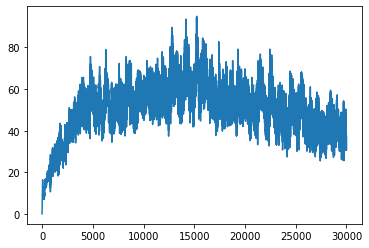

In [21]:
plt.plot(losses);

In [ ]:
import numpy as np

X = np.linspace(-1, 1, 30)
Y = np.linspace(-1, 1, 30)
n_sigma = sigmas.size(0)
grid = np.stack(np.meshgrid(X, Y), axis=-1).reshape(1, -1, 2)
grid_tensor = torch.tensor(grid).float().to(device).expand(n_sigma, -1, -1)
grad_field = score_net(grid_tensor, sigmas)
grad_field_np = grad_field.detach().cpu().numpy()

In [22]:
def get_prior(batch_size, num_points, inp_dim):
    # -2 to 2, uniform
    return torch.rand(batch_size, num_points, inp_dim) * 2. - 1.

def langevin_dynamics(model, sigmas, num_points=2048, dim=3, eps=2*1e-3, num_steps=10):
    with torch.no_grad():
        x_list = []
        model.eval()
        x = get_prior(1, num_points, dim).to(sigmas.device)
        x_list.append(x.clone())
        for sigma in sigmas:
            alpha = eps * (sigma / sigmas[-1])
            for t in range(num_steps):
                z_t = torch.randn_like(x)
                x += torch.sqrt(alpha) * z_t + (alpha / 2.) * model(x, sigma.view(1, -1))
                x_list.append(x.clone())
        return x, x_list

In [23]:
pt_cl, pt_cl_list = langevin_dynamics(score_net, sigmas, eps=0.0001, num_steps=100)
pt_cl_list = [item.detach().cpu().squeeze().numpy() for item in pt_cl_list]

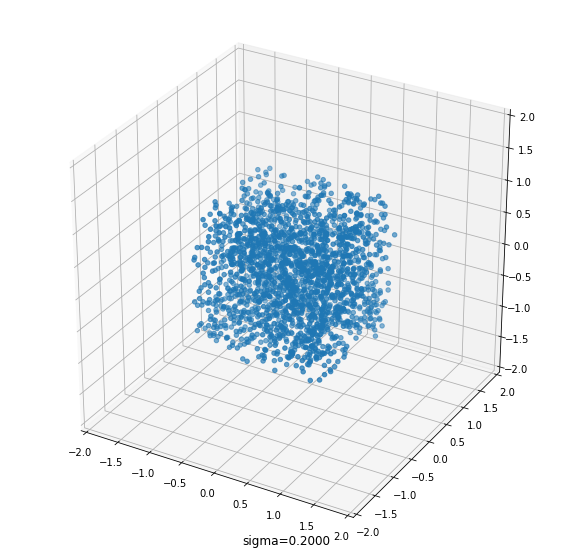

In [24]:
# Visualization
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import Axes3D

rc('animation', html='html5')

def animate(i, data, scat):
    pts = data[i]
    scatter._offsets3d = pts[:, 0], pts[:, 1], pts[:, 2]
    ax1.set_title("sigma={:.4f}".format(sigmas[i // 100].item()))
    return scatter,

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_title("sigma={:.4f}".format(sigmas[0].item()))
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_zlim(-2, 2)
initial_pts = pt_cl_list[0]
scatter = ax1.scatter(initial_pts[:, 0], initial_pts[:, 1], initial_pts[:, 2], s=20)
anim = animation.FuncAnimation(fig, animate, frames=range(len(pt_cl_list) - 1),
                                  fargs=(pt_cl_list, scatter), interval=20)
anim

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(pt_cl_list[-1][:, 2], pt_cl_list[-1][:, 0], pt_cl_list[-1][:, 1], s=20)
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_zlim(-1, 1)